In [1]:
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import gc

from kl_divergence import score as kaggle_score 
from engine_hms_trainer import (
    seed_everything, gen_non_overlap_samples, calc_entropy, evaluate_oof, get_logger, 
    Trainer, TARGETS, TARGETS_PRED, BRAIN_ACTIVITY
    )
from engine_hms_model import (
    KagglePaths, LocalPaths, ModelConfig, CustomDataset, CustomEfficientNET, CustomVITMAE, DualEncoderModel, 
)

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from time import ctime, time
from sklearn.model_selection import KFold

import warnings
# warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
PATHS = KagglePaths if os.path.exists(KagglePaths.OUTPUT_DIR) else LocalPaths
print("Output Dir: ", PATHS.OUTPUT_DIR)

ALL_SPECS = np.load(PATHS.PRE_LOADED_SPECTROGRAMS, allow_pickle=True).item()
ALL_EEGS = np.load(PATHS.PRE_LOADED_EEGS, allow_pickle=True).item()

seed_everything(ModelConfig.SEED)

Output Dir:  ./outputs/


In [3]:
def prepare_k_fold(df, k_folds=5):

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=ModelConfig.SEED)
    unique_spec_id = df['spectrogram_id'].unique()
    df['fold'] = k_folds

    for fold, (train_index, valid_index) in enumerate(kf.split(unique_spec_id)):
        df.loc[df['spectrogram_id'].isin(unique_spec_id[valid_index]), 'fold'] = fold

    return df


def train_fold(model, fold_id, train_folds, valid_folds, logger, stage=1, checkpoint=None):

    train_dataset = CustomDataset(
        train_folds, TARGETS, ModelConfig, ALL_SPECS, ALL_EEGS, mode="train")

    valid_dataset = CustomDataset(
        valid_folds, TARGETS, ModelConfig, ALL_SPECS, ALL_EEGS, mode="valid")

    # ======== DATALOADERS ==========
    loader_kwargs = {
        "batch_size": ModelConfig.BATCH_SIZE,
        "num_workers": ModelConfig.NUM_WORKERS,
        "pin_memory": True,
        "shuffle": False,
    }
    train_loader = DataLoader(train_dataset, drop_last=True, **loader_kwargs)
    valid_loader = DataLoader(valid_dataset, drop_last=False, **loader_kwargs)

    trainer = Trainer(model, ModelConfig, logger)
    best_weights, best_preds, loss_records = trainer.train(
        train_loader, valid_loader, from_checkpoint=checkpoint)

    save_model_name = f"{ModelConfig.MODEL_NAME}_fold_{fold_id}_stage_{stage}.pth"
    torch.save(best_weights, os.path.join(PATHS.OUTPUT_DIR, save_model_name))

    del train_dataset, valid_dataset, train_loader, valid_loader
    torch.cuda.empty_cache()
    gc.collect()

    return best_preds, loss_records

def get_model(pretrained=True):
    
    backbone = ModelConfig.MODEL_BACKBONE

    if "efficientnet" in backbone:
        return CustomEfficientNET(ModelConfig, num_classes=6, pretrained=pretrained)
    elif "vit" in backbone:
        return CustomVITMAE(ModelConfig, num_classes=6, pretrained=pretrained)
    elif "dual" in backbone:
        return DualEncoderModel(ModelConfig, num_classes=6, pretrained=pretrained)
    else:
        return None

In [4]:
TARGET2ID = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}

def calc_kaggle_score(oof_df):
    submission_df = oof_df[['eeg_id']+TARGETS_PRED].copy()
    submission_df.columns = ['eeg_id'] + TARGETS
    solution_df = oof_df[['eeg_id']+TARGETS].copy()
    return kaggle_score(solution_df, submission_df, 'eeg_id')

def analyze_oof(oof_csv):

    kl_criteria = nn.KLDivLoss(reduction='batchmean')
    softmax = nn.Softmax(dim=1)

    oof_df = pd.read_csv(oof_csv)
    oof_df['target_pred'] = oof_df[TARGETS_PRED].apply(lambda x: np.argmax(x), axis=1)
    oof_df['target_id'] = oof_df[TARGETS].apply(lambda x: np.argmax(x), axis=1)
    
    oof_df["kl_loss"] = oof_df.apply(
    lambda row: 
        kl_criteria(
            F.log_softmax(
                    torch.tensor(row[TARGETS_PRED].values.astype(np.float32)).unsqueeze(0)
                , dim=1
                ), 
            torch.tensor(row[TARGETS].values.astype(np.float32))
            ).numpy(),
    axis=1)

    oof_df["kl_loss"] = oof_df['kl_loss'].astype(np.float32)

    oof_df[TARGETS_PRED] = softmax( torch.tensor(oof_df[TARGETS_PRED].values.astype(np.float32)) )

    oof_df.head()

    return oof_df

In [5]:
# train_easy, train_hard, all_specs, all_eegs = load_kaggle_data(
#     paths.TRAIN_CSV, paths.PRE_LOADED_SPECTOGRAMS, paths.PRE_LOADED_EEGS, split_entropy=ModelConfig.SPLIT_ENTROPY)

train_csv = pd.read_csv(PATHS.TRAIN_CSV)
targets = train_csv.columns[-6:]

print("targets: ", targets.to_list())

train_csv['entropy'] = train_csv.apply(calc_entropy, axis=1, tgt_list=targets)
train_csv['total_votes'] = train_csv[targets].sum(axis=1)

hard_csv = train_csv[train_csv['entropy'] < ModelConfig.SPLIT_ENTROPY].copy().reset_index(drop=True)

train_all = gen_non_overlap_samples(train_csv, targets)
train_hard = gen_non_overlap_samples(hard_csv, targets)

print("train_all.shape = ", train_all.shape)
print("train_all nan_count: ", train_all.isnull().sum().sum())
display(train_all.head())

print(" ")

print("train_hard.shape = ", train_hard.shape)
print("train_hard nan_count: ", train_hard.isnull().sum().sum())
display(train_hard.head())

targets:  ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
train_all.shape =  (20183, 12)
train_all nan_count:  0


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target
0,568657,0.0,0.000000,0.25,0.000000,0.166667,0.583333,789577333,0.0,16.0,20654,Other
1,582999,0.0,0.857143,0.00,0.071429,0.000000,0.071429,1552638400,0.0,38.0,20230,LPD
2,642382,0.0,0.000000,0.00,0.000000,0.000000,1.000000,14960202,1008.0,1032.0,5955,Other
3,751790,0.0,0.000000,1.00,0.000000,0.000000,0.000000,618728447,908.0,908.0,38549,GPD
4,778705,0.0,0.000000,0.00,0.000000,0.000000,1.000000,52296320,0.0,0.0,40955,Other


 
train_hard.shape =  (6187, 12)
train_hard nan_count:  0


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target
0,568657,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333,789577333,0.0,16.0,20654,Other
1,582999,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429,1552638400,0.0,38.0,20230,LPD
2,1895581,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154,128369999,1138.0,1138.0,47999,Other
3,2482631,0.000000,0.000000,0.133333,0.066667,0.133333,0.666667,978166025,1902.0,1944.0,20606,Other
4,2521897,0.000000,0.000000,0.083333,0.083333,0.333333,0.500000,673742515,0.0,4.0,62117,Other


In [6]:
# # EfficientNet_B2_resplit (CV=0.5330731377333943)
# ModelConfig.EPOCHS = 6
# ModelConfig.BATCH_SIZE = 16
# ModelConfig.GRADIENT_ACCUMULATION_STEPS = 1
# ModelConfig.MODEL_BACKBONE = 'tf_efficientnet_b2'
# ModelConfig.MODEL_NAME = "EfficientNet_B2_resplit"
# ModelConfig.USE_KAGGLE_SPECTROGRAMS = True
# ModelConfig.USE_EEG_SPECTROGRAMS = True
# ModelConfig.REGULARIZATION = None
# ModelConfig.AUGMENT = True
# ModelConfig.AUGMENTATIONS = ['xy_masking']

# # config DualEncoder
# ModelConfig.EPOCHS = 6
# ModelConfig.BATCH_SIZE = 16
# ModelConfig.GRADIENT_ACCUMULATION_STEPS = 1
# ModelConfig.MODEL_BACKBONE = 'dual_encoder'
# ModelConfig.MODEL_NAME = "DualEncoder_B0"
# ModelConfig.USE_KAGGLE_SPECTROGRAMS = True
# ModelConfig.USE_EEG_SPECTROGRAMS = True
# ModelConfig.REGULARIZATION = None
# ModelConfig.AUGMENT = False
# ModelConfig.AUGMENTATIONS = []
# ModelConfig.DUAL_ENCODER_BACKBONE = 'tf_efficientnet_b0'

# Config ViTMAE
ModelConfig.EPOCHS = 10
ModelConfig.BATCH_SIZE = 16
ModelConfig.GRADIENT_ACCUMULATION_STEPS = 1
ModelConfig.MODEL_BACKBONE = 'vit_mae_base'
ModelConfig.MODEL_NAME = "MAE_Raw_Backbone"
ModelConfig.AUGMENT = True
ModelConfig.USE_KAGGLE_SPECTROGRAMS = True
ModelConfig.USE_EEG_SPECTROGRAMS = True
ModelConfig.REGULARIZATION = None
ModelConfig.AUGMENTATIONS = ['xy_masking']
ModelConfig.MAE_PRETRAINED_WEIGHTS = "facebook/vit-mae-base" #"./outputs/vit_mae_pretraining/ViTMAE_PreTrained_Best.pth"
ModelConfig.MAE_HIDDEN_DROPOUT_PROB = 0.1
ModelConfig.MAE_ATTENTION_DROPOUT_PROB = 0.1
ModelConfig.DROP_RATE = 0.2

In [7]:
logger = get_logger(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_train.log")

logger.info(f"{'*' * 100}")
logger.info(f"Script Start: {ctime()}")
logger.info(f"Model Configurations:")
for key, value in ModelConfig.__dict__.items():
    if not key.startswith("__"):
        logger.info(f"{key}: {value}")
logger.info(f"{'*' * 100}")

k_folds = 5
train_all = prepare_k_fold(train_all, k_folds=k_folds)

oof_stage_1, oof_stage_2 = pd.DataFrame(), pd.DataFrame()
loss_history_1, loss_history_2 = [], []

for fold in range(k_folds):
    tik = time()

    model = get_model(pretrained=True)
    # model = CustomVITMAE(ModelConfig, num_classes=6, pretrained=False)

    valid_folds = train_all[train_all['fold'] == fold].reset_index(drop=True)
    train_folds = train_all[train_all['fold'] != fold].reset_index(drop=True)

    # STAGE 1
    logger.info(f"{'=' * 100}\nFold: {fold} || Valid size {valid_folds.shape[0]} \n{'=' * 100}")
    logger.info(f"- First Stage -")
    valid_predicts, loss_records = train_fold(
        model, fold, train_folds, valid_folds, logger, stage=1, checkpoint=None)

    loss_history_1.append(loss_records)
    valid_folds[TARGETS_PRED] = valid_predicts
    oof_stage_1 = pd.concat([oof_stage_1, valid_folds], axis=0).reset_index(drop=True)
    kl_loss_torch = evaluate_oof(valid_folds)
    info = f"{'=' * 100}\nFold {fold} Valid Loss: {kl_loss_torch}\n"
    info += f"Elapse: {(time() - tik) / 60:.2f} min \n{'=' * 100}"
    logger.info(info)
    oof_stage_1.to_csv(os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_oof_1.csv"), index=False)

    # STAGE 2
    tik = time()
    logger.info(f"- Second Stage -")
    check_point = os.path.join(
        PATHS.OUTPUT_DIR,
        f"{ModelConfig.MODEL_NAME}_fold_{fold}_stage_1.pth"
    )
    logger.info(f"Use Checkpoint: {check_point.split('/')[-1]}")

    model = get_model(pretrained=True)
    valid_predicts, loss_records = train_fold(
        model, fold, train_hard, valid_folds, logger, stage=2, checkpoint=check_point)

    loss_history_2.append(loss_records)
    valid_folds[TARGETS_PRED] = valid_predicts
    oof_stage_2 = pd.concat([oof_stage_2, valid_folds], axis=0).reset_index(drop=True)
    kl_loss_torch = evaluate_oof(valid_folds)
    info = f"{'=' * 100}\nFold {fold} Valid Loss: {kl_loss_torch}\n"
    info += f"Elapse: {(time() - tik) / 60:.2f} min \n{'=' * 100}"
    logger.info(info)
    oof_stage_2.to_csv(os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_oof_2.csv"), index=False)

****************************************************************************************************
Script Start: Sun Mar 24 21:38:42 2024
Model Configurations:
SEED: 20
SPLIT_ENTROPY: 5.5
MODEL_NAME: MAE_Raw_Backbone
MODEL_BACKBONE: vit_mae_base
BATCH_SIZE: 16
EPOCHS: 10
GRADIENT_ACCUMULATION_STEPS: 1
DROP_RATE: 0.2
DROP_PATH_RATE: 0.25
WEIGHT_DECAY: 0.01
REGULARIZATION: None
USE_KAGGLE_SPECTROGRAMS: True
USE_EEG_SPECTROGRAMS: True
AMP: True
AUGMENT: True
AUGMENTATIONS: ['xy_masking']
PRINT_FREQ: 50
FREEZE: False
NUM_FROZEN_LAYERS: 0
NUM_WORKERS: 0
MAX_GRAD_NORM: 10000000.0
DUAL_ENCODER_BACKBONE: tf_efficientnet_b2
MAE_PRETRAINED_WEIGHTS: facebook/vit-mae-base
MAE_HIDDEN_DROPOUT_PROB: 0.1
MAE_ATTENTION_DROPOUT_PROB: 0.1
****************************************************************************************************


Loading pretrained weights from facebook/vit-mae-base


Fold: 0 || Valid size 3988 
- First Stage -


Train [0]:   0%|          | 0/1012 [00:00<?, ?batch/s]

Epoch 1 [0/1012] | Train Loss: 1.5125 Grad: 79802.0547 LR: 4.0002e-06 | Elapse: 0.83s
Epoch 1 [50/1012] | Train Loss: 1.4284 Grad: 65676.4297 LR: 4.6015e-06 | Elapse: 4.78s
Epoch 1 [100/1012] | Train Loss: 1.3814 Grad: 75379.9766 LR: 6.3447e-06 | Elapse: 8.64s
Epoch 1 [150/1012] | Train Loss: 1.3388 Grad: 76271.6484 LR: 9.1878e-06 | Elapse: 12.50s
Epoch 1 [200/1012] | Train Loss: 1.3152 Grad: 214073.9219 LR: 1.3062e-05 | Elapse: 16.38s
Epoch 1 [250/1012] | Train Loss: 1.3098 Grad: 109115.9844 LR: 1.7875e-05 | Elapse: 20.23s
Epoch 1 [300/1012] | Train Loss: 1.3053 Grad: 87156.0078 LR: 2.3509e-05 | Elapse: 24.09s
Epoch 1 [350/1012] | Train Loss: 1.2991 Grad: 223324.6875 LR: 2.9831e-05 | Elapse: 27.99s
Epoch 1 [400/1012] | Train Loss: 1.2883 Grad: 222923.6562 LR: 3.6686e-05 | Elapse: 31.86s
Epoch 1 [450/1012] | Train Loss: 1.2690 Grad: 159761.4062 LR: 4.3910e-05 | Elapse: 35.74s
Epoch 1 [500/1012] | Train Loss: 1.2511 Grad: 216466.3906 LR: 5.1329e-05 | Elapse: 39.73s
Epoch 1 [550/1012] | 

Valid [0]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 1 [0/250] | Valid Loss: 0.7482 | Elapse: 0.06s
Epoch 1 [50/250] | Valid Loss: 1.0247 | Elapse: 2.52s
Epoch 1 [100/250] | Valid Loss: 1.0317 | Elapse: 5.12s
Epoch 1 [150/250] | Valid Loss: 1.0570 | Elapse: 7.81s
Epoch 1 [200/250] | Valid Loss: 1.0538 | Elapse: 10.43s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.1238; (valid) 1.0551 | Time: 93.08s
Best model found in epoch 1 | valid loss: 1.0551


Epoch 1 [249/250] | Valid Loss: 1.0551 | Elapse: 12.96s


Train [1]:   0%|          | 0/1012 [00:00<?, ?batch/s]

Epoch 2 [0/1012] | Train Loss: 1.1442 Grad: 182002.3750 LR: 1.0000e-04 | Elapse: 0.09s
Epoch 2 [50/1012] | Train Loss: 0.9354 Grad: 194359.6875 LR: 9.9992e-05 | Elapse: 4.02s
Epoch 2 [100/1012] | Train Loss: 0.9133 Grad: 183987.7656 LR: 9.9969e-05 | Elapse: 7.90s
Epoch 2 [150/1012] | Train Loss: 0.9078 Grad: 167776.8750 LR: 9.9931e-05 | Elapse: 11.79s
Epoch 2 [200/1012] | Train Loss: 0.8991 Grad: 160814.9219 LR: 9.9879e-05 | Elapse: 15.70s
Epoch 2 [250/1012] | Train Loss: 0.9043 Grad: 178336.5781 LR: 9.9811e-05 | Elapse: 19.57s
Epoch 2 [300/1012] | Train Loss: 0.9005 Grad: 114207.6328 LR: 9.9729e-05 | Elapse: 23.46s
Epoch 2 [350/1012] | Train Loss: 0.9018 Grad: 272780.3438 LR: 9.9632e-05 | Elapse: 27.39s
Epoch 2 [400/1012] | Train Loss: 0.8991 Grad: 240732.9062 LR: 9.9520e-05 | Elapse: 31.31s
Epoch 2 [450/1012] | Train Loss: 0.8982 Grad: 126988.8984 LR: 9.9394e-05 | Elapse: 35.25s
Epoch 2 [500/1012] | Train Loss: 0.8928 Grad: 232624.3281 LR: 9.9253e-05 | Elapse: 39.22s
Epoch 2 [550/101

Valid [1]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 2 [0/250] | Valid Loss: 0.5244 | Elapse: 0.05s
Epoch 2 [50/250] | Valid Loss: 0.8153 | Elapse: 2.50s
Epoch 2 [100/250] | Valid Loss: 0.7986 | Elapse: 5.06s
Epoch 2 [150/250] | Valid Loss: 0.8286 | Elapse: 7.65s
Epoch 2 [200/250] | Valid Loss: 0.8290 | Elapse: 10.28s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.8588; (valid) 0.8345 | Time: 91.69s
Best model found in epoch 2 | valid loss: 0.8345


Epoch 2 [249/250] | Valid Loss: 0.8345 | Elapse: 12.83s


Train [2]:   0%|          | 0/1012 [00:00<?, ?batch/s]

Epoch 3 [0/1012] | Train Loss: 0.8240 Grad: 151112.9375 LR: 9.6974e-05 | Elapse: 0.09s
Epoch 3 [50/1012] | Train Loss: 0.7776 Grad: 173345.1250 LR: 9.6672e-05 | Elapse: 4.01s
Epoch 3 [100/1012] | Train Loss: 0.7620 Grad: 184619.9688 LR: 9.6355e-05 | Elapse: 7.96s
Epoch 3 [150/1012] | Train Loss: 0.7631 Grad: 165777.6875 LR: 9.6025e-05 | Elapse: 12.03s
Epoch 3 [200/1012] | Train Loss: 0.7612 Grad: 228454.7812 LR: 9.5682e-05 | Elapse: 15.95s
Epoch 3 [250/1012] | Train Loss: 0.7672 Grad: 318554.0938 LR: 9.5325e-05 | Elapse: 19.87s
Epoch 3 [300/1012] | Train Loss: 0.7611 Grad: 126689.0469 LR: 9.4954e-05 | Elapse: 23.83s
Epoch 3 [350/1012] | Train Loss: 0.7628 Grad: 326258.2812 LR: 9.4570e-05 | Elapse: 27.76s
Epoch 3 [400/1012] | Train Loss: 0.7645 Grad: 225351.7969 LR: 9.4172e-05 | Elapse: 31.65s
Epoch 3 [450/1012] | Train Loss: 0.7667 Grad: 121762.7266 LR: 9.3762e-05 | Elapse: 35.54s
Epoch 3 [500/1012] | Train Loss: 0.7629 Grad: 327517.3125 LR: 9.3338e-05 | Elapse: 39.47s
Epoch 3 [550/101

Valid [2]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 3 [0/250] | Valid Loss: 0.4874 | Elapse: 0.06s
Epoch 3 [50/250] | Valid Loss: 0.7312 | Elapse: 2.52s
Epoch 3 [100/250] | Valid Loss: 0.7179 | Elapse: 5.07s
Epoch 3 [150/250] | Valid Loss: 0.7352 | Elapse: 7.72s
Epoch 3 [200/250] | Valid Loss: 0.7351 | Elapse: 10.40s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.7485; (valid) 0.7424 | Time: 92.79s
Best model found in epoch 3 | valid loss: 0.7424


Epoch 3 [249/250] | Valid Loss: 0.7424 | Elapse: 12.95s


Train [3]:   0%|          | 0/1012 [00:00<?, ?batch/s]

Epoch 4 [0/1012] | Train Loss: 0.6775 Grad: 147934.2031 LR: 8.8285e-05 | Elapse: 0.09s
Epoch 4 [50/1012] | Train Loss: 0.7184 Grad: 150223.8125 LR: 8.7725e-05 | Elapse: 3.98s
Epoch 4 [100/1012] | Train Loss: 0.6959 Grad: 163287.1094 LR: 8.7153e-05 | Elapse: 7.89s
Epoch 4 [150/1012] | Train Loss: 0.7026 Grad: 160452.4375 LR: 8.6571e-05 | Elapse: 11.77s
Epoch 4 [200/1012] | Train Loss: 0.7035 Grad: 141274.0781 LR: 8.5977e-05 | Elapse: 15.65s
Epoch 4 [250/1012] | Train Loss: 0.7084 Grad: 215513.6406 LR: 8.5373e-05 | Elapse: 19.58s
Epoch 4 [300/1012] | Train Loss: 0.7025 Grad: 167843.5000 LR: 8.4759e-05 | Elapse: 23.50s
Epoch 4 [350/1012] | Train Loss: 0.7065 Grad: 311005.9375 LR: 8.4134e-05 | Elapse: 27.47s
Epoch 4 [400/1012] | Train Loss: 0.7046 Grad: 263872.5938 LR: 8.3499e-05 | Elapse: 31.38s
Epoch 4 [450/1012] | Train Loss: 0.7036 Grad: 136995.4531 LR: 8.2854e-05 | Elapse: 35.26s
Epoch 4 [500/1012] | Train Loss: 0.7009 Grad: 181344.1250 LR: 8.2199e-05 | Elapse: 39.19s
Epoch 4 [550/101

Valid [3]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 4 [0/250] | Valid Loss: 0.5923 | Elapse: 0.05s
Epoch 4 [50/250] | Valid Loss: 0.7021 | Elapse: 2.52s
Epoch 4 [100/250] | Valid Loss: 0.6803 | Elapse: 5.09s
Epoch 4 [150/250] | Valid Loss: 0.7021 | Elapse: 7.70s
Epoch 4 [200/250] | Valid Loss: 0.7083 | Elapse: 10.35s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.6871; (valid) 0.7084 | Time: 92.44s
Best model found in epoch 4 | valid loss: 0.7084


Epoch 4 [249/250] | Valid Loss: 0.7084 | Elapse: 12.91s


Train [4]:   0%|          | 0/1012 [00:00<?, ?batch/s]

Epoch 5 [0/1012] | Train Loss: 0.7220 Grad: 165059.8906 LR: 7.4980e-05 | Elapse: 0.09s
Epoch 5 [50/1012] | Train Loss: 0.6391 Grad: 184516.2031 LR: 7.4230e-05 | Elapse: 4.01s
Epoch 5 [100/1012] | Train Loss: 0.6300 Grad: 190006.2031 LR: 7.3472e-05 | Elapse: 7.94s
Epoch 5 [150/1012] | Train Loss: 0.6397 Grad: 240793.0312 LR: 7.2707e-05 | Elapse: 11.86s
Epoch 5 [200/1012] | Train Loss: 0.6366 Grad: 171070.3906 LR: 7.1936e-05 | Elapse: 15.82s
Epoch 5 [250/1012] | Train Loss: 0.6439 Grad: 185492.5000 LR: 7.1158e-05 | Elapse: 19.78s
Epoch 5 [300/1012] | Train Loss: 0.6408 Grad: 182857.8281 LR: 7.0374e-05 | Elapse: 23.71s
Epoch 5 [350/1012] | Train Loss: 0.6421 Grad: 412434.6562 LR: 6.9584e-05 | Elapse: 27.61s
Epoch 5 [400/1012] | Train Loss: 0.6403 Grad: 334224.2812 LR: 6.8788e-05 | Elapse: 31.50s
Epoch 5 [450/1012] | Train Loss: 0.6430 Grad: 170524.6875 LR: 6.7986e-05 | Elapse: 35.42s
Epoch 5 [500/1012] | Train Loss: 0.6391 Grad: 131612.5469 LR: 6.7179e-05 | Elapse: 39.36s
Epoch 5 [550/101

Valid [4]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 5 [0/250] | Valid Loss: 0.5747 | Elapse: 0.06s
Epoch 5 [50/250] | Valid Loss: 0.6803 | Elapse: 2.54s
Epoch 5 [100/250] | Valid Loss: 0.6436 | Elapse: 5.14s
Epoch 5 [150/250] | Valid Loss: 0.6607 | Elapse: 7.80s
Epoch 5 [200/250] | Valid Loss: 0.6627 | Elapse: 10.44s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.6313; (valid) 0.6683 | Time: 92.54s
Best model found in epoch 5 | valid loss: 0.6683


Epoch 5 [249/250] | Valid Loss: 0.6683 | Elapse: 12.98s


Train [5]:   0%|          | 0/1012 [00:00<?, ?batch/s]

Epoch 6 [0/1012] | Train Loss: 0.5534 Grad: 178304.3906 LR: 5.8665e-05 | Elapse: 0.10s
Epoch 6 [50/1012] | Train Loss: 0.5980 Grad: 209538.9688 LR: 5.7815e-05 | Elapse: 4.04s
Epoch 6 [100/1012] | Train Loss: 0.5866 Grad: 171145.1719 LR: 5.6962e-05 | Elapse: 8.07s
Epoch 6 [150/1012] | Train Loss: 0.5881 Grad: 228381.4219 LR: 5.6108e-05 | Elapse: 11.99s
Epoch 6 [200/1012] | Train Loss: 0.5911 Grad: 151072.5938 LR: 5.5251e-05 | Elapse: 15.92s
Epoch 6 [250/1012] | Train Loss: 0.5945 Grad: 203445.9844 LR: 5.4393e-05 | Elapse: 19.82s
Epoch 6 [300/1012] | Train Loss: 0.5904 Grad: 201766.0000 LR: 5.3534e-05 | Elapse: 23.71s
Epoch 6 [350/1012] | Train Loss: 0.5935 Grad: 302832.1562 LR: 5.2674e-05 | Elapse: 27.62s
Epoch 6 [400/1012] | Train Loss: 0.5912 Grad: 221019.3438 LR: 5.1813e-05 | Elapse: 31.55s
Epoch 6 [450/1012] | Train Loss: 0.5927 Grad: 200448.6562 LR: 5.0951e-05 | Elapse: 35.48s
Epoch 6 [500/1012] | Train Loss: 0.5902 Grad: 209379.8906 LR: 5.0089e-05 | Elapse: 39.42s
Epoch 6 [550/101

Valid [5]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 6 [0/250] | Valid Loss: 0.3731 | Elapse: 0.05s
Epoch 6 [50/250] | Valid Loss: 0.6553 | Elapse: 2.53s
Epoch 6 [100/250] | Valid Loss: 0.6241 | Elapse: 5.14s
Epoch 6 [150/250] | Valid Loss: 0.6486 | Elapse: 7.79s
Epoch 6 [200/250] | Valid Loss: 0.6550 | Elapse: 10.45s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.5858; (valid) 0.6616 | Time: 92.60s
Best model found in epoch 6 | valid loss: 0.6616


Epoch 6 [249/250] | Valid Loss: 0.6616 | Elapse: 13.02s


Train [6]:   0%|          | 0/1012 [00:00<?, ?batch/s]

Epoch 7 [0/1012] | Train Loss: 0.6870 Grad: 227348.7344 LR: 4.1307e-05 | Elapse: 0.09s
Epoch 7 [50/1012] | Train Loss: 0.5641 Grad: 222305.6719 LR: 4.0460e-05 | Elapse: 4.00s
Epoch 7 [100/1012] | Train Loss: 0.5531 Grad: 140020.7188 LR: 3.9615e-05 | Elapse: 7.90s
Epoch 7 [150/1012] | Train Loss: 0.5557 Grad: 213525.4688 LR: 3.8774e-05 | Elapse: 11.82s
Epoch 7 [200/1012] | Train Loss: 0.5531 Grad: 190577.4219 LR: 3.7935e-05 | Elapse: 15.75s
Epoch 7 [250/1012] | Train Loss: 0.5568 Grad: 144256.9219 LR: 3.7101e-05 | Elapse: 19.66s
Epoch 7 [300/1012] | Train Loss: 0.5509 Grad: 245319.9219 LR: 3.6270e-05 | Elapse: 23.57s
Epoch 7 [350/1012] | Train Loss: 0.5538 Grad: 253422.7656 LR: 3.5444e-05 | Elapse: 27.54s
Epoch 7 [400/1012] | Train Loss: 0.5534 Grad: 211798.8125 LR: 3.4621e-05 | Elapse: 31.44s
Epoch 7 [450/1012] | Train Loss: 0.5544 Grad: 212313.3281 LR: 3.3804e-05 | Elapse: 35.35s
Epoch 7 [500/1012] | Train Loss: 0.5506 Grad: 159108.4531 LR: 3.2991e-05 | Elapse: 39.26s
Epoch 7 [550/101

Valid [6]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 7 [0/250] | Valid Loss: 0.4107 | Elapse: 0.05s
Epoch 7 [50/250] | Valid Loss: 0.6428 | Elapse: 2.55s
Epoch 7 [100/250] | Valid Loss: 0.5980 | Elapse: 5.18s
Epoch 7 [150/250] | Valid Loss: 0.6251 | Elapse: 7.85s
Epoch 7 [200/250] | Valid Loss: 0.6282 | Elapse: 10.54s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.5434; (valid) 0.6393 | Time: 92.44s
Best model found in epoch 7 | valid loss: 0.6393


Epoch 7 [249/250] | Valid Loss: 0.6393 | Elapse: 13.11s


Train [7]:   0%|          | 0/1012 [00:00<?, ?batch/s]

Epoch 8 [0/1012] | Train Loss: 0.4807 Grad: 171862.3281 LR: 2.5000e-05 | Elapse: 0.09s
Epoch 8 [50/1012] | Train Loss: 0.4923 Grad: 215642.7500 LR: 2.4258e-05 | Elapse: 3.99s
Epoch 8 [100/1012] | Train Loss: 0.4852 Grad: 130688.1953 LR: 2.3523e-05 | Elapse: 7.91s
Epoch 8 [150/1012] | Train Loss: 0.4988 Grad: 268166.5312 LR: 2.2796e-05 | Elapse: 11.81s
Epoch 8 [200/1012] | Train Loss: 0.5053 Grad: 210994.1094 LR: 2.2077e-05 | Elapse: 15.71s
Epoch 8 [250/1012] | Train Loss: 0.5148 Grad: 158641.8438 LR: 2.1367e-05 | Elapse: 19.61s
Epoch 8 [300/1012] | Train Loss: 0.5164 Grad: 184391.4375 LR: 2.0665e-05 | Elapse: 23.51s
Epoch 8 [350/1012] | Train Loss: 0.5168 Grad: 274303.5312 LR: 1.9972e-05 | Elapse: 27.41s
Epoch 8 [400/1012] | Train Loss: 0.5136 Grad: 260164.1719 LR: 1.9287e-05 | Elapse: 31.32s
Epoch 8 [450/1012] | Train Loss: 0.5156 Grad: 241211.5156 LR: 1.8612e-05 | Elapse: 35.23s
Epoch 8 [500/1012] | Train Loss: 0.5157 Grad: 208914.9844 LR: 1.7946e-05 | Elapse: 39.13s
Epoch 8 [550/101

Valid [7]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 8 [0/250] | Valid Loss: 0.3415 | Elapse: 0.05s
Epoch 8 [50/250] | Valid Loss: 0.5998 | Elapse: 2.57s
Epoch 8 [100/250] | Valid Loss: 0.5604 | Elapse: 5.22s
Epoch 8 [150/250] | Valid Loss: 0.5896 | Elapse: 7.91s
Epoch 8 [200/250] | Valid Loss: 0.5947 | Elapse: 10.59s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.5112; (valid) 0.6053 | Time: 92.26s
Best model found in epoch 8 | valid loss: 0.6053


Epoch 8 [249/250] | Valid Loss: 0.6053 | Elapse: 13.16s


Train [8]:   0%|          | 0/1012 [00:00<?, ?batch/s]

Epoch 9 [0/1012] | Train Loss: 0.6418 Grad: 203070.1094 LR: 1.1711e-05 | Elapse: 0.09s
Epoch 9 [50/1012] | Train Loss: 0.5005 Grad: 283883.2812 LR: 1.1163e-05 | Elapse: 3.99s
Epoch 9 [100/1012] | Train Loss: 0.4802 Grad: 170721.3594 LR: 1.0627e-05 | Elapse: 7.89s
Epoch 9 [150/1012] | Train Loss: 0.4804 Grad: 295339.9062 LR: 1.0102e-05 | Elapse: 11.81s
Epoch 9 [200/1012] | Train Loss: 0.4911 Grad: 216396.2969 LR: 9.5894e-06 | Elapse: 15.74s
Epoch 9 [250/1012] | Train Loss: 0.4959 Grad: 182622.9688 LR: 9.0887e-06 | Elapse: 19.66s
Epoch 9 [300/1012] | Train Loss: 0.4930 Grad: 159273.8750 LR: 8.6001e-06 | Elapse: 23.56s
Epoch 9 [350/1012] | Train Loss: 0.4917 Grad: 328482.5312 LR: 8.1239e-06 | Elapse: 27.46s
Epoch 9 [400/1012] | Train Loss: 0.4896 Grad: 243548.8594 LR: 7.6602e-06 | Elapse: 31.36s
Epoch 9 [450/1012] | Train Loss: 0.4907 Grad: 158606.5469 LR: 7.2090e-06 | Elapse: 35.26s
Epoch 9 [500/1012] | Train Loss: 0.4908 Grad: 170921.6094 LR: 6.7706e-06 | Elapse: 39.19s
Epoch 9 [550/101

Valid [8]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 9 [0/250] | Valid Loss: 0.3836 | Elapse: 0.05s
Epoch 9 [50/250] | Valid Loss: 0.6011 | Elapse: 2.55s
Epoch 9 [100/250] | Valid Loss: 0.5703 | Elapse: 5.17s
Epoch 9 [150/250] | Valid Loss: 0.5945 | Elapse: 7.82s
Epoch 9 [200/250] | Valid Loss: 0.5984 | Elapse: 10.48s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.4855; (valid) 0.6070 | Time: 92.35s


Epoch 9 [249/250] | Valid Loss: 0.6070 | Elapse: 13.06s


Train [9]:   0%|          | 0/1012 [00:00<?, ?batch/s]

Epoch 10 [0/1012] | Train Loss: 0.3928 Grad: 166350.4219 LR: 3.0424e-06 | Elapse: 0.09s
Epoch 10 [50/1012] | Train Loss: 0.4588 Grad: 231253.0312 LR: 2.7551e-06 | Elapse: 4.03s
Epoch 10 [100/1012] | Train Loss: 0.4472 Grad: 112167.7109 LR: 2.4819e-06 | Elapse: 7.95s
Epoch 10 [150/1012] | Train Loss: 0.4593 Grad: 309293.6875 LR: 2.2229e-06 | Elapse: 11.85s
Epoch 10 [200/1012] | Train Loss: 0.4639 Grad: 218580.2656 LR: 1.9780e-06 | Elapse: 15.77s
Epoch 10 [250/1012] | Train Loss: 0.4710 Grad: 173891.1250 LR: 1.7475e-06 | Elapse: 19.67s
Epoch 10 [300/1012] | Train Loss: 0.4691 Grad: 171920.5156 LR: 1.5313e-06 | Elapse: 23.60s
Epoch 10 [350/1012] | Train Loss: 0.4693 Grad: 236323.5000 LR: 1.3295e-06 | Elapse: 27.52s
Epoch 10 [400/1012] | Train Loss: 0.4675 Grad: 224256.7969 LR: 1.1422e-06 | Elapse: 31.49s
Epoch 10 [450/1012] | Train Loss: 0.4697 Grad: 157495.7812 LR: 9.6949e-07 | Elapse: 35.43s
Epoch 10 [500/1012] | Train Loss: 0.4674 Grad: 150591.2031 LR: 8.1133e-07 | Elapse: 39.34s
Epoch

Valid [9]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 10 [0/250] | Valid Loss: 0.5256 | Elapse: 0.06s
Epoch 10 [50/250] | Valid Loss: 0.6521 | Elapse: 2.57s
Epoch 10 [100/250] | Valid Loss: 0.6071 | Elapse: 5.29s
Epoch 10 [150/250] | Valid Loss: 0.6252 | Elapse: 7.96s
Epoch 10 [200/250] | Valid Loss: 0.6324 | Elapse: 10.63s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.4677; (valid) 0.6386 | Time: 92.91s


Epoch 10 [249/250] | Valid Loss: 0.6386 | Elapse: 13.22s


Fold 0 Valid Loss: 0.6052629351615906
Elapse: 15.45 min 
- Second Stage -
Use Checkpoint: MAE_Raw_Backbone_fold_0_stage_1.pth


Loading pretrained weights from facebook/vit-mae-base


Train [0]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 1 [0/386] | Train Loss: 0.4518 Grad: 159648.0781 LR: 4.0016e-06 | Elapse: 0.09s
Epoch 1 [50/386] | Train Loss: 0.4192 Grad: 124809.5859 LR: 8.0969e-06 | Elapse: 4.10s
Epoch 1 [100/386] | Train Loss: 0.4064 Grad: 93410.3906 LR: 1.9400e-05 | Elapse: 8.02s
Epoch 1 [150/386] | Train Loss: 0.3916 Grad: 143528.8594 LR: 3.6054e-05 | Elapse: 11.94s
Epoch 1 [200/386] | Train Loss: 0.3875 Grad: 144099.1562 LR: 5.5327e-05 | Elapse: 15.90s
Epoch 1 [250/386] | Train Loss: 0.3897 Grad: 105585.0156 LR: 7.4053e-05 | Elapse: 19.81s
Epoch 1 [300/386] | Train Loss: 0.3901 Grad: 110158.7422 LR: 8.9159e-05 | Elapse: 23.73s
Epoch 1 [350/386] | Train Loss: 0.3916 Grad: 107431.1797 LR: 9.8164e-05 | Elapse: 27.65s
Epoch 1 [385/386] | Train Loss: 0.3919 Grad: 164218.5156 LR: 1.0000e-04 | Elapse: 30.38s


Valid [0]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 1 [0/250] | Valid Loss: 0.6584 | Elapse: 0.05s
Epoch 1 [50/250] | Valid Loss: 0.7606 | Elapse: 2.55s
Epoch 1 [100/250] | Valid Loss: 0.7448 | Elapse: 5.17s
Epoch 1 [150/250] | Valid Loss: 0.7520 | Elapse: 7.86s
Epoch 1 [200/250] | Valid Loss: 0.7592 | Elapse: 10.54s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.3919; (valid) 0.7596 | Time: 43.51s
Best model found in epoch 1 | valid loss: 0.7596


Epoch 1 [249/250] | Valid Loss: 0.7596 | Elapse: 13.13s


Train [1]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 2 [0/386] | Train Loss: 0.5319 Grad: 136073.5469 LR: 1.0000e-04 | Elapse: 0.09s
Epoch 2 [50/386] | Train Loss: 0.4240 Grad: 97194.1641 LR: 9.9945e-05 | Elapse: 4.05s
Epoch 2 [100/386] | Train Loss: 0.4162 Grad: 112830.6172 LR: 9.9788e-05 | Elapse: 8.02s
Epoch 2 [150/386] | Train Loss: 0.4105 Grad: 104376.8516 LR: 9.9529e-05 | Elapse: 11.96s
Epoch 2 [200/386] | Train Loss: 0.4050 Grad: 116874.8359 LR: 9.9168e-05 | Elapse: 15.92s
Epoch 2 [250/386] | Train Loss: 0.4061 Grad: 101701.2109 LR: 9.8708e-05 | Elapse: 19.87s
Epoch 2 [300/386] | Train Loss: 0.4064 Grad: 124621.4844 LR: 9.8148e-05 | Elapse: 23.90s
Epoch 2 [350/386] | Train Loss: 0.4041 Grad: 110414.2344 LR: 9.7489e-05 | Elapse: 27.83s
Epoch 2 [385/386] | Train Loss: 0.4009 Grad: 92245.2109 LR: 9.6970e-05 | Elapse: 30.59s


Valid [1]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 2 [0/250] | Valid Loss: 0.7080 | Elapse: 0.05s
Epoch 2 [50/250] | Valid Loss: 0.7437 | Elapse: 2.54s
Epoch 2 [100/250] | Valid Loss: 0.7127 | Elapse: 5.15s
Epoch 2 [150/250] | Valid Loss: 0.7278 | Elapse: 7.78s
Epoch 2 [200/250] | Valid Loss: 0.7258 | Elapse: 10.45s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.4009; (valid) 0.7288 | Time: 43.64s
Best model found in epoch 2 | valid loss: 0.7288


Epoch 2 [249/250] | Valid Loss: 0.7288 | Elapse: 13.05s


Train [2]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 3 [0/386] | Train Loss: 0.3905 Grad: 110467.2891 LR: 9.6955e-05 | Elapse: 0.09s
Epoch 3 [50/386] | Train Loss: 0.3797 Grad: 104962.6562 LR: 9.6130e-05 | Elapse: 4.08s
Epoch 3 [100/386] | Train Loss: 0.3837 Grad: 84193.0703 LR: 9.5212e-05 | Elapse: 8.10s
Epoch 3 [150/386] | Train Loss: 0.3737 Grad: 110671.0469 LR: 9.4201e-05 | Elapse: 12.07s
Epoch 3 [200/386] | Train Loss: 0.3741 Grad: 116697.3203 LR: 9.3099e-05 | Elapse: 16.02s
Epoch 3 [250/386] | Train Loss: 0.3764 Grad: 102106.6172 LR: 9.1910e-05 | Elapse: 19.99s
Epoch 3 [300/386] | Train Loss: 0.3760 Grad: 129823.7344 LR: 9.0635e-05 | Elapse: 24.08s
Epoch 3 [350/386] | Train Loss: 0.3744 Grad: 94343.5078 LR: 8.9276e-05 | Elapse: 28.02s
Epoch 3 [385/386] | Train Loss: 0.3721 Grad: 110961.6562 LR: 8.8278e-05 | Elapse: 30.79s


Valid [2]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 3 [0/250] | Valid Loss: 0.7367 | Elapse: 0.05s
Epoch 3 [50/250] | Valid Loss: 0.7324 | Elapse: 2.54s
Epoch 3 [100/250] | Valid Loss: 0.7192 | Elapse: 5.15s
Epoch 3 [150/250] | Valid Loss: 0.7368 | Elapse: 7.82s
Epoch 3 [200/250] | Valid Loss: 0.7404 | Elapse: 10.49s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.3721; (valid) 0.7380 | Time: 44.01s


Epoch 3 [249/250] | Valid Loss: 0.7380 | Elapse: 13.22s


Train [3]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 4 [0/386] | Train Loss: 0.3382 Grad: 96683.8828 LR: 8.8249e-05 | Elapse: 0.10s
Epoch 4 [50/386] | Train Loss: 0.3615 Grad: 129748.5859 LR: 8.6754e-05 | Elapse: 4.15s
Epoch 4 [100/386] | Train Loss: 0.3593 Grad: 68414.1719 LR: 8.5185e-05 | Elapse: 8.10s
Epoch 4 [150/386] | Train Loss: 0.3544 Grad: 87029.4766 LR: 8.3544e-05 | Elapse: 12.07s
Epoch 4 [200/386] | Train Loss: 0.3488 Grad: 100760.5078 LR: 8.1834e-05 | Elapse: 16.02s
Epoch 4 [250/386] | Train Loss: 0.3525 Grad: 129699.0547 LR: 8.0059e-05 | Elapse: 19.93s
Epoch 4 [300/386] | Train Loss: 0.3531 Grad: 103881.0703 LR: 7.8223e-05 | Elapse: 23.84s
Epoch 4 [350/386] | Train Loss: 0.3523 Grad: 117242.5938 LR: 7.6329e-05 | Elapse: 27.90s
Epoch 4 [385/386] | Train Loss: 0.3497 Grad: 103605.7500 LR: 7.4971e-05 | Elapse: 30.72s


Valid [3]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 4 [0/250] | Valid Loss: 0.7585 | Elapse: 0.06s
Epoch 4 [50/250] | Valid Loss: 0.7278 | Elapse: 2.55s
Epoch 4 [100/250] | Valid Loss: 0.7050 | Elapse: 5.14s
Epoch 4 [150/250] | Valid Loss: 0.7255 | Elapse: 7.81s
Epoch 4 [200/250] | Valid Loss: 0.7271 | Elapse: 10.49s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.3497; (valid) 0.7269 | Time: 43.81s
Best model found in epoch 4 | valid loss: 0.7269


Epoch 4 [249/250] | Valid Loss: 0.7269 | Elapse: 13.09s


Train [4]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 5 [0/386] | Train Loss: 0.4546 Grad: 172553.2031 LR: 7.4932e-05 | Elapse: 0.10s
Epoch 5 [50/386] | Train Loss: 0.3486 Grad: 79516.5234 LR: 7.2948e-05 | Elapse: 4.04s
Epoch 5 [100/386] | Train Loss: 0.3419 Grad: 113094.6484 LR: 7.0917e-05 | Elapse: 7.96s
Epoch 5 [150/386] | Train Loss: 0.3378 Grad: 90618.3594 LR: 6.8843e-05 | Elapse: 11.97s
Epoch 5 [200/386] | Train Loss: 0.3338 Grad: 126591.4297 LR: 6.6731e-05 | Elapse: 15.87s
Epoch 5 [250/386] | Train Loss: 0.3354 Grad: 108673.5625 LR: 6.4585e-05 | Elapse: 19.76s
Epoch 5 [300/386] | Train Loss: 0.3370 Grad: 92611.4531 LR: 6.2409e-05 | Elapse: 23.65s
Epoch 5 [350/386] | Train Loss: 0.3349 Grad: 81587.7422 LR: 6.0208e-05 | Elapse: 27.57s
Epoch 5 [385/386] | Train Loss: 0.3327 Grad: 118576.4688 LR: 5.8654e-05 | Elapse: 30.30s


Valid [4]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 5 [0/250] | Valid Loss: 0.6021 | Elapse: 0.05s
Epoch 5 [50/250] | Valid Loss: 0.7534 | Elapse: 2.51s
Epoch 5 [100/250] | Valid Loss: 0.7137 | Elapse: 5.09s
Epoch 5 [150/250] | Valid Loss: 0.7267 | Elapse: 7.75s
Epoch 5 [200/250] | Valid Loss: 0.7362 | Elapse: 10.42s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.3327; (valid) 0.7318 | Time: 43.29s


Epoch 5 [249/250] | Valid Loss: 0.7318 | Elapse: 13.00s


Train [5]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 6 [0/386] | Train Loss: 0.4324 Grad: 156065.3438 LR: 5.8610e-05 | Elapse: 0.09s
Epoch 6 [50/386] | Train Loss: 0.3198 Grad: 102992.2891 LR: 5.6376e-05 | Elapse: 4.03s
Epoch 6 [100/386] | Train Loss: 0.3180 Grad: 70003.5312 LR: 5.4128e-05 | Elapse: 7.94s
Epoch 6 [150/386] | Train Loss: 0.3099 Grad: 95309.3125 LR: 5.1873e-05 | Elapse: 11.85s
Epoch 6 [200/386] | Train Loss: 0.3091 Grad: 107903.6328 LR: 4.9613e-05 | Elapse: 15.76s
Epoch 6 [250/386] | Train Loss: 0.3082 Grad: 103040.2422 LR: 4.7355e-05 | Elapse: 19.68s
Epoch 6 [300/386] | Train Loss: 0.3102 Grad: 94987.4297 LR: 4.5101e-05 | Elapse: 23.59s
Epoch 6 [350/386] | Train Loss: 0.3091 Grad: 135933.2344 LR: 4.2858e-05 | Elapse: 27.49s
Epoch 6 [385/386] | Train Loss: 0.3075 Grad: 119420.3906 LR: 4.1297e-05 | Elapse: 30.24s


Valid [5]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 6 [0/250] | Valid Loss: 0.5174 | Elapse: 0.05s
Epoch 6 [50/250] | Valid Loss: 0.6912 | Elapse: 2.54s
Epoch 6 [100/250] | Valid Loss: 0.6556 | Elapse: 5.13s
Epoch 6 [150/250] | Valid Loss: 0.6742 | Elapse: 7.78s
Epoch 6 [200/250] | Valid Loss: 0.6732 | Elapse: 10.48s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.3075; (valid) 0.6680 | Time: 43.30s
Best model found in epoch 6 | valid loss: 0.6680


Epoch 6 [249/250] | Valid Loss: 0.6680 | Elapse: 13.06s


Train [6]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 7 [0/386] | Train Loss: 0.3299 Grad: 147548.0625 LR: 4.1252e-05 | Elapse: 0.09s
Epoch 7 [50/386] | Train Loss: 0.2980 Grad: 117422.1641 LR: 3.9037e-05 | Elapse: 4.03s
Epoch 7 [100/386] | Train Loss: 0.2991 Grad: 82150.3906 LR: 3.6844e-05 | Elapse: 8.00s
Epoch 7 [150/386] | Train Loss: 0.2917 Grad: 129864.7266 LR: 3.4679e-05 | Elapse: 11.97s
Epoch 7 [200/386] | Train Loss: 0.2898 Grad: 105932.6484 LR: 3.2544e-05 | Elapse: 15.93s
Epoch 7 [250/386] | Train Loss: 0.2909 Grad: 106092.8984 LR: 3.0446e-05 | Elapse: 19.86s
Epoch 7 [300/386] | Train Loss: 0.2919 Grad: 99615.1172 LR: 2.8387e-05 | Elapse: 23.77s
Epoch 7 [350/386] | Train Loss: 0.2903 Grad: 110964.7734 LR: 2.6372e-05 | Elapse: 27.69s
Epoch 7 [385/386] | Train Loss: 0.2893 Grad: 185390.7344 LR: 2.4991e-05 | Elapse: 30.44s


Valid [6]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 7 [0/250] | Valid Loss: 0.5051 | Elapse: 0.05s
Epoch 7 [50/250] | Valid Loss: 0.6663 | Elapse: 2.52s
Epoch 7 [100/250] | Valid Loss: 0.6389 | Elapse: 5.12s
Epoch 7 [150/250] | Valid Loss: 0.6606 | Elapse: 7.77s
Epoch 7 [200/250] | Valid Loss: 0.6619 | Elapse: 10.46s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.2893; (valid) 0.6642 | Time: 43.51s
Best model found in epoch 7 | valid loss: 0.6642


Epoch 7 [249/250] | Valid Loss: 0.6642 | Elapse: 13.07s


Train [7]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 8 [0/386] | Train Loss: 0.2700 Grad: 105623.7812 LR: 2.4952e-05 | Elapse: 0.10s
Epoch 8 [50/386] | Train Loss: 0.2828 Grad: 93922.7109 LR: 2.3023e-05 | Elapse: 4.11s
Epoch 8 [100/386] | Train Loss: 0.2891 Grad: 65618.5703 LR: 2.1149e-05 | Elapse: 8.04s
Epoch 8 [150/386] | Train Loss: 0.2797 Grad: 98537.2734 LR: 1.9335e-05 | Elapse: 11.98s
Epoch 8 [200/386] | Train Loss: 0.2759 Grad: 137334.4531 LR: 1.7583e-05 | Elapse: 15.99s
Epoch 8 [250/386] | Train Loss: 0.2751 Grad: 109079.9375 LR: 1.5897e-05 | Elapse: 19.92s
Epoch 8 [300/386] | Train Loss: 0.2756 Grad: 107242.6484 LR: 1.4282e-05 | Elapse: 23.85s
Epoch 8 [350/386] | Train Loss: 0.2735 Grad: 79324.2812 LR: 1.2739e-05 | Elapse: 27.78s
Epoch 8 [385/386] | Train Loss: 0.2730 Grad: 134146.3750 LR: 1.1704e-05 | Elapse: 30.55s


Valid [7]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 8 [0/250] | Valid Loss: 0.4805 | Elapse: 0.06s
Epoch 8 [50/250] | Valid Loss: 0.6319 | Elapse: 2.54s
Epoch 8 [100/250] | Valid Loss: 0.6047 | Elapse: 5.14s
Epoch 8 [150/250] | Valid Loss: 0.6242 | Elapse: 7.88s
Epoch 8 [200/250] | Valid Loss: 0.6279 | Elapse: 10.55s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.2730; (valid) 0.6296 | Time: 43.69s
Best model found in epoch 8 | valid loss: 0.6296


Epoch 8 [249/250] | Valid Loss: 0.6296 | Elapse: 13.14s


Train [8]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 9 [0/386] | Train Loss: 0.3117 Grad: 158466.5156 LR: 1.1675e-05 | Elapse: 0.09s
Epoch 9 [50/386] | Train Loss: 0.2598 Grad: 125396.6406 LR: 1.0265e-05 | Elapse: 4.11s
Epoch 9 [100/386] | Train Loss: 0.2640 Grad: 70547.7578 LR: 8.9367e-06 | Elapse: 8.05s
Epoch 9 [150/386] | Train Loss: 0.2581 Grad: 92411.6328 LR: 7.6921e-06 | Elapse: 12.17s
Epoch 9 [200/386] | Train Loss: 0.2599 Grad: 125344.4531 LR: 6.5341e-06 | Elapse: 16.11s
Epoch 9 [250/386] | Train Loss: 0.2618 Grad: 118307.9766 LR: 5.4649e-06 | Elapse: 20.17s
Epoch 9 [300/386] | Train Loss: 0.2628 Grad: 107837.3438 LR: 4.4869e-06 | Elapse: 24.12s
Epoch 9 [350/386] | Train Loss: 0.2614 Grad: 69980.8828 LR: 3.6019e-06 | Elapse: 28.01s
Epoch 9 [385/386] | Train Loss: 0.2602 Grad: 96922.0547 LR: 3.0387e-06 | Elapse: 30.75s


Valid [8]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 9 [0/250] | Valid Loss: 0.6140 | Elapse: 0.05s
Epoch 9 [50/250] | Valid Loss: 0.6530 | Elapse: 2.53s
Epoch 9 [100/250] | Valid Loss: 0.6147 | Elapse: 5.16s
Epoch 9 [150/250] | Valid Loss: 0.6373 | Elapse: 7.83s
Epoch 9 [200/250] | Valid Loss: 0.6429 | Elapse: 10.50s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.2602; (valid) 0.6396 | Time: 43.84s


Epoch 9 [249/250] | Valid Loss: 0.6396 | Elapse: 13.09s


Train [9]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 10 [0/386] | Train Loss: 0.2996 Grad: 122562.9297 LR: 3.0233e-06 | Elapse: 0.09s
Epoch 10 [50/386] | Train Loss: 0.2537 Grad: 109665.7344 LR: 2.3025e-06 | Elapse: 4.21s
Epoch 10 [100/386] | Train Loss: 0.2566 Grad: 69146.8906 LR: 1.6793e-06 | Elapse: 8.14s
Epoch 10 [150/386] | Train Loss: 0.2486 Grad: 82610.3906 LR: 1.1549e-06 | Elapse: 12.21s
Epoch 10 [200/386] | Train Loss: 0.2489 Grad: 109258.1797 LR: 7.3030e-07 | Elapse: 16.13s
Epoch 10 [250/386] | Train Loss: 0.2520 Grad: 176786.5156 LR: 4.0651e-07 | Elapse: 20.04s
Epoch 10 [300/386] | Train Loss: 0.2523 Grad: 121193.3906 LR: 1.8413e-07 | Elapse: 23.94s
Epoch 10 [350/386] | Train Loss: 0.2510 Grad: 116145.8281 LR: 6.3623e-08 | Elapse: 27.87s
Epoch 10 [385/386] | Train Loss: 0.2508 Grad: 106270.4609 LR: 4.0020e-08 | Elapse: 30.63s


Valid [9]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 10 [0/250] | Valid Loss: 0.6326 | Elapse: 0.05s
Epoch 10 [50/250] | Valid Loss: 0.6292 | Elapse: 2.53s
Epoch 10 [100/250] | Valid Loss: 0.6058 | Elapse: 5.18s
Epoch 10 [150/250] | Valid Loss: 0.6266 | Elapse: 7.85s
Epoch 10 [200/250] | Valid Loss: 0.6359 | Elapse: 10.51s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.2508; (valid) 0.6387 | Time: 43.72s


Epoch 10 [249/250] | Valid Loss: 0.6387 | Elapse: 13.08s


Fold 0 Valid Loss: 0.6296060085296631
Elapse: 7.29 min 


Loading pretrained weights from facebook/vit-mae-base


Fold: 1 || Valid size 3886 
- First Stage -


Train [0]:   0%|          | 0/1018 [00:00<?, ?batch/s]

Epoch 1 [0/1018] | Train Loss: 1.5691 Grad: 98571.4062 LR: 4.0002e-06 | Elapse: 0.10s
Epoch 1 [50/1018] | Train Loss: 1.4183 Grad: 82737.9844 LR: 4.5944e-06 | Elapse: 4.07s
Epoch 1 [100/1018] | Train Loss: 1.3647 Grad: 61774.0977 LR: 6.3173e-06 | Elapse: 7.94s
Epoch 1 [150/1018] | Train Loss: 1.3281 Grad: 82110.9297 LR: 9.1278e-06 | Elapse: 11.82s
Epoch 1 [200/1018] | Train Loss: 1.3077 Grad: 336448.4688 LR: 1.2959e-05 | Elapse: 15.70s
Epoch 1 [250/1018] | Train Loss: 1.3017 Grad: 119016.4141 LR: 1.7720e-05 | Elapse: 19.58s
Epoch 1 [300/1018] | Train Loss: 1.2959 Grad: 159577.5469 LR: 2.3297e-05 | Elapse: 23.48s
Epoch 1 [350/1018] | Train Loss: 1.2924 Grad: 127410.1172 LR: 2.9557e-05 | Elapse: 27.40s
Epoch 1 [400/1018] | Train Loss: 1.2838 Grad: 220597.8750 LR: 3.6352e-05 | Elapse: 31.32s
Epoch 1 [450/1018] | Train Loss: 1.2760 Grad: 111362.7891 LR: 4.3519e-05 | Elapse: 35.26s
Epoch 1 [500/1018] | Train Loss: 1.2667 Grad: 184464.6562 LR: 5.0888e-05 | Elapse: 39.20s
Epoch 1 [550/1018] |

Valid [0]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 1 [0/243] | Valid Loss: 0.8868 | Elapse: 0.05s
Epoch 1 [50/243] | Valid Loss: 0.9248 | Elapse: 2.55s
Epoch 1 [100/243] | Valid Loss: 0.9188 | Elapse: 5.13s
Epoch 1 [150/243] | Valid Loss: 0.9228 | Elapse: 7.78s
Epoch 1 [200/243] | Valid Loss: 0.9295 | Elapse: 10.43s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.1499; (valid) 0.9289 | Time: 92.30s
Best model found in epoch 1 | valid loss: 0.9289


Epoch 1 [242/243] | Valid Loss: 0.9289 | Elapse: 12.67s


Train [1]:   0%|          | 0/1018 [00:00<?, ?batch/s]

Epoch 2 [0/1018] | Train Loss: 0.9776 Grad: 122075.6562 LR: 1.0000e-04 | Elapse: 0.09s
Epoch 2 [50/1018] | Train Loss: 0.9200 Grad: 231567.3594 LR: 9.9992e-05 | Elapse: 4.10s
Epoch 2 [100/1018] | Train Loss: 0.9459 Grad: 123784.5156 LR: 9.9969e-05 | Elapse: 8.01s
Epoch 2 [150/1018] | Train Loss: 0.9366 Grad: 185001.4531 LR: 9.9932e-05 | Elapse: 11.93s
Epoch 2 [200/1018] | Train Loss: 0.9373 Grad: 319231.6562 LR: 9.9880e-05 | Elapse: 15.95s
Epoch 2 [250/1018] | Train Loss: 0.9364 Grad: 150839.2500 LR: 9.9814e-05 | Elapse: 19.90s
Epoch 2 [300/1018] | Train Loss: 0.9240 Grad: 144175.5938 LR: 9.9732e-05 | Elapse: 23.85s
Epoch 2 [350/1018] | Train Loss: 0.9193 Grad: 211284.5156 LR: 9.9636e-05 | Elapse: 27.78s
Epoch 2 [400/1018] | Train Loss: 0.9150 Grad: 185406.4375 LR: 9.9526e-05 | Elapse: 31.71s
Epoch 2 [450/1018] | Train Loss: 0.9121 Grad: 169078.0781 LR: 9.9401e-05 | Elapse: 35.65s
Epoch 2 [500/1018] | Train Loss: 0.9079 Grad: 177825.2500 LR: 9.9261e-05 | Elapse: 39.55s
Epoch 2 [550/101

Valid [1]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 2 [0/243] | Valid Loss: 0.9249 | Elapse: 0.06s
Epoch 2 [50/243] | Valid Loss: 0.7058 | Elapse: 2.56s
Epoch 2 [100/243] | Valid Loss: 0.7338 | Elapse: 5.17s
Epoch 2 [150/243] | Valid Loss: 0.7383 | Elapse: 7.82s
Epoch 2 [200/243] | Valid Loss: 0.7502 | Elapse: 10.48s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.8701; (valid) 0.7512 | Time: 93.13s
Best model found in epoch 2 | valid loss: 0.7512


Epoch 2 [242/243] | Valid Loss: 0.7512 | Elapse: 12.71s


Train [2]:   0%|          | 0/1018 [00:00<?, ?batch/s]

Epoch 3 [0/1018] | Train Loss: 0.6458 Grad: 155475.4062 LR: 9.6974e-05 | Elapse: 0.09s
Epoch 3 [50/1018] | Train Loss: 0.7836 Grad: 242159.2188 LR: 9.6674e-05 | Elapse: 4.07s
Epoch 3 [100/1018] | Train Loss: 0.7683 Grad: 216869.6562 LR: 9.6359e-05 | Elapse: 8.10s
Epoch 3 [150/1018] | Train Loss: 0.7715 Grad: 146375.5000 LR: 9.6032e-05 | Elapse: 12.06s
Epoch 3 [200/1018] | Train Loss: 0.7718 Grad: 303384.3438 LR: 9.5690e-05 | Elapse: 16.02s
Epoch 3 [250/1018] | Train Loss: 0.7764 Grad: 172903.3125 LR: 9.5335e-05 | Elapse: 19.95s
Epoch 3 [300/1018] | Train Loss: 0.7687 Grad: 148141.2031 LR: 9.4967e-05 | Elapse: 23.88s
Epoch 3 [350/1018] | Train Loss: 0.7652 Grad: 224722.5469 LR: 9.4586e-05 | Elapse: 27.81s
Epoch 3 [400/1018] | Train Loss: 0.7662 Grad: 234101.4688 LR: 9.4191e-05 | Elapse: 31.73s
Epoch 3 [450/1018] | Train Loss: 0.7651 Grad: 124084.3750 LR: 9.3784e-05 | Elapse: 35.64s
Epoch 3 [500/1018] | Train Loss: 0.7663 Grad: 153005.5469 LR: 9.3364e-05 | Elapse: 39.56s
Epoch 3 [550/101

Valid [2]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 3 [0/243] | Valid Loss: 0.6474 | Elapse: 0.05s
Epoch 3 [50/243] | Valid Loss: 0.6934 | Elapse: 2.53s
Epoch 3 [100/243] | Valid Loss: 0.7056 | Elapse: 5.14s
Epoch 3 [150/243] | Valid Loss: 0.6979 | Elapse: 7.80s
Epoch 3 [200/243] | Valid Loss: 0.7055 | Elapse: 10.46s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.7563; (valid) 0.7053 | Time: 92.63s
Best model found in epoch 3 | valid loss: 0.7053


Epoch 3 [242/243] | Valid Loss: 0.7053 | Elapse: 12.67s


Train [3]:   0%|          | 0/1018 [00:00<?, ?batch/s]

Epoch 4 [0/1018] | Train Loss: 0.7005 Grad: 153673.6875 LR: 8.8285e-05 | Elapse: 0.09s
Epoch 4 [50/1018] | Train Loss: 0.7000 Grad: 223932.0156 LR: 8.7728e-05 | Elapse: 4.03s
Epoch 4 [100/1018] | Train Loss: 0.6858 Grad: 191908.0469 LR: 8.7160e-05 | Elapse: 7.97s
Epoch 4 [150/1018] | Train Loss: 0.6984 Grad: 138376.6406 LR: 8.6581e-05 | Elapse: 11.91s
Epoch 4 [200/1018] | Train Loss: 0.7028 Grad: 202089.2969 LR: 8.5992e-05 | Elapse: 15.84s
Epoch 4 [250/1018] | Train Loss: 0.7036 Grad: 159241.9219 LR: 8.5391e-05 | Elapse: 19.78s
Epoch 4 [300/1018] | Train Loss: 0.6970 Grad: 223868.9844 LR: 8.4781e-05 | Elapse: 23.75s
Epoch 4 [350/1018] | Train Loss: 0.6981 Grad: 208536.7656 LR: 8.4160e-05 | Elapse: 27.69s
Epoch 4 [400/1018] | Train Loss: 0.6964 Grad: 216941.1250 LR: 8.3529e-05 | Elapse: 31.63s
Epoch 4 [450/1018] | Train Loss: 0.6981 Grad: 158706.9844 LR: 8.2889e-05 | Elapse: 35.57s
Epoch 4 [500/1018] | Train Loss: 0.6981 Grad: 205469.7500 LR: 8.2238e-05 | Elapse: 39.51s
Epoch 4 [550/101

Valid [3]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 4 [0/243] | Valid Loss: 0.8304 | Elapse: 0.05s
Epoch 4 [50/243] | Valid Loss: 0.6327 | Elapse: 2.53s
Epoch 4 [100/243] | Valid Loss: 0.6381 | Elapse: 5.11s
Epoch 4 [150/243] | Valid Loss: 0.6317 | Elapse: 7.76s
Epoch 4 [200/243] | Valid Loss: 0.6402 | Elapse: 10.42s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.6946; (valid) 0.6414 | Time: 92.94s
Best model found in epoch 4 | valid loss: 0.6414


Epoch 4 [242/243] | Valid Loss: 0.6414 | Elapse: 12.66s


Train [4]:   0%|          | 0/1018 [00:00<?, ?batch/s]

Epoch 5 [0/1018] | Train Loss: 0.7828 Grad: 202863.0469 LR: 7.4980e-05 | Elapse: 0.09s
Epoch 5 [50/1018] | Train Loss: 0.6617 Grad: 200607.5938 LR: 7.4234e-05 | Elapse: 4.06s
Epoch 5 [100/1018] | Train Loss: 0.6298 Grad: 201430.3750 LR: 7.3481e-05 | Elapse: 7.97s
Epoch 5 [150/1018] | Train Loss: 0.6461 Grad: 141878.0312 LR: 7.2721e-05 | Elapse: 11.87s
Epoch 5 [200/1018] | Train Loss: 0.6457 Grad: 160669.9219 LR: 7.1954e-05 | Elapse: 15.78s
Epoch 5 [250/1018] | Train Loss: 0.6465 Grad: 204572.1094 LR: 7.1181e-05 | Elapse: 19.68s
Epoch 5 [300/1018] | Train Loss: 0.6406 Grad: 186970.7812 LR: 7.0402e-05 | Elapse: 23.58s
Epoch 5 [350/1018] | Train Loss: 0.6378 Grad: 161117.7969 LR: 6.9617e-05 | Elapse: 27.48s
Epoch 5 [400/1018] | Train Loss: 0.6360 Grad: 193719.6406 LR: 6.8825e-05 | Elapse: 31.38s
Epoch 5 [450/1018] | Train Loss: 0.6387 Grad: 156160.6875 LR: 6.8029e-05 | Elapse: 35.28s
Epoch 5 [500/1018] | Train Loss: 0.6394 Grad: 213546.0312 LR: 6.7227e-05 | Elapse: 39.18s
Epoch 5 [550/101

Valid [4]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 5 [0/243] | Valid Loss: 0.9221 | Elapse: 0.05s
Epoch 5 [50/243] | Valid Loss: 0.6300 | Elapse: 2.52s
Epoch 5 [100/243] | Valid Loss: 0.6405 | Elapse: 5.12s
Epoch 5 [150/243] | Valid Loss: 0.6406 | Elapse: 7.77s
Epoch 5 [200/243] | Valid Loss: 0.6485 | Elapse: 10.46s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.6383; (valid) 0.6463 | Time: 92.47s


Epoch 5 [242/243] | Valid Loss: 0.6463 | Elapse: 12.69s


Train [5]:   0%|          | 0/1018 [00:00<?, ?batch/s]

Epoch 6 [0/1018] | Train Loss: 0.4783 Grad: 153118.6562 LR: 5.8665e-05 | Elapse: 0.09s
Epoch 6 [50/1018] | Train Loss: 0.6190 Grad: 297005.5000 LR: 5.7820e-05 | Elapse: 4.00s
Epoch 6 [100/1018] | Train Loss: 0.6008 Grad: 180754.1875 LR: 5.6972e-05 | Elapse: 7.91s
Epoch 6 [150/1018] | Train Loss: 0.6014 Grad: 190234.8906 LR: 5.6123e-05 | Elapse: 11.83s
Epoch 6 [200/1018] | Train Loss: 0.6015 Grad: 178233.9688 LR: 5.5272e-05 | Elapse: 15.76s
Epoch 6 [250/1018] | Train Loss: 0.6044 Grad: 165382.1875 LR: 5.4419e-05 | Elapse: 19.71s
Epoch 6 [300/1018] | Train Loss: 0.5978 Grad: 245462.9531 LR: 5.3565e-05 | Elapse: 23.63s
Epoch 6 [350/1018] | Train Loss: 0.5936 Grad: 168154.5938 LR: 5.2709e-05 | Elapse: 27.56s
Epoch 6 [400/1018] | Train Loss: 0.5928 Grad: 178005.9688 LR: 5.1853e-05 | Elapse: 31.47s
Epoch 6 [450/1018] | Train Loss: 0.5987 Grad: 161792.2656 LR: 5.0997e-05 | Elapse: 35.38s
Epoch 6 [500/1018] | Train Loss: 0.5999 Grad: 135660.7188 LR: 5.0140e-05 | Elapse: 39.31s
Epoch 6 [550/101

Valid [5]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 6 [0/243] | Valid Loss: 1.0425 | Elapse: 0.06s
Epoch 6 [50/243] | Valid Loss: 0.5919 | Elapse: 2.52s
Epoch 6 [100/243] | Valid Loss: 0.6085 | Elapse: 5.10s
Epoch 6 [150/243] | Valid Loss: 0.6075 | Elapse: 7.74s
Epoch 6 [200/243] | Valid Loss: 0.6171 | Elapse: 10.40s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.5940; (valid) 0.6143 | Time: 92.72s
Best model found in epoch 6 | valid loss: 0.6143


Epoch 6 [242/243] | Valid Loss: 0.6143 | Elapse: 12.63s


Train [6]:   0%|          | 0/1018 [00:00<?, ?batch/s]

Epoch 7 [0/1018] | Train Loss: 0.3648 Grad: 131179.0156 LR: 4.1307e-05 | Elapse: 0.10s
Epoch 7 [50/1018] | Train Loss: 0.5868 Grad: 254807.6094 LR: 4.0465e-05 | Elapse: 4.12s
Epoch 7 [100/1018] | Train Loss: 0.5744 Grad: 144247.5156 LR: 3.9625e-05 | Elapse: 8.03s
Epoch 7 [150/1018] | Train Loss: 0.5609 Grad: 190032.7188 LR: 3.8789e-05 | Elapse: 11.97s
Epoch 7 [200/1018] | Train Loss: 0.5569 Grad: 262691.2188 LR: 3.7955e-05 | Elapse: 15.92s
Epoch 7 [250/1018] | Train Loss: 0.5628 Grad: 158238.5625 LR: 3.7126e-05 | Elapse: 19.87s
Epoch 7 [300/1018] | Train Loss: 0.5538 Grad: 175380.2656 LR: 3.6300e-05 | Elapse: 23.82s
Epoch 7 [350/1018] | Train Loss: 0.5496 Grad: 140136.7031 LR: 3.5478e-05 | Elapse: 27.78s
Epoch 7 [400/1018] | Train Loss: 0.5523 Grad: 226082.3281 LR: 3.4660e-05 | Elapse: 31.75s
Epoch 7 [450/1018] | Train Loss: 0.5534 Grad: 218146.1250 LR: 3.3847e-05 | Elapse: 35.66s
Epoch 7 [500/1018] | Train Loss: 0.5533 Grad: 184091.0625 LR: 3.3039e-05 | Elapse: 39.56s
Epoch 7 [550/101

Valid [6]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 7 [0/243] | Valid Loss: 0.8532 | Elapse: 0.05s
Epoch 7 [50/243] | Valid Loss: 0.5886 | Elapse: 2.53s
Epoch 7 [100/243] | Valid Loss: 0.5931 | Elapse: 5.14s
Epoch 7 [150/243] | Valid Loss: 0.5901 | Elapse: 7.80s
Epoch 7 [200/243] | Valid Loss: 0.6023 | Elapse: 10.45s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.5516; (valid) 0.6047 | Time: 93.19s
Best model found in epoch 7 | valid loss: 0.6047


Epoch 7 [242/243] | Valid Loss: 0.6047 | Elapse: 12.67s


Train [7]:   0%|          | 0/1018 [00:00<?, ?batch/s]

Epoch 8 [0/1018] | Train Loss: 0.4494 Grad: 146510.9375 LR: 2.5000e-05 | Elapse: 0.09s
Epoch 8 [50/1018] | Train Loss: 0.5400 Grad: 271326.6562 LR: 2.4262e-05 | Elapse: 4.04s
Epoch 8 [100/1018] | Train Loss: 0.5207 Grad: 140316.9531 LR: 2.3532e-05 | Elapse: 8.05s
Epoch 8 [150/1018] | Train Loss: 0.5216 Grad: 224622.0625 LR: 2.2809e-05 | Elapse: 11.98s
Epoch 8 [200/1018] | Train Loss: 0.5226 Grad: 300585.1562 LR: 2.2094e-05 | Elapse: 15.91s
Epoch 8 [250/1018] | Train Loss: 0.5250 Grad: 204976.7656 LR: 2.1388e-05 | Elapse: 19.84s
Epoch 8 [300/1018] | Train Loss: 0.5166 Grad: 189292.5156 LR: 2.0690e-05 | Elapse: 23.78s
Epoch 8 [350/1018] | Train Loss: 0.5120 Grad: 208392.7656 LR: 2.0000e-05 | Elapse: 27.71s
Epoch 8 [400/1018] | Train Loss: 0.5130 Grad: 153063.8281 LR: 1.9320e-05 | Elapse: 31.63s
Epoch 8 [450/1018] | Train Loss: 0.5126 Grad: 137710.7188 LR: 1.8648e-05 | Elapse: 35.53s
Epoch 8 [500/1018] | Train Loss: 0.5132 Grad: 182969.2656 LR: 1.7985e-05 | Elapse: 39.44s
Epoch 8 [550/101

Valid [7]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 8 [0/243] | Valid Loss: 0.7302 | Elapse: 0.05s
Epoch 8 [50/243] | Valid Loss: 0.5729 | Elapse: 2.53s
Epoch 8 [100/243] | Valid Loss: 0.5927 | Elapse: 5.13s
Epoch 8 [150/243] | Valid Loss: 0.5911 | Elapse: 7.77s
Epoch 8 [200/243] | Valid Loss: 0.6017 | Elapse: 10.43s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.5147; (valid) 0.6000 | Time: 92.53s
Best model found in epoch 8 | valid loss: 0.6000


Epoch 8 [242/243] | Valid Loss: 0.6000 | Elapse: 12.65s


Train [8]:   0%|          | 0/1018 [00:00<?, ?batch/s]

Epoch 9 [0/1018] | Train Loss: 0.4735 Grad: 201237.5938 LR: 1.1711e-05 | Elapse: 0.09s
Epoch 9 [50/1018] | Train Loss: 0.4862 Grad: 258479.7344 LR: 1.1166e-05 | Elapse: 4.01s
Epoch 9 [100/1018] | Train Loss: 0.4749 Grad: 204842.6406 LR: 1.0633e-05 | Elapse: 7.91s
Epoch 9 [150/1018] | Train Loss: 0.4752 Grad: 292063.9688 LR: 1.0111e-05 | Elapse: 11.81s
Epoch 9 [200/1018] | Train Loss: 0.4773 Grad: 239296.3281 LR: 9.6015e-06 | Elapse: 15.90s
Epoch 9 [250/1018] | Train Loss: 0.4825 Grad: 153039.6250 LR: 9.1034e-06 | Elapse: 19.83s
Epoch 9 [300/1018] | Train Loss: 0.4791 Grad: 127251.8047 LR: 8.6173e-06 | Elapse: 23.76s
Epoch 9 [350/1018] | Train Loss: 0.4749 Grad: 143483.4062 LR: 8.1434e-06 | Elapse: 27.68s
Epoch 9 [400/1018] | Train Loss: 0.4751 Grad: 175806.3594 LR: 7.6818e-06 | Elapse: 31.58s
Epoch 9 [450/1018] | Train Loss: 0.4761 Grad: 125765.9531 LR: 7.2327e-06 | Elapse: 35.49s
Epoch 9 [500/1018] | Train Loss: 0.4797 Grad: 190197.6250 LR: 6.7962e-06 | Elapse: 39.40s
Epoch 9 [550/101

Valid [8]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 9 [0/243] | Valid Loss: 0.4995 | Elapse: 0.06s
Epoch 9 [50/243] | Valid Loss: 0.5448 | Elapse: 2.52s
Epoch 9 [100/243] | Valid Loss: 0.5651 | Elapse: 5.07s
Epoch 9 [150/243] | Valid Loss: 0.5705 | Elapse: 7.66s
Epoch 9 [200/243] | Valid Loss: 0.5816 | Elapse: 10.33s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.4815; (valid) 0.5802 | Time: 92.50s
Best model found in epoch 9 | valid loss: 0.5802


Epoch 9 [242/243] | Valid Loss: 0.5802 | Elapse: 12.56s


Train [9]:   0%|          | 0/1018 [00:00<?, ?batch/s]

Epoch 10 [0/1018] | Train Loss: 0.4231 Grad: 250378.6719 LR: 3.0425e-06 | Elapse: 0.09s
Epoch 10 [50/1018] | Train Loss: 0.4871 Grad: 303997.0312 LR: 2.7568e-06 | Elapse: 4.01s
Epoch 10 [100/1018] | Train Loss: 0.4763 Grad: 186468.1094 LR: 2.4851e-06 | Elapse: 7.94s
Epoch 10 [150/1018] | Train Loss: 0.4744 Grad: 264332.8750 LR: 2.2274e-06 | Elapse: 11.83s
Epoch 10 [200/1018] | Train Loss: 0.4691 Grad: 200144.0156 LR: 1.9837e-06 | Elapse: 15.73s
Epoch 10 [250/1018] | Train Loss: 0.4756 Grad: 234524.2656 LR: 1.7541e-06 | Elapse: 19.65s
Epoch 10 [300/1018] | Train Loss: 0.4706 Grad: 158072.7344 LR: 1.5387e-06 | Elapse: 23.62s
Epoch 10 [350/1018] | Train Loss: 0.4659 Grad: 149769.6094 LR: 1.3376e-06 | Elapse: 27.55s
Epoch 10 [400/1018] | Train Loss: 0.4663 Grad: 184609.4219 LR: 1.1508e-06 | Elapse: 31.46s
Epoch 10 [450/1018] | Train Loss: 0.4669 Grad: 117031.1641 LR: 9.7833e-07 | Elapse: 35.38s
Epoch 10 [500/1018] | Train Loss: 0.4684 Grad: 229971.9531 LR: 8.2028e-07 | Elapse: 39.35s
Epoch

Valid [9]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 10 [0/243] | Valid Loss: 0.7819 | Elapse: 0.05s
Epoch 10 [50/243] | Valid Loss: 0.5495 | Elapse: 2.52s
Epoch 10 [100/243] | Valid Loss: 0.5734 | Elapse: 5.09s
Epoch 10 [150/243] | Valid Loss: 0.5729 | Elapse: 7.67s
Epoch 10 [200/243] | Valid Loss: 0.5813 | Elapse: 10.31s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.4733; (valid) 0.5757 | Time: 92.29s
Best model found in epoch 10 | valid loss: 0.5757


Epoch 10 [242/243] | Valid Loss: 0.5757 | Elapse: 12.54s


Fold 1 Valid Loss: 0.5756641030311584
Elapse: 15.46 min 
- Second Stage -
Use Checkpoint: MAE_Raw_Backbone_fold_1_stage_1.pth


Loading pretrained weights from facebook/vit-mae-base


Train [0]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 1 [0/386] | Train Loss: 0.4709 Grad: 247091.6719 LR: 4.0016e-06 | Elapse: 0.09s
Epoch 1 [50/386] | Train Loss: 0.4190 Grad: 152269.4531 LR: 8.0969e-06 | Elapse: 3.99s
Epoch 1 [100/386] | Train Loss: 0.4044 Grad: 72171.1250 LR: 1.9400e-05 | Elapse: 7.94s
Epoch 1 [150/386] | Train Loss: 0.3871 Grad: 106391.5078 LR: 3.6054e-05 | Elapse: 11.84s
Epoch 1 [200/386] | Train Loss: 0.3846 Grad: 126969.8750 LR: 5.5327e-05 | Elapse: 15.77s
Epoch 1 [250/386] | Train Loss: 0.3871 Grad: 131064.3594 LR: 7.4053e-05 | Elapse: 19.68s
Epoch 1 [300/386] | Train Loss: 0.3890 Grad: 112243.3984 LR: 8.9159e-05 | Elapse: 23.63s
Epoch 1 [350/386] | Train Loss: 0.3925 Grad: 118394.1328 LR: 9.8164e-05 | Elapse: 27.55s
Epoch 1 [385/386] | Train Loss: 0.3916 Grad: 156637.3594 LR: 1.0000e-04 | Elapse: 30.27s


Valid [0]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 1 [0/243] | Valid Loss: 0.9761 | Elapse: 0.06s
Epoch 1 [50/243] | Valid Loss: 0.6572 | Elapse: 2.57s
Epoch 1 [100/243] | Valid Loss: 0.6898 | Elapse: 5.16s
Epoch 1 [150/243] | Valid Loss: 0.6895 | Elapse: 7.81s
Epoch 1 [200/243] | Valid Loss: 0.6970 | Elapse: 10.46s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.3916; (valid) 0.6936 | Time: 42.95s
Best model found in epoch 1 | valid loss: 0.6936


Epoch 1 [242/243] | Valid Loss: 0.6936 | Elapse: 12.68s


Train [1]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 2 [0/386] | Train Loss: 0.4102 Grad: 117583.2422 LR: 1.0000e-04 | Elapse: 0.09s
Epoch 2 [50/386] | Train Loss: 0.4054 Grad: 94574.0625 LR: 9.9945e-05 | Elapse: 4.01s
Epoch 2 [100/386] | Train Loss: 0.4022 Grad: 89733.9141 LR: 9.9788e-05 | Elapse: 7.92s
Epoch 2 [150/386] | Train Loss: 0.3945 Grad: 102417.6016 LR: 9.9529e-05 | Elapse: 11.80s
Epoch 2 [200/386] | Train Loss: 0.3907 Grad: 116488.7812 LR: 9.9168e-05 | Elapse: 15.68s
Epoch 2 [250/386] | Train Loss: 0.3971 Grad: 98366.9297 LR: 9.8708e-05 | Elapse: 19.57s
Epoch 2 [300/386] | Train Loss: 0.3963 Grad: 133069.0781 LR: 9.8148e-05 | Elapse: 23.45s
Epoch 2 [350/386] | Train Loss: 0.3943 Grad: 100687.1562 LR: 9.7489e-05 | Elapse: 27.41s
Epoch 2 [385/386] | Train Loss: 0.3918 Grad: 112814.8984 LR: 9.6970e-05 | Elapse: 30.16s


Valid [1]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 2 [0/243] | Valid Loss: 1.0485 | Elapse: 0.05s
Epoch 2 [50/243] | Valid Loss: 0.6657 | Elapse: 2.50s
Epoch 2 [100/243] | Valid Loss: 0.7014 | Elapse: 5.06s
Epoch 2 [150/243] | Valid Loss: 0.7033 | Elapse: 7.68s
Epoch 2 [200/243] | Valid Loss: 0.7208 | Elapse: 10.33s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.3918; (valid) 0.7183 | Time: 42.70s


Epoch 2 [242/243] | Valid Loss: 0.7183 | Elapse: 12.54s


Train [2]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 3 [0/386] | Train Loss: 0.3560 Grad: 110543.7656 LR: 9.6955e-05 | Elapse: 0.09s
Epoch 3 [50/386] | Train Loss: 0.3861 Grad: 60032.4531 LR: 9.6130e-05 | Elapse: 4.01s
Epoch 3 [100/386] | Train Loss: 0.3905 Grad: 85850.4688 LR: 9.5212e-05 | Elapse: 7.92s
Epoch 3 [150/386] | Train Loss: 0.3805 Grad: 86460.6484 LR: 9.4201e-05 | Elapse: 11.81s
Epoch 3 [200/386] | Train Loss: 0.3791 Grad: 146634.7031 LR: 9.3099e-05 | Elapse: 15.70s
Epoch 3 [250/386] | Train Loss: 0.3836 Grad: 120502.6797 LR: 9.1910e-05 | Elapse: 19.60s
Epoch 3 [300/386] | Train Loss: 0.3828 Grad: 96487.8516 LR: 9.0635e-05 | Elapse: 23.52s
Epoch 3 [350/386] | Train Loss: 0.3802 Grad: 90071.3125 LR: 8.9276e-05 | Elapse: 27.45s
Epoch 3 [385/386] | Train Loss: 0.3778 Grad: 111992.5000 LR: 8.8278e-05 | Elapse: 30.20s


Valid [2]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 3 [0/243] | Valid Loss: 1.0042 | Elapse: 0.05s
Epoch 3 [50/243] | Valid Loss: 0.6915 | Elapse: 2.51s
Epoch 3 [100/243] | Valid Loss: 0.7332 | Elapse: 5.10s
Epoch 3 [150/243] | Valid Loss: 0.7258 | Elapse: 7.75s
Epoch 3 [200/243] | Valid Loss: 0.7438 | Elapse: 10.43s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.3778; (valid) 0.7439 | Time: 42.86s


Epoch 3 [242/243] | Valid Loss: 0.7439 | Elapse: 12.66s


Train [3]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 4 [0/386] | Train Loss: 0.3791 Grad: 120154.2422 LR: 8.8249e-05 | Elapse: 0.09s
Epoch 4 [50/386] | Train Loss: 0.3723 Grad: 83761.1562 LR: 8.6754e-05 | Elapse: 4.01s
Epoch 4 [100/386] | Train Loss: 0.3626 Grad: 65640.9922 LR: 8.5185e-05 | Elapse: 7.94s
Epoch 4 [150/386] | Train Loss: 0.3533 Grad: 102247.5703 LR: 8.3544e-05 | Elapse: 11.83s
Epoch 4 [200/386] | Train Loss: 0.3508 Grad: 106881.6250 LR: 8.1834e-05 | Elapse: 15.73s
Epoch 4 [250/386] | Train Loss: 0.3532 Grad: 124254.8672 LR: 8.0059e-05 | Elapse: 19.62s
Epoch 4 [300/386] | Train Loss: 0.3543 Grad: 80306.8672 LR: 7.8223e-05 | Elapse: 23.53s
Epoch 4 [350/386] | Train Loss: 0.3538 Grad: 122522.7031 LR: 7.6329e-05 | Elapse: 27.45s
Epoch 4 [385/386] | Train Loss: 0.3514 Grad: 117509.6641 LR: 7.4971e-05 | Elapse: 30.20s


Valid [3]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 4 [0/243] | Valid Loss: 0.8382 | Elapse: 0.05s
Epoch 4 [50/243] | Valid Loss: 0.6683 | Elapse: 2.51s
Epoch 4 [100/243] | Valid Loss: 0.7008 | Elapse: 5.09s
Epoch 4 [150/243] | Valid Loss: 0.6931 | Elapse: 7.73s
Epoch 4 [200/243] | Valid Loss: 0.7118 | Elapse: 10.39s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.3514; (valid) 0.7080 | Time: 42.83s


Epoch 4 [242/243] | Valid Loss: 0.7080 | Elapse: 12.62s


Train [4]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 5 [0/386] | Train Loss: 0.4066 Grad: 143364.0781 LR: 7.4932e-05 | Elapse: 0.09s
Epoch 5 [50/386] | Train Loss: 0.3495 Grad: 98782.6094 LR: 7.2948e-05 | Elapse: 4.02s
Epoch 5 [100/386] | Train Loss: 0.3402 Grad: 74363.2891 LR: 7.0917e-05 | Elapse: 7.99s
Epoch 5 [150/386] | Train Loss: 0.3303 Grad: 94750.7266 LR: 6.8843e-05 | Elapse: 11.91s
Epoch 5 [200/386] | Train Loss: 0.3289 Grad: 130169.1016 LR: 6.6731e-05 | Elapse: 15.83s
Epoch 5 [250/386] | Train Loss: 0.3320 Grad: 112706.2344 LR: 6.4585e-05 | Elapse: 19.74s
Epoch 5 [300/386] | Train Loss: 0.3329 Grad: 61049.5273 LR: 6.2409e-05 | Elapse: 23.65s
Epoch 5 [350/386] | Train Loss: 0.3314 Grad: 123358.4922 LR: 6.0208e-05 | Elapse: 27.55s
Epoch 5 [385/386] | Train Loss: 0.3306 Grad: 133679.9688 LR: 5.8654e-05 | Elapse: 30.30s


Valid [4]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 5 [0/243] | Valid Loss: 0.9332 | Elapse: 0.05s
Epoch 5 [50/243] | Valid Loss: 0.6377 | Elapse: 2.51s
Epoch 5 [100/243] | Valid Loss: 0.6662 | Elapse: 5.09s
Epoch 5 [150/243] | Valid Loss: 0.6642 | Elapse: 7.74s
Epoch 5 [200/243] | Valid Loss: 0.6854 | Elapse: 10.38s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.3306; (valid) 0.6871 | Time: 42.90s
Best model found in epoch 5 | valid loss: 0.6871


Epoch 5 [242/243] | Valid Loss: 0.6871 | Elapse: 12.60s


Train [5]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 6 [0/386] | Train Loss: 0.3248 Grad: 117605.9766 LR: 5.8610e-05 | Elapse: 0.09s
Epoch 6 [50/386] | Train Loss: 0.3239 Grad: 99586.2969 LR: 5.6376e-05 | Elapse: 4.03s
Epoch 6 [100/386] | Train Loss: 0.3186 Grad: 73078.5938 LR: 5.4128e-05 | Elapse: 7.92s
Epoch 6 [150/386] | Train Loss: 0.3107 Grad: 104960.2812 LR: 5.1873e-05 | Elapse: 11.81s
Epoch 6 [200/386] | Train Loss: 0.3118 Grad: 116480.6719 LR: 4.9613e-05 | Elapse: 15.70s
Epoch 6 [250/386] | Train Loss: 0.3121 Grad: 97170.5391 LR: 4.7355e-05 | Elapse: 19.59s
Epoch 6 [300/386] | Train Loss: 0.3111 Grad: 112050.0547 LR: 4.5101e-05 | Elapse: 23.51s
Epoch 6 [350/386] | Train Loss: 0.3082 Grad: 115740.7734 LR: 4.2858e-05 | Elapse: 27.40s
Epoch 6 [385/386] | Train Loss: 0.3064 Grad: 106779.7891 LR: 4.1297e-05 | Elapse: 30.13s


Valid [5]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 6 [0/243] | Valid Loss: 0.9514 | Elapse: 0.05s
Epoch 6 [50/243] | Valid Loss: 0.6398 | Elapse: 2.50s
Epoch 6 [100/243] | Valid Loss: 0.6712 | Elapse: 5.09s
Epoch 6 [150/243] | Valid Loss: 0.6573 | Elapse: 7.72s
Epoch 6 [200/243] | Valid Loss: 0.6721 | Elapse: 10.38s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.3064; (valid) 0.6736 | Time: 42.73s
Best model found in epoch 6 | valid loss: 0.6736


Epoch 6 [242/243] | Valid Loss: 0.6736 | Elapse: 12.60s


Train [6]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 7 [0/386] | Train Loss: 0.4274 Grad: 220360.2969 LR: 4.1252e-05 | Elapse: 0.09s
Epoch 7 [50/386] | Train Loss: 0.2971 Grad: 107961.6562 LR: 3.9037e-05 | Elapse: 4.02s
Epoch 7 [100/386] | Train Loss: 0.2963 Grad: 85625.5781 LR: 3.6844e-05 | Elapse: 7.95s
Epoch 7 [150/386] | Train Loss: 0.2898 Grad: 107199.9453 LR: 3.4679e-05 | Elapse: 11.88s
Epoch 7 [200/386] | Train Loss: 0.2882 Grad: 119593.2969 LR: 3.2544e-05 | Elapse: 15.81s
Epoch 7 [250/386] | Train Loss: 0.2905 Grad: 164720.9375 LR: 3.0446e-05 | Elapse: 19.74s
Epoch 7 [300/386] | Train Loss: 0.2913 Grad: 111530.4531 LR: 2.8387e-05 | Elapse: 23.67s
Epoch 7 [350/386] | Train Loss: 0.2899 Grad: 91138.3047 LR: 2.6372e-05 | Elapse: 27.59s
Epoch 7 [385/386] | Train Loss: 0.2884 Grad: 121744.7188 LR: 2.4991e-05 | Elapse: 30.32s


Valid [6]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 7 [0/243] | Valid Loss: 0.7536 | Elapse: 0.05s
Epoch 7 [50/243] | Valid Loss: 0.6155 | Elapse: 2.51s
Epoch 7 [100/243] | Valid Loss: 0.6493 | Elapse: 5.10s
Epoch 7 [150/243] | Valid Loss: 0.6447 | Elapse: 7.73s
Epoch 7 [200/243] | Valid Loss: 0.6639 | Elapse: 10.39s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.2884; (valid) 0.6660 | Time: 42.93s
Best model found in epoch 7 | valid loss: 0.6660


Epoch 7 [242/243] | Valid Loss: 0.6660 | Elapse: 12.61s


Train [7]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 8 [0/386] | Train Loss: 0.2519 Grad: 107320.2734 LR: 2.4952e-05 | Elapse: 0.09s
Epoch 8 [50/386] | Train Loss: 0.2796 Grad: 106565.2422 LR: 2.3023e-05 | Elapse: 4.00s
Epoch 8 [100/386] | Train Loss: 0.2813 Grad: 132189.3906 LR: 2.1149e-05 | Elapse: 7.90s
Epoch 8 [150/386] | Train Loss: 0.2723 Grad: 113163.1641 LR: 1.9335e-05 | Elapse: 11.80s
Epoch 8 [200/386] | Train Loss: 0.2713 Grad: 106844.2500 LR: 1.7583e-05 | Elapse: 15.80s
Epoch 8 [250/386] | Train Loss: 0.2724 Grad: 128686.3828 LR: 1.5897e-05 | Elapse: 19.69s
Epoch 8 [300/386] | Train Loss: 0.2728 Grad: 93514.8594 LR: 1.4282e-05 | Elapse: 23.59s
Epoch 8 [350/386] | Train Loss: 0.2720 Grad: 120448.8516 LR: 1.2739e-05 | Elapse: 27.52s
Epoch 8 [385/386] | Train Loss: 0.2695 Grad: 109789.4844 LR: 1.1704e-05 | Elapse: 30.24s


Valid [7]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 8 [0/243] | Valid Loss: 1.0119 | Elapse: 0.06s
Epoch 8 [50/243] | Valid Loss: 0.5817 | Elapse: 2.54s
Epoch 8 [100/243] | Valid Loss: 0.6056 | Elapse: 5.14s
Epoch 8 [150/243] | Valid Loss: 0.6018 | Elapse: 7.79s
Epoch 8 [200/243] | Valid Loss: 0.6185 | Elapse: 10.46s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.2695; (valid) 0.6197 | Time: 42.93s
Best model found in epoch 8 | valid loss: 0.6197


Epoch 8 [242/243] | Valid Loss: 0.6197 | Elapse: 12.68s


Train [8]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 9 [0/386] | Train Loss: 0.2466 Grad: 136091.6562 LR: 1.1675e-05 | Elapse: 0.09s
Epoch 9 [50/386] | Train Loss: 0.2584 Grad: 81391.1094 LR: 1.0265e-05 | Elapse: 4.11s
Epoch 9 [100/386] | Train Loss: 0.2591 Grad: 112963.0625 LR: 8.9367e-06 | Elapse: 8.14s
Epoch 9 [150/386] | Train Loss: 0.2541 Grad: 131901.0469 LR: 7.6921e-06 | Elapse: 12.03s
Epoch 9 [200/386] | Train Loss: 0.2518 Grad: 107904.5000 LR: 6.5341e-06 | Elapse: 15.93s
Epoch 9 [250/386] | Train Loss: 0.2541 Grad: 132106.4219 LR: 5.4649e-06 | Elapse: 19.90s
Epoch 9 [300/386] | Train Loss: 0.2566 Grad: 94237.7891 LR: 4.4869e-06 | Elapse: 23.79s
Epoch 9 [350/386] | Train Loss: 0.2561 Grad: 86519.0938 LR: 3.6019e-06 | Elapse: 27.72s
Epoch 9 [385/386] | Train Loss: 0.2553 Grad: 123795.9531 LR: 3.0387e-06 | Elapse: 30.45s


Valid [8]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 9 [0/243] | Valid Loss: 0.8514 | Elapse: 0.05s
Epoch 9 [50/243] | Valid Loss: 0.5661 | Elapse: 2.52s
Epoch 9 [100/243] | Valid Loss: 0.5957 | Elapse: 5.09s
Epoch 9 [150/243] | Valid Loss: 0.5907 | Elapse: 7.71s
Epoch 9 [200/243] | Valid Loss: 0.6125 | Elapse: 10.35s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.2553; (valid) 0.6097 | Time: 43.02s
Best model found in epoch 9 | valid loss: 0.6097


Epoch 9 [242/243] | Valid Loss: 0.6097 | Elapse: 12.57s


Train [9]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 10 [0/386] | Train Loss: 0.3058 Grad: 134027.9062 LR: 3.0233e-06 | Elapse: 0.10s
Epoch 10 [50/386] | Train Loss: 0.2540 Grad: 102464.6719 LR: 2.3025e-06 | Elapse: 4.02s
Epoch 10 [100/386] | Train Loss: 0.2577 Grad: 91564.4062 LR: 1.6793e-06 | Elapse: 7.91s
Epoch 10 [150/386] | Train Loss: 0.2510 Grad: 112413.7422 LR: 1.1549e-06 | Elapse: 11.79s
Epoch 10 [200/386] | Train Loss: 0.2522 Grad: 101575.1328 LR: 7.3030e-07 | Elapse: 15.69s
Epoch 10 [250/386] | Train Loss: 0.2531 Grad: 119618.4141 LR: 4.0651e-07 | Elapse: 19.57s
Epoch 10 [300/386] | Train Loss: 0.2547 Grad: 82185.2109 LR: 1.8413e-07 | Elapse: 23.48s
Epoch 10 [350/386] | Train Loss: 0.2538 Grad: 104088.6016 LR: 6.3623e-08 | Elapse: 27.40s
Epoch 10 [385/386] | Train Loss: 0.2528 Grad: 114830.1797 LR: 4.0020e-08 | Elapse: 30.15s


Valid [9]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 10 [0/243] | Valid Loss: 0.7941 | Elapse: 0.05s
Epoch 10 [50/243] | Valid Loss: 0.5853 | Elapse: 2.51s
Epoch 10 [100/243] | Valid Loss: 0.5972 | Elapse: 5.09s
Epoch 10 [150/243] | Valid Loss: 0.5876 | Elapse: 7.74s
Epoch 10 [200/243] | Valid Loss: 0.6045 | Elapse: 10.39s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.2528; (valid) 0.6045 | Time: 42.76s
Best model found in epoch 10 | valid loss: 0.6045


Epoch 10 [242/243] | Valid Loss: 0.6045 | Elapse: 12.61s


Fold 1 Valid Loss: 0.604499340057373
Elapse: 7.16 min 


Loading pretrained weights from facebook/vit-mae-base


Fold: 2 || Valid size 4124 
- First Stage -


Train [0]:   0%|          | 0/1003 [00:00<?, ?batch/s]

Epoch 1 [0/1003] | Train Loss: 1.5047 Grad: 129490.4219 LR: 4.0002e-06 | Elapse: 0.11s
Epoch 1 [50/1003] | Train Loss: 1.4357 Grad: 73938.6250 LR: 4.6123e-06 | Elapse: 4.14s
Epoch 1 [100/1003] | Train Loss: 1.3972 Grad: 108124.2109 LR: 6.3866e-06 | Elapse: 8.11s
Epoch 1 [150/1003] | Train Loss: 1.3619 Grad: 92907.7500 LR: 9.2796e-06 | Elapse: 12.08s
Epoch 1 [200/1003] | Train Loss: 1.3336 Grad: 95492.5078 LR: 1.3220e-05 | Elapse: 16.06s
Epoch 1 [250/1003] | Train Loss: 1.3244 Grad: 124871.4062 LR: 1.8112e-05 | Elapse: 20.03s
Epoch 1 [300/1003] | Train Loss: 1.3185 Grad: 100251.6094 LR: 2.3835e-05 | Elapse: 24.00s
Epoch 1 [350/1003] | Train Loss: 1.3076 Grad: 157563.0156 LR: 3.0249e-05 | Elapse: 27.97s
Epoch 1 [400/1003] | Train Loss: 1.2955 Grad: 238519.5781 LR: 3.7196e-05 | Elapse: 31.94s
Epoch 1 [450/1003] | Train Loss: 1.2789 Grad: 157389.8125 LR: 4.4506e-05 | Elapse: 35.91s
Epoch 1 [500/1003] | Train Loss: 1.2600 Grad: 195003.1719 LR: 5.2000e-05 | Elapse: 39.88s
Epoch 1 [550/1003] 

Valid [0]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 1 [0/258] | Valid Loss: 0.9930 | Elapse: 0.05s
Epoch 1 [50/258] | Valid Loss: 0.9161 | Elapse: 2.60s
Epoch 1 [100/258] | Valid Loss: 0.9352 | Elapse: 5.24s
Epoch 1 [150/258] | Valid Loss: 0.9531 | Elapse: 7.91s
Epoch 1 [200/258] | Valid Loss: 0.9539 | Elapse: 10.59s
Epoch 1 [250/258] | Valid Loss: 0.9535 | Elapse: 13.28s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.1406; (valid) 0.9534 | Time: 93.93s
Best model found in epoch 1 | valid loss: 0.9534


Epoch 1 [257/258] | Valid Loss: 0.9534 | Elapse: 13.64s


Train [1]:   0%|          | 0/1003 [00:00<?, ?batch/s]

Epoch 2 [0/1003] | Train Loss: 0.8438 Grad: 155923.7969 LR: 1.0000e-04 | Elapse: 0.09s
Epoch 2 [50/1003] | Train Loss: 0.9517 Grad: 204618.4531 LR: 9.9992e-05 | Elapse: 4.02s
Epoch 2 [100/1003] | Train Loss: 0.9285 Grad: 163833.3125 LR: 9.9969e-05 | Elapse: 7.95s
Epoch 2 [150/1003] | Train Loss: 0.9245 Grad: 192607.8281 LR: 9.9930e-05 | Elapse: 11.88s
Epoch 2 [200/1003] | Train Loss: 0.9205 Grad: 278431.7500 LR: 9.9877e-05 | Elapse: 15.81s
Epoch 2 [250/1003] | Train Loss: 0.9242 Grad: 183476.7188 LR: 9.9808e-05 | Elapse: 19.73s
Epoch 2 [300/1003] | Train Loss: 0.9167 Grad: 109584.3516 LR: 9.9724e-05 | Elapse: 23.65s
Epoch 2 [350/1003] | Train Loss: 0.9143 Grad: 99094.4297 LR: 9.9625e-05 | Elapse: 27.58s
Epoch 2 [400/1003] | Train Loss: 0.9073 Grad: 100973.3125 LR: 9.9512e-05 | Elapse: 31.53s
Epoch 2 [450/1003] | Train Loss: 0.9006 Grad: 85072.9375 LR: 9.9383e-05 | Elapse: 35.47s
Epoch 2 [500/1003] | Train Loss: 0.8969 Grad: 103557.4141 LR: 9.9239e-05 | Elapse: 39.40s
Epoch 2 [550/1003]

Valid [1]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 2 [0/258] | Valid Loss: 0.6556 | Elapse: 0.05s
Epoch 2 [50/258] | Valid Loss: 0.8679 | Elapse: 2.56s
Epoch 2 [100/258] | Valid Loss: 0.8730 | Elapse: 5.27s
Epoch 2 [150/258] | Valid Loss: 0.8848 | Elapse: 7.98s
Epoch 2 [200/258] | Valid Loss: 0.8912 | Elapse: 10.64s
Epoch 2 [250/258] | Valid Loss: 0.8970 | Elapse: 13.36s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.8611; (valid) 0.8955 | Time: 93.20s
Best model found in epoch 2 | valid loss: 0.8955


Epoch 2 [257/258] | Valid Loss: 0.8955 | Elapse: 13.72s


Train [2]:   0%|          | 0/1003 [00:00<?, ?batch/s]

Epoch 3 [0/1003] | Train Loss: 0.7813 Grad: 181806.7812 LR: 9.6974e-05 | Elapse: 0.09s
Epoch 3 [50/1003] | Train Loss: 0.7754 Grad: 184615.9062 LR: 9.6669e-05 | Elapse: 4.12s
Epoch 3 [100/1003] | Train Loss: 0.7678 Grad: 179936.9375 LR: 9.6350e-05 | Elapse: 8.09s
Epoch 3 [150/1003] | Train Loss: 0.7691 Grad: 120990.5234 LR: 9.6016e-05 | Elapse: 12.05s
Epoch 3 [200/1003] | Train Loss: 0.7736 Grad: 134923.3594 LR: 9.5669e-05 | Elapse: 16.02s
Epoch 3 [250/1003] | Train Loss: 0.7755 Grad: 240363.2656 LR: 9.5308e-05 | Elapse: 20.08s
Epoch 3 [300/1003] | Train Loss: 0.7731 Grad: 177860.0156 LR: 9.4933e-05 | Elapse: 24.26s
Epoch 3 [350/1003] | Train Loss: 0.7755 Grad: 166737.1406 LR: 9.4545e-05 | Elapse: 28.22s
Epoch 3 [400/1003] | Train Loss: 0.7725 Grad: 273010.3438 LR: 9.4143e-05 | Elapse: 32.25s
Epoch 3 [450/1003] | Train Loss: 0.7704 Grad: 196963.5781 LR: 9.3728e-05 | Elapse: 36.18s
Epoch 3 [500/1003] | Train Loss: 0.7682 Grad: 228480.1094 LR: 9.3300e-05 | Elapse: 40.10s
Epoch 3 [550/100

Valid [2]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 3 [0/258] | Valid Loss: 0.8158 | Elapse: 0.05s
Epoch 3 [50/258] | Valid Loss: 0.8670 | Elapse: 2.56s
Epoch 3 [100/258] | Valid Loss: 0.8431 | Elapse: 5.20s
Epoch 3 [150/258] | Valid Loss: 0.8608 | Elapse: 7.87s
Epoch 3 [200/258] | Valid Loss: 0.8575 | Elapse: 10.54s
Epoch 3 [250/258] | Valid Loss: 0.8540 | Elapse: 13.22s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.7538; (valid) 0.8529 | Time: 93.70s
Best model found in epoch 3 | valid loss: 0.8529


Epoch 3 [257/258] | Valid Loss: 0.8529 | Elapse: 13.58s


Train [3]:   0%|          | 0/1003 [00:00<?, ?batch/s]

Epoch 4 [0/1003] | Train Loss: 0.6580 Grad: 145589.5312 LR: 8.8285e-05 | Elapse: 0.09s
Epoch 4 [50/1003] | Train Loss: 0.7263 Grad: 210968.0312 LR: 8.7719e-05 | Elapse: 4.16s
Epoch 4 [100/1003] | Train Loss: 0.7024 Grad: 169631.5312 LR: 8.7143e-05 | Elapse: 8.16s
Epoch 4 [150/1003] | Train Loss: 0.7002 Grad: 141923.6562 LR: 8.6555e-05 | Elapse: 12.10s
Epoch 4 [200/1003] | Train Loss: 0.6979 Grad: 146445.9219 LR: 8.5956e-05 | Elapse: 16.14s
Epoch 4 [250/1003] | Train Loss: 0.7001 Grad: 155413.5781 LR: 8.5346e-05 | Elapse: 20.22s
Epoch 4 [300/1003] | Train Loss: 0.6897 Grad: 208421.9375 LR: 8.4725e-05 | Elapse: 24.32s
Epoch 4 [350/1003] | Train Loss: 0.6919 Grad: 200868.0625 LR: 8.4094e-05 | Elapse: 28.25s
Epoch 4 [400/1003] | Train Loss: 0.6902 Grad: 299572.5000 LR: 8.3453e-05 | Elapse: 32.18s
Epoch 4 [450/1003] | Train Loss: 0.6932 Grad: 150327.1250 LR: 8.2801e-05 | Elapse: 36.13s
Epoch 4 [500/1003] | Train Loss: 0.6907 Grad: 175077.2031 LR: 8.2140e-05 | Elapse: 40.06s
Epoch 4 [550/100

Valid [3]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 4 [0/258] | Valid Loss: 0.7237 | Elapse: 0.05s
Epoch 4 [50/258] | Valid Loss: 0.6859 | Elapse: 2.55s
Epoch 4 [100/258] | Valid Loss: 0.6734 | Elapse: 5.28s
Epoch 4 [150/258] | Valid Loss: 0.6945 | Elapse: 7.94s
Epoch 4 [200/258] | Valid Loss: 0.6922 | Elapse: 10.66s
Epoch 4 [250/258] | Valid Loss: 0.6919 | Elapse: 13.35s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.6859; (valid) 0.6934 | Time: 94.02s
Best model found in epoch 4 | valid loss: 0.6934


Epoch 4 [257/258] | Valid Loss: 0.6934 | Elapse: 13.71s


Train [4]:   0%|          | 0/1003 [00:00<?, ?batch/s]

Epoch 5 [0/1003] | Train Loss: 0.4339 Grad: 121004.9844 LR: 7.4980e-05 | Elapse: 0.09s
Epoch 5 [50/1003] | Train Loss: 0.6494 Grad: 190909.5156 LR: 7.4223e-05 | Elapse: 4.15s
Epoch 5 [100/1003] | Train Loss: 0.6345 Grad: 196345.6719 LR: 7.3458e-05 | Elapse: 8.10s
Epoch 5 [150/1003] | Train Loss: 0.6268 Grad: 215229.9531 LR: 7.2686e-05 | Elapse: 12.05s
Epoch 5 [200/1003] | Train Loss: 0.6377 Grad: 120330.7266 LR: 7.1908e-05 | Elapse: 15.99s
Epoch 5 [250/1003] | Train Loss: 0.6406 Grad: 156706.7656 LR: 7.1123e-05 | Elapse: 19.95s
Epoch 5 [300/1003] | Train Loss: 0.6315 Grad: 248396.3125 LR: 7.0331e-05 | Elapse: 23.91s
Epoch 5 [350/1003] | Train Loss: 0.6364 Grad: 229703.6719 LR: 6.9534e-05 | Elapse: 27.84s
Epoch 5 [400/1003] | Train Loss: 0.6348 Grad: 258642.6406 LR: 6.8730e-05 | Elapse: 31.79s
Epoch 5 [450/1003] | Train Loss: 0.6371 Grad: 147916.4375 LR: 6.7921e-05 | Elapse: 35.76s
Epoch 5 [500/1003] | Train Loss: 0.6364 Grad: 136440.5312 LR: 6.7106e-05 | Elapse: 39.70s
Epoch 5 [550/100

Valid [4]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 5 [0/258] | Valid Loss: 0.7088 | Elapse: 0.06s
Epoch 5 [50/258] | Valid Loss: 0.6721 | Elapse: 2.58s
Epoch 5 [100/258] | Valid Loss: 0.6545 | Elapse: 5.19s
Epoch 5 [150/258] | Valid Loss: 0.6769 | Elapse: 7.85s
Epoch 5 [200/258] | Valid Loss: 0.6788 | Elapse: 10.52s
Epoch 5 [250/258] | Valid Loss: 0.6821 | Elapse: 13.22s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.6307; (valid) 0.6826 | Time: 92.84s
Best model found in epoch 5 | valid loss: 0.6826


Epoch 5 [257/258] | Valid Loss: 0.6826 | Elapse: 13.58s


Train [5]:   0%|          | 0/1003 [00:00<?, ?batch/s]

Epoch 6 [0/1003] | Train Loss: 0.5327 Grad: 153226.2188 LR: 5.8665e-05 | Elapse: 0.09s
Epoch 6 [50/1003] | Train Loss: 0.6016 Grad: 196508.3906 LR: 5.7807e-05 | Elapse: 4.08s
Epoch 6 [100/1003] | Train Loss: 0.5998 Grad: 186528.8750 LR: 5.6947e-05 | Elapse: 8.03s
Epoch 6 [150/1003] | Train Loss: 0.5931 Grad: 194990.2031 LR: 5.6084e-05 | Elapse: 11.96s
Epoch 6 [200/1003] | Train Loss: 0.6006 Grad: 109454.1875 LR: 5.5220e-05 | Elapse: 15.89s
Epoch 6 [250/1003] | Train Loss: 0.5997 Grad: 205336.2188 LR: 5.4354e-05 | Elapse: 19.81s
Epoch 6 [300/1003] | Train Loss: 0.5930 Grad: 199876.7188 LR: 5.3487e-05 | Elapse: 23.83s
Epoch 6 [350/1003] | Train Loss: 0.5965 Grad: 180809.7500 LR: 5.2619e-05 | Elapse: 27.81s
Epoch 6 [400/1003] | Train Loss: 0.5948 Grad: 175686.6094 LR: 5.1750e-05 | Elapse: 31.83s
Epoch 6 [450/1003] | Train Loss: 0.5943 Grad: 113207.7031 LR: 5.0881e-05 | Elapse: 35.79s
Epoch 6 [500/1003] | Train Loss: 0.5938 Grad: 154170.3594 LR: 5.0011e-05 | Elapse: 39.73s
Epoch 6 [550/100

Valid [5]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 6 [0/258] | Valid Loss: 0.6660 | Elapse: 0.05s
Epoch 6 [50/258] | Valid Loss: 0.6653 | Elapse: 2.64s
Epoch 6 [100/258] | Valid Loss: 0.6405 | Elapse: 5.28s
Epoch 6 [150/258] | Valid Loss: 0.6548 | Elapse: 7.97s
Epoch 6 [200/258] | Valid Loss: 0.6518 | Elapse: 10.69s
Epoch 6 [250/258] | Valid Loss: 0.6529 | Elapse: 13.38s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.5894; (valid) 0.6542 | Time: 93.28s
Best model found in epoch 6 | valid loss: 0.6542


Epoch 6 [257/258] | Valid Loss: 0.6542 | Elapse: 13.74s


Train [6]:   0%|          | 0/1003 [00:00<?, ?batch/s]

Epoch 7 [0/1003] | Train Loss: 0.4560 Grad: 187887.7344 LR: 4.1307e-05 | Elapse: 0.09s
Epoch 7 [50/1003] | Train Loss: 0.5467 Grad: 201926.4844 LR: 4.0452e-05 | Elapse: 4.06s
Epoch 7 [100/1003] | Train Loss: 0.5403 Grad: 270734.6875 LR: 3.9600e-05 | Elapse: 8.02s
Epoch 7 [150/1003] | Train Loss: 0.5406 Grad: 210764.8125 LR: 3.8751e-05 | Elapse: 11.99s
Epoch 7 [200/1003] | Train Loss: 0.5468 Grad: 155335.8906 LR: 3.7905e-05 | Elapse: 15.98s
Epoch 7 [250/1003] | Train Loss: 0.5506 Grad: 186093.1562 LR: 3.7063e-05 | Elapse: 20.01s
Epoch 7 [300/1003] | Train Loss: 0.5428 Grad: 207892.4688 LR: 3.6225e-05 | Elapse: 23.98s
Epoch 7 [350/1003] | Train Loss: 0.5458 Grad: 150105.3594 LR: 3.5391e-05 | Elapse: 27.93s
Epoch 7 [400/1003] | Train Loss: 0.5435 Grad: 277278.9062 LR: 3.4562e-05 | Elapse: 31.91s
Epoch 7 [450/1003] | Train Loss: 0.5443 Grad: 119422.9766 LR: 3.3737e-05 | Elapse: 35.87s
Epoch 7 [500/1003] | Train Loss: 0.5463 Grad: 151371.5000 LR: 3.2918e-05 | Elapse: 39.83s
Epoch 7 [550/100

Valid [6]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 7 [0/258] | Valid Loss: 0.6556 | Elapse: 0.05s
Epoch 7 [50/258] | Valid Loss: 0.6159 | Elapse: 2.61s
Epoch 7 [100/258] | Valid Loss: 0.6000 | Elapse: 5.26s
Epoch 7 [150/258] | Valid Loss: 0.6191 | Elapse: 8.00s
Epoch 7 [200/258] | Valid Loss: 0.6182 | Elapse: 10.68s
Epoch 7 [250/258] | Valid Loss: 0.6209 | Elapse: 13.38s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.5467; (valid) 0.6220 | Time: 93.20s
Best model found in epoch 7 | valid loss: 0.6220


Epoch 7 [257/258] | Valid Loss: 0.6220 | Elapse: 13.74s


Train [7]:   0%|          | 0/1003 [00:00<?, ?batch/s]

Epoch 8 [0/1003] | Train Loss: 0.3822 Grad: 171752.5781 LR: 2.5000e-05 | Elapse: 0.09s
Epoch 8 [50/1003] | Train Loss: 0.5168 Grad: 315205.9688 LR: 2.4251e-05 | Elapse: 4.07s
Epoch 8 [100/1003] | Train Loss: 0.5218 Grad: 206636.1094 LR: 2.3510e-05 | Elapse: 8.03s
Epoch 8 [150/1003] | Train Loss: 0.5171 Grad: 107878.9375 LR: 2.2776e-05 | Elapse: 11.98s
Epoch 8 [200/1003] | Train Loss: 0.5245 Grad: 147357.9062 LR: 2.2051e-05 | Elapse: 15.94s
Epoch 8 [250/1003] | Train Loss: 0.5298 Grad: 221702.7969 LR: 2.1335e-05 | Elapse: 19.87s
Epoch 8 [300/1003] | Train Loss: 0.5195 Grad: 223758.9531 LR: 2.0627e-05 | Elapse: 23.83s
Epoch 8 [350/1003] | Train Loss: 0.5213 Grad: 268971.5938 LR: 1.9928e-05 | Elapse: 27.79s
Epoch 8 [400/1003] | Train Loss: 0.5184 Grad: 243947.7188 LR: 1.9238e-05 | Elapse: 31.79s
Epoch 8 [450/1003] | Train Loss: 0.5168 Grad: 182908.0000 LR: 1.8558e-05 | Elapse: 35.87s
Epoch 8 [500/1003] | Train Loss: 0.5205 Grad: 173014.4062 LR: 1.7887e-05 | Elapse: 39.83s
Epoch 8 [550/100

Valid [7]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 8 [0/258] | Valid Loss: 0.5934 | Elapse: 0.05s
Epoch 8 [50/258] | Valid Loss: 0.6643 | Elapse: 2.53s
Epoch 8 [100/258] | Valid Loss: 0.6370 | Elapse: 5.19s
Epoch 8 [150/258] | Valid Loss: 0.6597 | Elapse: 7.82s
Epoch 8 [200/258] | Valid Loss: 0.6551 | Elapse: 10.50s
Epoch 8 [250/258] | Valid Loss: 0.6569 | Elapse: 13.20s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.5122; (valid) 0.6560 | Time: 93.15s


Epoch 8 [257/258] | Valid Loss: 0.6560 | Elapse: 13.56s


Train [8]:   0%|          | 0/1003 [00:00<?, ?batch/s]

Epoch 9 [0/1003] | Train Loss: 0.3320 Grad: 128002.2578 LR: 1.1711e-05 | Elapse: 0.09s
Epoch 9 [50/1003] | Train Loss: 0.4782 Grad: 422927.6562 LR: 1.1158e-05 | Elapse: 4.04s
Epoch 9 [100/1003] | Train Loss: 0.4688 Grad: 231189.7812 LR: 1.0617e-05 | Elapse: 8.05s
Epoch 9 [150/1003] | Train Loss: 0.4769 Grad: 170733.6250 LR: 1.0088e-05 | Elapse: 12.07s
Epoch 9 [200/1003] | Train Loss: 0.4837 Grad: 110480.6953 LR: 9.5710e-06 | Elapse: 15.99s
Epoch 9 [250/1003] | Train Loss: 0.4923 Grad: 179170.9844 LR: 9.0663e-06 | Elapse: 19.93s
Epoch 9 [300/1003] | Train Loss: 0.4846 Grad: 256557.2812 LR: 8.5740e-06 | Elapse: 24.02s
Epoch 9 [350/1003] | Train Loss: 0.4849 Grad: 123592.7969 LR: 8.0942e-06 | Elapse: 27.99s
Epoch 9 [400/1003] | Train Loss: 0.4810 Grad: 159522.8281 LR: 7.6272e-06 | Elapse: 32.02s
Epoch 9 [450/1003] | Train Loss: 0.4806 Grad: 174644.9844 LR: 7.1730e-06 | Elapse: 35.97s
Epoch 9 [500/1003] | Train Loss: 0.4822 Grad: 150956.2344 LR: 6.7317e-06 | Elapse: 39.94s
Epoch 9 [550/100

Valid [8]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 9 [0/258] | Valid Loss: 0.7516 | Elapse: 0.05s
Epoch 9 [50/258] | Valid Loss: 0.6084 | Elapse: 2.57s
Epoch 9 [100/258] | Valid Loss: 0.5991 | Elapse: 5.23s
Epoch 9 [150/258] | Valid Loss: 0.6185 | Elapse: 7.90s
Epoch 9 [200/258] | Valid Loss: 0.6198 | Elapse: 10.59s
Epoch 9 [250/258] | Valid Loss: 0.6295 | Elapse: 13.28s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.4814; (valid) 0.6285 | Time: 93.89s


Epoch 9 [257/258] | Valid Loss: 0.6285 | Elapse: 13.64s


Train [9]:   0%|          | 0/1003 [00:00<?, ?batch/s]

Epoch 10 [0/1003] | Train Loss: 0.2531 Grad: 148895.1719 LR: 3.0423e-06 | Elapse: 0.09s
Epoch 10 [50/1003] | Train Loss: 0.4641 Grad: 279049.4062 LR: 2.7525e-06 | Elapse: 4.11s
Epoch 10 [100/1003] | Train Loss: 0.4591 Grad: 203907.5469 LR: 2.4771e-06 | Elapse: 8.20s
Epoch 10 [150/1003] | Train Loss: 0.4587 Grad: 163645.0781 LR: 2.2160e-06 | Elapse: 12.43s
Epoch 10 [200/1003] | Train Loss: 0.4644 Grad: 157820.0938 LR: 1.9694e-06 | Elapse: 16.38s
Epoch 10 [250/1003] | Train Loss: 0.4720 Grad: 254956.3750 LR: 1.7374e-06 | Elapse: 20.33s
Epoch 10 [300/1003] | Train Loss: 0.4650 Grad: 214026.1562 LR: 1.5200e-06 | Elapse: 24.41s
Epoch 10 [350/1003] | Train Loss: 0.4670 Grad: 169417.8594 LR: 1.3173e-06 | Elapse: 28.37s
Epoch 10 [400/1003] | Train Loss: 0.4639 Grad: 265840.0312 LR: 1.1293e-06 | Elapse: 32.37s
Epoch 10 [450/1003] | Train Loss: 0.4634 Grad: 142481.9688 LR: 9.5612e-07 | Elapse: 36.40s
Epoch 10 [500/1003] | Train Loss: 0.4675 Grad: 222841.6719 LR: 7.9780e-07 | Elapse: 40.47s
Epoch

Valid [9]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 10 [0/258] | Valid Loss: 0.6131 | Elapse: 0.05s
Epoch 10 [50/258] | Valid Loss: 0.5958 | Elapse: 2.56s
Epoch 10 [100/258] | Valid Loss: 0.5893 | Elapse: 5.20s
Epoch 10 [150/258] | Valid Loss: 0.6092 | Elapse: 7.87s
Epoch 10 [200/258] | Valid Loss: 0.6088 | Elapse: 10.54s
Epoch 10 [250/258] | Valid Loss: 0.6135 | Elapse: 13.22s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.4683; (valid) 0.6149 | Time: 94.54s
Best model found in epoch 10 | valid loss: 0.6149


Epoch 10 [257/258] | Valid Loss: 0.6149 | Elapse: 13.59s


Fold 2 Valid Loss: 0.6149138808250427
Elapse: 15.61 min 
- Second Stage -
Use Checkpoint: MAE_Raw_Backbone_fold_2_stage_1.pth


Loading pretrained weights from facebook/vit-mae-base


Train [0]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 1 [0/386] | Train Loss: 0.3640 Grad: 165822.5781 LR: 4.0016e-06 | Elapse: 0.09s
Epoch 1 [50/386] | Train Loss: 0.4042 Grad: 127436.6250 LR: 8.0969e-06 | Elapse: 4.05s
Epoch 1 [100/386] | Train Loss: 0.4000 Grad: 76784.0547 LR: 1.9400e-05 | Elapse: 8.03s
Epoch 1 [150/386] | Train Loss: 0.3904 Grad: 97636.8750 LR: 3.6054e-05 | Elapse: 11.97s
Epoch 1 [200/386] | Train Loss: 0.3889 Grad: 149097.0156 LR: 5.5327e-05 | Elapse: 15.90s
Epoch 1 [250/386] | Train Loss: 0.3934 Grad: 153245.5469 LR: 7.4053e-05 | Elapse: 19.83s
Epoch 1 [300/386] | Train Loss: 0.3952 Grad: 111891.8438 LR: 8.9159e-05 | Elapse: 23.77s
Epoch 1 [350/386] | Train Loss: 0.3972 Grad: 111908.2109 LR: 9.8164e-05 | Elapse: 27.78s
Epoch 1 [385/386] | Train Loss: 0.3967 Grad: 121462.9531 LR: 1.0000e-04 | Elapse: 30.56s


Valid [0]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 1 [0/258] | Valid Loss: 0.6727 | Elapse: 0.06s
Epoch 1 [50/258] | Valid Loss: 0.7136 | Elapse: 2.59s
Epoch 1 [100/258] | Valid Loss: 0.7006 | Elapse: 5.24s
Epoch 1 [150/258] | Valid Loss: 0.7206 | Elapse: 7.94s
Epoch 1 [200/258] | Valid Loss: 0.7145 | Elapse: 10.65s
Epoch 1 [250/258] | Valid Loss: 0.7118 | Elapse: 13.35s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.3967; (valid) 0.7105 | Time: 44.28s
Best model found in epoch 1 | valid loss: 0.7105


Epoch 1 [257/258] | Valid Loss: 0.7105 | Elapse: 13.72s


Train [1]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 2 [0/386] | Train Loss: 0.3992 Grad: 128801.8359 LR: 1.0000e-04 | Elapse: 0.09s
Epoch 2 [50/386] | Train Loss: 0.4074 Grad: 88864.6016 LR: 9.9945e-05 | Elapse: 4.10s
Epoch 2 [100/386] | Train Loss: 0.4117 Grad: 95373.4141 LR: 9.9788e-05 | Elapse: 8.09s
Epoch 2 [150/386] | Train Loss: 0.3997 Grad: 129922.0391 LR: 9.9529e-05 | Elapse: 12.05s
Epoch 2 [200/386] | Train Loss: 0.3969 Grad: 162730.6406 LR: 9.9168e-05 | Elapse: 16.07s
Epoch 2 [250/386] | Train Loss: 0.3984 Grad: 112358.2031 LR: 9.8708e-05 | Elapse: 20.02s
Epoch 2 [300/386] | Train Loss: 0.3975 Grad: 126086.3750 LR: 9.8148e-05 | Elapse: 24.01s
Epoch 2 [350/386] | Train Loss: 0.3976 Grad: 98427.7578 LR: 9.7489e-05 | Elapse: 28.00s
Epoch 2 [385/386] | Train Loss: 0.3951 Grad: 115673.2578 LR: 9.6970e-05 | Elapse: 30.78s


Valid [1]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 2 [0/258] | Valid Loss: 0.7112 | Elapse: 0.05s
Epoch 2 [50/258] | Valid Loss: 0.7335 | Elapse: 2.55s
Epoch 2 [100/258] | Valid Loss: 0.7055 | Elapse: 5.19s
Epoch 2 [150/258] | Valid Loss: 0.7243 | Elapse: 7.88s
Epoch 2 [200/258] | Valid Loss: 0.7200 | Elapse: 10.67s
Epoch 2 [250/258] | Valid Loss: 0.7204 | Elapse: 13.38s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.3951; (valid) 0.7221 | Time: 44.53s


Epoch 2 [257/258] | Valid Loss: 0.7221 | Elapse: 13.75s


Train [2]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 3 [0/386] | Train Loss: 0.4481 Grad: 132250.8281 LR: 9.6955e-05 | Elapse: 0.10s
Epoch 3 [50/386] | Train Loss: 0.3793 Grad: 106004.6250 LR: 9.6130e-05 | Elapse: 4.10s
Epoch 3 [100/386] | Train Loss: 0.3816 Grad: 88366.5469 LR: 9.5212e-05 | Elapse: 8.15s
Epoch 3 [150/386] | Train Loss: 0.3764 Grad: 90767.7422 LR: 9.4201e-05 | Elapse: 12.21s
Epoch 3 [200/386] | Train Loss: 0.3741 Grad: 155682.9375 LR: 9.3099e-05 | Elapse: 16.15s
Epoch 3 [250/386] | Train Loss: 0.3769 Grad: 112779.9219 LR: 9.1910e-05 | Elapse: 20.14s
Epoch 3 [300/386] | Train Loss: 0.3786 Grad: 110869.8672 LR: 9.0635e-05 | Elapse: 24.08s
Epoch 3 [350/386] | Train Loss: 0.3778 Grad: 92941.1875 LR: 8.9276e-05 | Elapse: 28.09s
Epoch 3 [385/386] | Train Loss: 0.3754 Grad: 89639.7891 LR: 8.8278e-05 | Elapse: 30.84s


Valid [2]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 3 [0/258] | Valid Loss: 0.7560 | Elapse: 0.05s
Epoch 3 [50/258] | Valid Loss: 0.7429 | Elapse: 2.48s
Epoch 3 [100/258] | Valid Loss: 0.7182 | Elapse: 5.02s
Epoch 3 [150/258] | Valid Loss: 0.7371 | Elapse: 7.63s
Epoch 3 [200/258] | Valid Loss: 0.7337 | Elapse: 10.26s
Epoch 3 [250/258] | Valid Loss: 0.7290 | Elapse: 12.88s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.3754; (valid) 0.7282 | Time: 44.09s


Epoch 3 [257/258] | Valid Loss: 0.7282 | Elapse: 13.24s


Train [3]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 4 [0/386] | Train Loss: 0.4705 Grad: 146470.7969 LR: 8.8249e-05 | Elapse: 0.09s
Epoch 4 [50/386] | Train Loss: 0.3686 Grad: 116213.5156 LR: 8.6754e-05 | Elapse: 4.17s
Epoch 4 [100/386] | Train Loss: 0.3647 Grad: 98749.2344 LR: 8.5185e-05 | Elapse: 8.12s
Epoch 4 [150/386] | Train Loss: 0.3568 Grad: 106854.1250 LR: 8.3544e-05 | Elapse: 12.03s
Epoch 4 [200/386] | Train Loss: 0.3532 Grad: 105886.0000 LR: 8.1834e-05 | Elapse: 15.94s
Epoch 4 [250/386] | Train Loss: 0.3565 Grad: 97242.6016 LR: 8.0059e-05 | Elapse: 19.86s
Epoch 4 [300/386] | Train Loss: 0.3586 Grad: 101702.2188 LR: 7.8223e-05 | Elapse: 23.77s
Epoch 4 [350/386] | Train Loss: 0.3554 Grad: 99248.8359 LR: 7.6329e-05 | Elapse: 27.79s
Epoch 4 [385/386] | Train Loss: 0.3528 Grad: 98526.6953 LR: 7.4971e-05 | Elapse: 30.55s


Valid [3]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 4 [0/258] | Valid Loss: 0.7020 | Elapse: 0.05s
Epoch 4 [50/258] | Valid Loss: 0.7218 | Elapse: 2.52s
Epoch 4 [100/258] | Valid Loss: 0.7035 | Elapse: 5.10s
Epoch 4 [150/258] | Valid Loss: 0.7218 | Elapse: 7.73s
Epoch 4 [200/258] | Valid Loss: 0.7218 | Elapse: 10.38s
Epoch 4 [250/258] | Valid Loss: 0.7119 | Elapse: 13.07s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.3528; (valid) 0.7109 | Time: 43.99s


Epoch 4 [257/258] | Valid Loss: 0.7109 | Elapse: 13.43s


Train [4]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 5 [0/386] | Train Loss: 0.3386 Grad: 136596.5781 LR: 7.4932e-05 | Elapse: 0.09s
Epoch 5 [50/386] | Train Loss: 0.3473 Grad: 114119.6484 LR: 7.2948e-05 | Elapse: 4.08s
Epoch 5 [100/386] | Train Loss: 0.3402 Grad: 65295.2695 LR: 7.0917e-05 | Elapse: 8.02s
Epoch 5 [150/386] | Train Loss: 0.3349 Grad: 89961.6719 LR: 6.8843e-05 | Elapse: 11.99s
Epoch 5 [200/386] | Train Loss: 0.3310 Grad: 97040.0312 LR: 6.6731e-05 | Elapse: 15.93s
Epoch 5 [250/386] | Train Loss: 0.3324 Grad: 101474.6250 LR: 6.4585e-05 | Elapse: 19.87s
Epoch 5 [300/386] | Train Loss: 0.3343 Grad: 97111.8984 LR: 6.2409e-05 | Elapse: 23.77s
Epoch 5 [350/386] | Train Loss: 0.3334 Grad: 139832.8281 LR: 6.0208e-05 | Elapse: 27.68s
Epoch 5 [385/386] | Train Loss: 0.3319 Grad: 128788.9609 LR: 5.8654e-05 | Elapse: 30.40s


Valid [4]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 5 [0/258] | Valid Loss: 0.6498 | Elapse: 0.05s
Epoch 5 [50/258] | Valid Loss: 0.6667 | Elapse: 2.49s
Epoch 5 [100/258] | Valid Loss: 0.6537 | Elapse: 5.04s
Epoch 5 [150/258] | Valid Loss: 0.6763 | Elapse: 7.61s
Epoch 5 [200/258] | Valid Loss: 0.6730 | Elapse: 10.22s
Epoch 5 [250/258] | Valid Loss: 0.6724 | Elapse: 12.88s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.3319; (valid) 0.6712 | Time: 43.65s
Best model found in epoch 5 | valid loss: 0.6712


Epoch 5 [257/258] | Valid Loss: 0.6712 | Elapse: 13.24s


Train [5]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 6 [0/386] | Train Loss: 0.3569 Grad: 160515.5781 LR: 5.8610e-05 | Elapse: 0.09s
Epoch 6 [50/386] | Train Loss: 0.3323 Grad: 70946.1875 LR: 5.6376e-05 | Elapse: 3.97s
Epoch 6 [100/386] | Train Loss: 0.3238 Grad: 96675.0234 LR: 5.4128e-05 | Elapse: 7.87s
Epoch 6 [150/386] | Train Loss: 0.3148 Grad: 108905.9688 LR: 5.1873e-05 | Elapse: 11.76s
Epoch 6 [200/386] | Train Loss: 0.3117 Grad: 110642.8047 LR: 4.9613e-05 | Elapse: 15.66s
Epoch 6 [250/386] | Train Loss: 0.3138 Grad: 124540.3828 LR: 4.7355e-05 | Elapse: 19.57s
Epoch 6 [300/386] | Train Loss: 0.3147 Grad: 114116.5312 LR: 4.5101e-05 | Elapse: 23.52s
Epoch 6 [350/386] | Train Loss: 0.3129 Grad: 105952.8203 LR: 4.2858e-05 | Elapse: 27.52s
Epoch 6 [385/386] | Train Loss: 0.3106 Grad: 125629.8984 LR: 4.1297e-05 | Elapse: 30.30s


Valid [5]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 6 [0/258] | Valid Loss: 0.5570 | Elapse: 0.05s
Epoch 6 [50/258] | Valid Loss: 0.6789 | Elapse: 2.48s
Epoch 6 [100/258] | Valid Loss: 0.6517 | Elapse: 5.02s
Epoch 6 [150/258] | Valid Loss: 0.6750 | Elapse: 7.59s
Epoch 6 [200/258] | Valid Loss: 0.6672 | Elapse: 10.21s
Epoch 6 [250/258] | Valid Loss: 0.6705 | Elapse: 12.83s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.3106; (valid) 0.6696 | Time: 43.49s
Best model found in epoch 6 | valid loss: 0.6696


Epoch 6 [257/258] | Valid Loss: 0.6696 | Elapse: 13.19s


Train [6]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 7 [0/386] | Train Loss: 0.3406 Grad: 110229.2031 LR: 4.1252e-05 | Elapse: 0.09s
Epoch 7 [50/386] | Train Loss: 0.2838 Grad: 96837.8203 LR: 3.9037e-05 | Elapse: 4.04s
Epoch 7 [100/386] | Train Loss: 0.2837 Grad: 86764.7266 LR: 3.6844e-05 | Elapse: 7.91s
Epoch 7 [150/386] | Train Loss: 0.2844 Grad: 94892.8906 LR: 3.4679e-05 | Elapse: 11.79s
Epoch 7 [200/386] | Train Loss: 0.2850 Grad: 115473.3438 LR: 3.2544e-05 | Elapse: 15.70s
Epoch 7 [250/386] | Train Loss: 0.2866 Grad: 122160.5703 LR: 3.0446e-05 | Elapse: 19.59s
Epoch 7 [300/386] | Train Loss: 0.2882 Grad: 104543.1406 LR: 2.8387e-05 | Elapse: 23.47s
Epoch 7 [350/386] | Train Loss: 0.2864 Grad: 92075.8984 LR: 2.6372e-05 | Elapse: 27.36s
Epoch 7 [385/386] | Train Loss: 0.2857 Grad: 170397.2344 LR: 2.4991e-05 | Elapse: 30.11s


Valid [6]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 7 [0/258] | Valid Loss: 0.6514 | Elapse: 0.05s
Epoch 7 [50/258] | Valid Loss: 0.7155 | Elapse: 2.48s
Epoch 7 [100/258] | Valid Loss: 0.6907 | Elapse: 5.02s
Epoch 7 [150/258] | Valid Loss: 0.7054 | Elapse: 7.62s
Epoch 7 [200/258] | Valid Loss: 0.6925 | Elapse: 10.24s
Epoch 7 [250/258] | Valid Loss: 0.6908 | Elapse: 12.86s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.2857; (valid) 0.6884 | Time: 43.34s


Epoch 7 [257/258] | Valid Loss: 0.6884 | Elapse: 13.22s


Train [7]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 8 [0/386] | Train Loss: 0.2788 Grad: 145894.0469 LR: 2.4952e-05 | Elapse: 0.09s
Epoch 8 [50/386] | Train Loss: 0.2688 Grad: 117830.8828 LR: 2.3023e-05 | Elapse: 4.00s
Epoch 8 [100/386] | Train Loss: 0.2710 Grad: 116811.0078 LR: 2.1149e-05 | Elapse: 7.98s
Epoch 8 [150/386] | Train Loss: 0.2658 Grad: 105251.6641 LR: 1.9335e-05 | Elapse: 12.11s
Epoch 8 [200/386] | Train Loss: 0.2642 Grad: 101706.5000 LR: 1.7583e-05 | Elapse: 16.31s
Epoch 8 [250/386] | Train Loss: 0.2661 Grad: 118653.8516 LR: 1.5897e-05 | Elapse: 20.26s
Epoch 8 [300/386] | Train Loss: 0.2686 Grad: 108342.6094 LR: 1.4282e-05 | Elapse: 24.18s
Epoch 8 [350/386] | Train Loss: 0.2685 Grad: 116808.7969 LR: 1.2739e-05 | Elapse: 28.10s
Epoch 8 [385/386] | Train Loss: 0.2674 Grad: 105975.7031 LR: 1.1704e-05 | Elapse: 30.84s


Valid [7]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 8 [0/258] | Valid Loss: 0.5977 | Elapse: 0.05s
Epoch 8 [50/258] | Valid Loss: 0.6653 | Elapse: 2.50s
Epoch 8 [100/258] | Valid Loss: 0.6566 | Elapse: 5.06s
Epoch 8 [150/258] | Valid Loss: 0.6819 | Elapse: 7.69s
Epoch 8 [200/258] | Valid Loss: 0.6709 | Elapse: 10.32s
Epoch 8 [250/258] | Valid Loss: 0.6675 | Elapse: 12.96s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.2674; (valid) 0.6641 | Time: 44.16s
Best model found in epoch 8 | valid loss: 0.6641


Epoch 8 [257/258] | Valid Loss: 0.6641 | Elapse: 13.31s


Train [8]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 9 [0/386] | Train Loss: 0.3659 Grad: 152162.2656 LR: 1.1675e-05 | Elapse: 0.09s
Epoch 9 [50/386] | Train Loss: 0.2569 Grad: 95803.0312 LR: 1.0265e-05 | Elapse: 3.98s
Epoch 9 [100/386] | Train Loss: 0.2624 Grad: 106002.4141 LR: 8.9367e-06 | Elapse: 7.87s
Epoch 9 [150/386] | Train Loss: 0.2550 Grad: 113593.3906 LR: 7.6921e-06 | Elapse: 11.79s
Epoch 9 [200/386] | Train Loss: 0.2542 Grad: 141738.9531 LR: 6.5341e-06 | Elapse: 15.70s
Epoch 9 [250/386] | Train Loss: 0.2552 Grad: 132714.1406 LR: 5.4649e-06 | Elapse: 19.59s
Epoch 9 [300/386] | Train Loss: 0.2573 Grad: 95858.0000 LR: 4.4869e-06 | Elapse: 23.55s
Epoch 9 [350/386] | Train Loss: 0.2560 Grad: 102344.5234 LR: 3.6019e-06 | Elapse: 27.48s
Epoch 9 [385/386] | Train Loss: 0.2562 Grad: 106731.3281 LR: 3.0387e-06 | Elapse: 30.21s


Valid [8]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 9 [0/258] | Valid Loss: 0.5432 | Elapse: 0.05s
Epoch 9 [50/258] | Valid Loss: 0.6424 | Elapse: 2.55s
Epoch 9 [100/258] | Valid Loss: 0.6205 | Elapse: 5.17s
Epoch 9 [150/258] | Valid Loss: 0.6433 | Elapse: 7.84s
Epoch 9 [200/258] | Valid Loss: 0.6428 | Elapse: 10.51s
Epoch 9 [250/258] | Valid Loss: 0.6422 | Elapse: 13.19s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.2562; (valid) 0.6408 | Time: 43.76s
Best model found in epoch 9 | valid loss: 0.6408


Epoch 9 [257/258] | Valid Loss: 0.6408 | Elapse: 13.55s


Train [9]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 10 [0/386] | Train Loss: 0.3736 Grad: 180853.0156 LR: 3.0233e-06 | Elapse: 0.09s
Epoch 10 [50/386] | Train Loss: 0.2537 Grad: 87631.1250 LR: 2.3025e-06 | Elapse: 4.03s
Epoch 10 [100/386] | Train Loss: 0.2539 Grad: 72722.0469 LR: 1.6793e-06 | Elapse: 7.94s
Epoch 10 [150/386] | Train Loss: 0.2454 Grad: 109175.3594 LR: 1.1549e-06 | Elapse: 11.88s
Epoch 10 [200/386] | Train Loss: 0.2451 Grad: 125145.5391 LR: 7.3030e-07 | Elapse: 15.83s
Epoch 10 [250/386] | Train Loss: 0.2483 Grad: 129754.1172 LR: 4.0651e-07 | Elapse: 19.77s
Epoch 10 [300/386] | Train Loss: 0.2504 Grad: 130269.3984 LR: 1.8413e-07 | Elapse: 23.79s
Epoch 10 [350/386] | Train Loss: 0.2501 Grad: 129623.2344 LR: 6.3623e-08 | Elapse: 28.20s
Epoch 10 [385/386] | Train Loss: 0.2492 Grad: 137988.4219 LR: 4.0020e-08 | Elapse: 31.34s


Valid [9]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 10 [0/258] | Valid Loss: 0.4740 | Elapse: 0.06s
Epoch 10 [50/258] | Valid Loss: 0.6536 | Elapse: 2.54s
Epoch 10 [100/258] | Valid Loss: 0.6301 | Elapse: 5.13s
Epoch 10 [150/258] | Valid Loss: 0.6494 | Elapse: 7.84s
Epoch 10 [200/258] | Valid Loss: 0.6435 | Elapse: 10.54s
Epoch 10 [250/258] | Valid Loss: 0.6430 | Elapse: 13.24s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.2492; (valid) 0.6419 | Time: 44.94s


Epoch 10 [257/258] | Valid Loss: 0.6419 | Elapse: 13.60s


Fold 2 Valid Loss: 0.6408082842826843
Elapse: 7.35 min 


Loading pretrained weights from facebook/vit-mae-base


Fold: 3 || Valid size 3846 
- First Stage -


Train [0]:   0%|          | 0/1021 [00:00<?, ?batch/s]

Epoch 1 [0/1021] | Train Loss: 1.4363 Grad: 90275.3672 LR: 4.0002e-06 | Elapse: 0.10s
Epoch 1 [50/1021] | Train Loss: 1.4082 Grad: 142910.4844 LR: 4.5910e-06 | Elapse: 4.18s
Epoch 1 [100/1021] | Train Loss: 1.3700 Grad: 56706.1914 LR: 6.3038e-06 | Elapse: 8.15s
Epoch 1 [150/1021] | Train Loss: 1.3433 Grad: 124111.7656 LR: 9.0983e-06 | Elapse: 12.16s
Epoch 1 [200/1021] | Train Loss: 1.3228 Grad: 96501.2422 LR: 1.2908e-05 | Elapse: 16.05s
Epoch 1 [250/1021] | Train Loss: 1.3134 Grad: 78630.9688 LR: 1.7643e-05 | Elapse: 20.03s
Epoch 1 [300/1021] | Train Loss: 1.3059 Grad: 145312.9375 LR: 2.3192e-05 | Elapse: 23.94s
Epoch 1 [350/1021] | Train Loss: 1.3006 Grad: 123290.8672 LR: 2.9422e-05 | Elapse: 27.97s
Epoch 1 [400/1021] | Train Loss: 1.2900 Grad: 130184.0938 LR: 3.6186e-05 | Elapse: 31.89s
Epoch 1 [450/1021] | Train Loss: 1.2795 Grad: 163638.5938 LR: 4.3325e-05 | Elapse: 35.87s
Epoch 1 [500/1021] | Train Loss: 1.2665 Grad: 148163.2188 LR: 5.0670e-05 | Elapse: 39.78s
Epoch 1 [550/1021] |

Valid [0]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 1 [0/241] | Valid Loss: 0.8273 | Elapse: 0.06s
Epoch 1 [50/241] | Valid Loss: 0.9299 | Elapse: 2.51s
Epoch 1 [100/241] | Valid Loss: 0.9606 | Elapse: 5.07s
Epoch 1 [150/241] | Valid Loss: 0.9591 | Elapse: 7.68s
Epoch 1 [200/241] | Valid Loss: 0.9604 | Elapse: 10.31s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.1451; (valid) 0.9565 | Time: 92.88s
Best model found in epoch 1 | valid loss: 0.9565


Epoch 1 [240/241] | Valid Loss: 0.9565 | Elapse: 12.39s


Train [1]:   0%|          | 0/1021 [00:00<?, ?batch/s]

Epoch 2 [0/1021] | Train Loss: 0.8810 Grad: 147849.2031 LR: 1.0000e-04 | Elapse: 0.09s
Epoch 2 [50/1021] | Train Loss: 0.9545 Grad: 496942.7188 LR: 9.9992e-05 | Elapse: 3.99s
Epoch 2 [100/1021] | Train Loss: 0.9482 Grad: 203668.1562 LR: 9.9970e-05 | Elapse: 7.93s
Epoch 2 [150/1021] | Train Loss: 0.9500 Grad: 147336.9062 LR: 9.9933e-05 | Elapse: 11.83s
Epoch 2 [200/1021] | Train Loss: 0.9281 Grad: 117946.1875 LR: 9.9881e-05 | Elapse: 15.74s
Epoch 2 [250/1021] | Train Loss: 0.9315 Grad: 152349.1875 LR: 9.9815e-05 | Elapse: 19.66s
Epoch 2 [300/1021] | Train Loss: 0.9186 Grad: 138629.7656 LR: 9.9734e-05 | Elapse: 23.56s
Epoch 2 [350/1021] | Train Loss: 0.9134 Grad: 157279.7031 LR: 9.9639e-05 | Elapse: 27.46s
Epoch 2 [400/1021] | Train Loss: 0.9095 Grad: 192181.0625 LR: 9.9529e-05 | Elapse: 31.38s
Epoch 2 [450/1021] | Train Loss: 0.9061 Grad: 193060.8281 LR: 9.9404e-05 | Elapse: 35.31s
Epoch 2 [500/1021] | Train Loss: 0.9036 Grad: 186141.6719 LR: 9.9266e-05 | Elapse: 39.23s
Epoch 2 [550/102

Valid [1]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 2 [0/241] | Valid Loss: 0.9206 | Elapse: 0.05s
Epoch 2 [50/241] | Valid Loss: 0.8165 | Elapse: 2.52s
Epoch 2 [100/241] | Valid Loss: 0.8439 | Elapse: 5.10s
Epoch 2 [150/241] | Valid Loss: 0.8459 | Elapse: 7.72s
Epoch 2 [200/241] | Valid Loss: 0.8611 | Elapse: 10.35s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.8584; (valid) 0.8560 | Time: 92.44s
Best model found in epoch 2 | valid loss: 0.8560


Epoch 2 [240/241] | Valid Loss: 0.8560 | Elapse: 12.44s


Train [2]:   0%|          | 0/1021 [00:00<?, ?batch/s]

Epoch 3 [0/1021] | Train Loss: 0.7351 Grad: 175439.2812 LR: 9.6974e-05 | Elapse: 0.09s
Epoch 3 [50/1021] | Train Loss: 0.7848 Grad: 342702.7812 LR: 9.6675e-05 | Elapse: 4.05s
Epoch 3 [100/1021] | Train Loss: 0.7772 Grad: 173192.6094 LR: 9.6361e-05 | Elapse: 7.98s
Epoch 3 [150/1021] | Train Loss: 0.7747 Grad: 168898.7500 LR: 9.6035e-05 | Elapse: 11.90s
Epoch 3 [200/1021] | Train Loss: 0.7644 Grad: 143679.1562 LR: 9.5694e-05 | Elapse: 15.82s
Epoch 3 [250/1021] | Train Loss: 0.7712 Grad: 140676.2344 LR: 9.5341e-05 | Elapse: 19.72s
Epoch 3 [300/1021] | Train Loss: 0.7617 Grad: 203133.1562 LR: 9.4974e-05 | Elapse: 23.64s
Epoch 3 [350/1021] | Train Loss: 0.7638 Grad: 205033.7031 LR: 9.4594e-05 | Elapse: 27.59s
Epoch 3 [400/1021] | Train Loss: 0.7658 Grad: 160468.7656 LR: 9.4201e-05 | Elapse: 31.49s
Epoch 3 [450/1021] | Train Loss: 0.7668 Grad: 232901.5312 LR: 9.3795e-05 | Elapse: 35.45s
Epoch 3 [500/1021] | Train Loss: 0.7644 Grad: 205314.3906 LR: 9.3376e-05 | Elapse: 39.35s
Epoch 3 [550/102

Valid [2]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 3 [0/241] | Valid Loss: 0.8517 | Elapse: 0.05s
Epoch 3 [50/241] | Valid Loss: 0.7312 | Elapse: 2.51s
Epoch 3 [100/241] | Valid Loss: 0.7350 | Elapse: 5.06s
Epoch 3 [150/241] | Valid Loss: 0.7414 | Elapse: 7.66s
Epoch 3 [200/241] | Valid Loss: 0.7568 | Elapse: 10.29s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.7497; (valid) 0.7541 | Time: 92.42s
Best model found in epoch 3 | valid loss: 0.7541


Epoch 3 [240/241] | Valid Loss: 0.7541 | Elapse: 12.38s


Train [3]:   0%|          | 0/1021 [00:00<?, ?batch/s]

Epoch 4 [0/1021] | Train Loss: 0.6777 Grad: 158634.4375 LR: 8.8285e-05 | Elapse: 0.09s
Epoch 4 [50/1021] | Train Loss: 0.7013 Grad: 265486.0312 LR: 8.7730e-05 | Elapse: 4.01s
Epoch 4 [100/1021] | Train Loss: 0.6827 Grad: 186150.7031 LR: 8.7164e-05 | Elapse: 7.91s
Epoch 4 [150/1021] | Train Loss: 0.6861 Grad: 136492.8750 LR: 8.6586e-05 | Elapse: 11.83s
Epoch 4 [200/1021] | Train Loss: 0.6844 Grad: 145497.0000 LR: 8.5999e-05 | Elapse: 15.79s
Epoch 4 [250/1021] | Train Loss: 0.6908 Grad: 136117.4688 LR: 8.5400e-05 | Elapse: 19.76s
Epoch 4 [300/1021] | Train Loss: 0.6828 Grad: 171582.3281 LR: 8.4792e-05 | Elapse: 23.69s
Epoch 4 [350/1021] | Train Loss: 0.6812 Grad: 158153.8281 LR: 8.4173e-05 | Elapse: 27.60s
Epoch 4 [400/1021] | Train Loss: 0.6867 Grad: 184483.2188 LR: 8.3544e-05 | Elapse: 31.51s
Epoch 4 [450/1021] | Train Loss: 0.6874 Grad: 210490.4219 LR: 8.2906e-05 | Elapse: 35.46s
Epoch 4 [500/1021] | Train Loss: 0.6875 Grad: 172960.1875 LR: 8.2258e-05 | Elapse: 39.38s
Epoch 4 [550/102

Valid [3]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 4 [0/241] | Valid Loss: 0.7284 | Elapse: 0.05s
Epoch 4 [50/241] | Valid Loss: 0.6905 | Elapse: 2.51s
Epoch 4 [100/241] | Valid Loss: 0.6979 | Elapse: 5.08s
Epoch 4 [150/241] | Valid Loss: 0.7015 | Elapse: 7.71s
Epoch 4 [200/241] | Valid Loss: 0.7094 | Elapse: 10.35s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.6817; (valid) 0.7102 | Time: 92.72s
Best model found in epoch 4 | valid loss: 0.7102


Epoch 4 [240/241] | Valid Loss: 0.7102 | Elapse: 12.44s


Train [4]:   0%|          | 0/1021 [00:00<?, ?batch/s]

Epoch 5 [0/1021] | Train Loss: 0.5287 Grad: 116040.0859 LR: 7.4980e-05 | Elapse: 0.09s
Epoch 5 [50/1021] | Train Loss: 0.6425 Grad: 282623.6562 LR: 7.4237e-05 | Elapse: 4.03s
Epoch 5 [100/1021] | Train Loss: 0.6245 Grad: 180928.3125 LR: 7.3486e-05 | Elapse: 7.96s
Epoch 5 [150/1021] | Train Loss: 0.6340 Grad: 258129.9688 LR: 7.2728e-05 | Elapse: 11.94s
Epoch 5 [200/1021] | Train Loss: 0.6313 Grad: 171548.7031 LR: 7.1964e-05 | Elapse: 15.83s
Epoch 5 [250/1021] | Train Loss: 0.6372 Grad: 157538.8594 LR: 7.1193e-05 | Elapse: 19.72s
Epoch 5 [300/1021] | Train Loss: 0.6278 Grad: 168760.5312 LR: 7.0416e-05 | Elapse: 23.62s
Epoch 5 [350/1021] | Train Loss: 0.6283 Grad: 164481.3438 LR: 6.9633e-05 | Elapse: 27.52s
Epoch 5 [400/1021] | Train Loss: 0.6263 Grad: 146960.1562 LR: 6.8844e-05 | Elapse: 31.41s
Epoch 5 [450/1021] | Train Loss: 0.6288 Grad: 190671.3438 LR: 6.8050e-05 | Elapse: 35.30s
Epoch 5 [500/1021] | Train Loss: 0.6286 Grad: 206232.1875 LR: 6.7251e-05 | Elapse: 39.21s
Epoch 5 [550/102

Valid [4]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 5 [0/241] | Valid Loss: 0.7662 | Elapse: 0.05s
Epoch 5 [50/241] | Valid Loss: 0.6927 | Elapse: 2.51s
Epoch 5 [100/241] | Valid Loss: 0.6851 | Elapse: 5.07s
Epoch 5 [150/241] | Valid Loss: 0.6834 | Elapse: 7.75s
Epoch 5 [200/241] | Valid Loss: 0.6939 | Elapse: 10.47s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.6290; (valid) 0.6964 | Time: 92.84s
Best model found in epoch 5 | valid loss: 0.6964


Epoch 5 [240/241] | Valid Loss: 0.6964 | Elapse: 12.69s


Train [5]:   0%|          | 0/1021 [00:00<?, ?batch/s]

Epoch 6 [0/1021] | Train Loss: 0.5565 Grad: 131663.6562 LR: 5.8665e-05 | Elapse: 0.10s
Epoch 6 [50/1021] | Train Loss: 0.6101 Grad: 88688.6875 LR: 5.7823e-05 | Elapse: 4.41s
Epoch 6 [100/1021] | Train Loss: 0.5849 Grad: 160819.9219 LR: 5.6978e-05 | Elapse: 8.91s
Epoch 6 [150/1021] | Train Loss: 0.5920 Grad: 204461.7031 LR: 5.6131e-05 | Elapse: 13.35s
Epoch 6 [200/1021] | Train Loss: 0.5915 Grad: 158938.7969 LR: 5.5282e-05 | Elapse: 17.42s
Epoch 6 [250/1021] | Train Loss: 0.5953 Grad: 144141.6562 LR: 5.4431e-05 | Elapse: 21.41s
Epoch 6 [300/1021] | Train Loss: 0.5866 Grad: 187924.0625 LR: 5.3580e-05 | Elapse: 25.34s
Epoch 6 [350/1021] | Train Loss: 0.5849 Grad: 215752.8906 LR: 5.2727e-05 | Elapse: 29.29s
Epoch 6 [400/1021] | Train Loss: 0.5837 Grad: 144610.3438 LR: 5.1874e-05 | Elapse: 33.25s
Epoch 6 [450/1021] | Train Loss: 0.5837 Grad: 251339.9219 LR: 5.1020e-05 | Elapse: 37.18s
Epoch 6 [500/1021] | Train Loss: 0.5824 Grad: 206292.7344 LR: 5.0165e-05 | Elapse: 41.12s
Epoch 6 [550/1021

Valid [5]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 6 [0/241] | Valid Loss: 0.6016 | Elapse: 0.05s
Epoch 6 [50/241] | Valid Loss: 0.6180 | Elapse: 2.58s
Epoch 6 [100/241] | Valid Loss: 0.6078 | Elapse: 5.22s
Epoch 6 [150/241] | Valid Loss: 0.6236 | Elapse: 7.88s
Epoch 6 [200/241] | Valid Loss: 0.6433 | Elapse: 10.57s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.5788; (valid) 0.6438 | Time: 95.18s
Best model found in epoch 6 | valid loss: 0.6438


Epoch 6 [240/241] | Valid Loss: 0.6438 | Elapse: 12.68s


Train [6]:   0%|          | 0/1021 [00:00<?, ?batch/s]

Epoch 7 [0/1021] | Train Loss: 0.5172 Grad: 166335.8281 LR: 4.1307e-05 | Elapse: 0.09s
Epoch 7 [50/1021] | Train Loss: 0.5694 Grad: 126256.5234 LR: 4.0467e-05 | Elapse: 4.05s
Epoch 7 [100/1021] | Train Loss: 0.5510 Grad: 188768.0156 LR: 3.9630e-05 | Elapse: 7.96s
Epoch 7 [150/1021] | Train Loss: 0.5515 Grad: 209837.3125 LR: 3.8796e-05 | Elapse: 11.92s
Epoch 7 [200/1021] | Train Loss: 0.5507 Grad: 135381.8281 LR: 3.7965e-05 | Elapse: 15.87s
Epoch 7 [250/1021] | Train Loss: 0.5533 Grad: 182590.4219 LR: 3.7138e-05 | Elapse: 19.87s
Epoch 7 [300/1021] | Train Loss: 0.5440 Grad: 214677.7656 LR: 3.6314e-05 | Elapse: 23.83s
Epoch 7 [350/1021] | Train Loss: 0.5415 Grad: 122599.5312 LR: 3.5495e-05 | Elapse: 27.78s
Epoch 7 [400/1021] | Train Loss: 0.5428 Grad: 190017.1250 LR: 3.4679e-05 | Elapse: 31.79s
Epoch 7 [450/1021] | Train Loss: 0.5418 Grad: 227674.9844 LR: 3.3869e-05 | Elapse: 35.78s
Epoch 7 [500/1021] | Train Loss: 0.5427 Grad: 147763.4219 LR: 3.3062e-05 | Elapse: 39.72s
Epoch 7 [550/102

Valid [6]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 7 [0/241] | Valid Loss: 0.5954 | Elapse: 0.05s
Epoch 7 [50/241] | Valid Loss: 0.6395 | Elapse: 2.56s
Epoch 7 [100/241] | Valid Loss: 0.6293 | Elapse: 5.16s
Epoch 7 [150/241] | Valid Loss: 0.6270 | Elapse: 7.82s
Epoch 7 [200/241] | Valid Loss: 0.6418 | Elapse: 10.51s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.5396; (valid) 0.6465 | Time: 93.65s


Epoch 7 [240/241] | Valid Loss: 0.6465 | Elapse: 12.64s


Train [7]:   0%|          | 0/1021 [00:00<?, ?batch/s]

Epoch 8 [0/1021] | Train Loss: 0.5236 Grad: 163475.0000 LR: 2.5000e-05 | Elapse: 0.09s
Epoch 8 [50/1021] | Train Loss: 0.5123 Grad: 113468.5859 LR: 2.4264e-05 | Elapse: 4.06s
Epoch 8 [100/1021] | Train Loss: 0.4948 Grad: 155307.0781 LR: 2.3536e-05 | Elapse: 8.11s
Epoch 8 [150/1021] | Train Loss: 0.4973 Grad: 235042.1094 LR: 2.2815e-05 | Elapse: 12.10s
Epoch 8 [200/1021] | Train Loss: 0.5013 Grad: 175497.6719 LR: 2.2103e-05 | Elapse: 16.06s
Epoch 8 [250/1021] | Train Loss: 0.5084 Grad: 183663.0156 LR: 2.1398e-05 | Elapse: 20.01s
Epoch 8 [300/1021] | Train Loss: 0.4999 Grad: 221374.6406 LR: 2.0702e-05 | Elapse: 24.05s
Epoch 8 [350/1021] | Train Loss: 0.4949 Grad: 149998.6875 LR: 2.0014e-05 | Elapse: 28.00s
Epoch 8 [400/1021] | Train Loss: 0.4963 Grad: 172797.8594 LR: 1.9335e-05 | Elapse: 31.93s
Epoch 8 [450/1021] | Train Loss: 0.4974 Grad: 276556.0938 LR: 1.8666e-05 | Elapse: 35.88s
Epoch 8 [500/1021] | Train Loss: 0.4984 Grad: 183716.3438 LR: 1.8005e-05 | Elapse: 39.78s
Epoch 8 [550/102

Valid [7]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 8 [0/241] | Valid Loss: 0.6835 | Elapse: 0.05s
Epoch 8 [50/241] | Valid Loss: 0.6266 | Elapse: 2.51s
Epoch 8 [100/241] | Valid Loss: 0.6267 | Elapse: 5.07s
Epoch 8 [150/241] | Valid Loss: 0.6252 | Elapse: 7.69s
Epoch 8 [200/241] | Valid Loss: 0.6357 | Elapse: 10.33s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.4990; (valid) 0.6428 | Time: 93.24s
Best model found in epoch 8 | valid loss: 0.6428


Epoch 8 [240/241] | Valid Loss: 0.6428 | Elapse: 12.41s


Train [8]:   0%|          | 0/1021 [00:00<?, ?batch/s]

Epoch 9 [0/1021] | Train Loss: 0.5940 Grad: 224162.3125 LR: 1.1711e-05 | Elapse: 0.09s
Epoch 9 [50/1021] | Train Loss: 0.4841 Grad: 118066.2109 LR: 1.1168e-05 | Elapse: 4.06s
Epoch 9 [100/1021] | Train Loss: 0.4648 Grad: 188271.9688 LR: 1.0636e-05 | Elapse: 8.01s
Epoch 9 [150/1021] | Train Loss: 0.4706 Grad: 245447.3125 LR: 1.0116e-05 | Elapse: 11.93s
Epoch 9 [200/1021] | Train Loss: 0.4729 Grad: 202911.0625 LR: 9.6074e-06 | Elapse: 15.85s
Epoch 9 [250/1021] | Train Loss: 0.4804 Grad: 249330.3281 LR: 9.1107e-06 | Elapse: 19.77s
Epoch 9 [300/1021] | Train Loss: 0.4740 Grad: 218882.1406 LR: 8.6258e-06 | Elapse: 23.69s
Epoch 9 [350/1021] | Train Loss: 0.4703 Grad: 133204.1875 LR: 8.1531e-06 | Elapse: 27.63s
Epoch 9 [400/1021] | Train Loss: 0.4709 Grad: 190790.6406 LR: 7.6926e-06 | Elapse: 31.54s
Epoch 9 [450/1021] | Train Loss: 0.4725 Grad: 278265.5625 LR: 7.2445e-06 | Elapse: 35.48s
Epoch 9 [500/1021] | Train Loss: 0.4727 Grad: 197265.8438 LR: 6.8089e-06 | Elapse: 39.44s
Epoch 9 [550/102

Valid [8]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 9 [0/241] | Valid Loss: 0.7471 | Elapse: 0.05s
Epoch 9 [50/241] | Valid Loss: 0.6274 | Elapse: 2.49s
Epoch 9 [100/241] | Valid Loss: 0.6331 | Elapse: 5.04s
Epoch 9 [150/241] | Valid Loss: 0.6348 | Elapse: 7.65s
Epoch 9 [200/241] | Valid Loss: 0.6411 | Elapse: 10.32s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.4734; (valid) 0.6476 | Time: 93.48s


Epoch 9 [240/241] | Valid Loss: 0.6476 | Elapse: 12.51s


Train [9]:   0%|          | 0/1021 [00:00<?, ?batch/s]

Epoch 10 [0/1021] | Train Loss: 0.4545 Grad: 183815.8906 LR: 3.0425e-06 | Elapse: 0.09s
Epoch 10 [50/1021] | Train Loss: 0.4618 Grad: 119827.2578 LR: 2.7577e-06 | Elapse: 4.09s
Epoch 10 [100/1021] | Train Loss: 0.4465 Grad: 328485.6875 LR: 2.4867e-06 | Elapse: 8.05s
Epoch 10 [150/1021] | Train Loss: 0.4527 Grad: 306012.2500 LR: 2.2296e-06 | Elapse: 11.99s
Epoch 10 [200/1021] | Train Loss: 0.4537 Grad: 159751.7344 LR: 1.9865e-06 | Elapse: 15.99s
Epoch 10 [250/1021] | Train Loss: 0.4613 Grad: 194009.4062 LR: 1.7574e-06 | Elapse: 19.93s
Epoch 10 [300/1021] | Train Loss: 0.4543 Grad: 192733.7812 LR: 1.5424e-06 | Elapse: 23.86s
Epoch 10 [350/1021] | Train Loss: 0.4484 Grad: 132581.4844 LR: 1.3416e-06 | Elapse: 27.80s
Epoch 10 [400/1021] | Train Loss: 0.4498 Grad: 184919.3125 LR: 1.1550e-06 | Elapse: 31.74s
Epoch 10 [450/1021] | Train Loss: 0.4522 Grad: 329899.1250 LR: 9.8272e-07 | Elapse: 35.71s
Epoch 10 [500/1021] | Train Loss: 0.4554 Grad: 197923.1562 LR: 8.2474e-07 | Elapse: 39.64s
Epoch

Valid [9]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 10 [0/241] | Valid Loss: 0.7764 | Elapse: 0.05s
Epoch 10 [50/241] | Valid Loss: 0.6199 | Elapse: 2.52s
Epoch 10 [100/241] | Valid Loss: 0.6261 | Elapse: 5.13s
Epoch 10 [150/241] | Valid Loss: 0.6172 | Elapse: 7.78s
Epoch 10 [200/241] | Valid Loss: 0.6277 | Elapse: 10.43s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.4584; (valid) 0.6326 | Time: 93.12s
Best model found in epoch 10 | valid loss: 0.6326


Epoch 10 [240/241] | Valid Loss: 0.6326 | Elapse: 12.52s


Fold 3 Valid Loss: 0.6325550675392151
Elapse: 15.55 min 
- Second Stage -
Use Checkpoint: MAE_Raw_Backbone_fold_3_stage_1.pth


Loading pretrained weights from facebook/vit-mae-base


Train [0]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 1 [0/386] | Train Loss: 0.6220 Grad: 221509.0625 LR: 4.0016e-06 | Elapse: 0.09s
Epoch 1 [50/386] | Train Loss: 0.4191 Grad: 137667.0625 LR: 8.0969e-06 | Elapse: 4.05s
Epoch 1 [100/386] | Train Loss: 0.3970 Grad: 64971.5898 LR: 1.9400e-05 | Elapse: 8.00s
Epoch 1 [150/386] | Train Loss: 0.3814 Grad: 102780.5000 LR: 3.6054e-05 | Elapse: 11.95s
Epoch 1 [200/386] | Train Loss: 0.3805 Grad: 117790.5859 LR: 5.5327e-05 | Elapse: 15.91s
Epoch 1 [250/386] | Train Loss: 0.3850 Grad: 118148.0312 LR: 7.4053e-05 | Elapse: 19.95s
Epoch 1 [300/386] | Train Loss: 0.3879 Grad: 89300.2578 LR: 8.9159e-05 | Elapse: 23.90s
Epoch 1 [350/386] | Train Loss: 0.3901 Grad: 131095.2656 LR: 9.8164e-05 | Elapse: 27.85s
Epoch 1 [385/386] | Train Loss: 0.3896 Grad: 172516.1875 LR: 1.0000e-04 | Elapse: 30.59s


Valid [0]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 1 [0/241] | Valid Loss: 0.7195 | Elapse: 0.06s
Epoch 1 [50/241] | Valid Loss: 0.7123 | Elapse: 2.53s
Epoch 1 [100/241] | Valid Loss: 0.7388 | Elapse: 5.14s
Epoch 1 [150/241] | Valid Loss: 0.7384 | Elapse: 7.80s
Epoch 1 [200/241] | Valid Loss: 0.7430 | Elapse: 10.45s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.3896; (valid) 0.7400 | Time: 43.14s
Best model found in epoch 1 | valid loss: 0.7400


Epoch 1 [240/241] | Valid Loss: 0.7400 | Elapse: 12.54s


Train [1]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 2 [0/386] | Train Loss: 0.4433 Grad: 145535.8750 LR: 1.0000e-04 | Elapse: 0.09s
Epoch 2 [50/386] | Train Loss: 0.4170 Grad: 94874.7500 LR: 9.9945e-05 | Elapse: 4.06s
Epoch 2 [100/386] | Train Loss: 0.4049 Grad: 97570.1875 LR: 9.9788e-05 | Elapse: 8.01s
Epoch 2 [150/386] | Train Loss: 0.3984 Grad: 86033.1328 LR: 9.9529e-05 | Elapse: 11.96s
Epoch 2 [200/386] | Train Loss: 0.3949 Grad: 112388.7500 LR: 9.9168e-05 | Elapse: 15.92s
Epoch 2 [250/386] | Train Loss: 0.3972 Grad: 98733.0547 LR: 9.8708e-05 | Elapse: 20.05s
Epoch 2 [300/386] | Train Loss: 0.3964 Grad: 136093.8906 LR: 9.8148e-05 | Elapse: 24.00s
Epoch 2 [350/386] | Train Loss: 0.3937 Grad: 108089.9453 LR: 9.7489e-05 | Elapse: 28.03s
Epoch 2 [385/386] | Train Loss: 0.3925 Grad: 101796.6797 LR: 9.6970e-05 | Elapse: 30.82s


Valid [1]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 2 [0/241] | Valid Loss: 0.6309 | Elapse: 0.06s
Epoch 2 [50/241] | Valid Loss: 0.7085 | Elapse: 2.59s
Epoch 2 [100/241] | Valid Loss: 0.7277 | Elapse: 5.34s
Epoch 2 [150/241] | Valid Loss: 0.7310 | Elapse: 8.08s
Epoch 2 [200/241] | Valid Loss: 0.7348 | Elapse: 10.83s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.3925; (valid) 0.7241 | Time: 43.73s
Best model found in epoch 2 | valid loss: 0.7241


Epoch 2 [240/241] | Valid Loss: 0.7241 | Elapse: 12.91s


Train [2]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 3 [0/386] | Train Loss: 0.4663 Grad: 128333.5625 LR: 9.6955e-05 | Elapse: 0.09s
Epoch 3 [50/386] | Train Loss: 0.3930 Grad: 102024.7344 LR: 9.6130e-05 | Elapse: 4.06s
Epoch 3 [100/386] | Train Loss: 0.3827 Grad: 71872.8203 LR: 9.5212e-05 | Elapse: 8.11s
Epoch 3 [150/386] | Train Loss: 0.3756 Grad: 101338.9141 LR: 9.4201e-05 | Elapse: 12.03s
Epoch 3 [200/386] | Train Loss: 0.3738 Grad: 116596.6406 LR: 9.3099e-05 | Elapse: 15.97s
Epoch 3 [250/386] | Train Loss: 0.3792 Grad: 100444.4766 LR: 9.1910e-05 | Elapse: 19.90s
Epoch 3 [300/386] | Train Loss: 0.3797 Grad: 82952.1641 LR: 9.0635e-05 | Elapse: 23.82s
Epoch 3 [350/386] | Train Loss: 0.3759 Grad: 102853.6484 LR: 8.9276e-05 | Elapse: 27.74s
Epoch 3 [385/386] | Train Loss: 0.3731 Grad: 102307.1172 LR: 8.8278e-05 | Elapse: 30.50s


Valid [2]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 3 [0/241] | Valid Loss: 0.7144 | Elapse: 0.05s
Epoch 3 [50/241] | Valid Loss: 0.7184 | Elapse: 2.53s
Epoch 3 [100/241] | Valid Loss: 0.7491 | Elapse: 5.15s
Epoch 3 [150/241] | Valid Loss: 0.7501 | Elapse: 7.77s
Epoch 3 [200/241] | Valid Loss: 0.7542 | Elapse: 10.43s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.3731; (valid) 0.7456 | Time: 43.04s


Epoch 3 [240/241] | Valid Loss: 0.7456 | Elapse: 12.54s


Train [3]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 4 [0/386] | Train Loss: 0.4849 Grad: 136731.9062 LR: 8.8249e-05 | Elapse: 0.10s
Epoch 4 [50/386] | Train Loss: 0.3611 Grad: 90710.1719 LR: 8.6754e-05 | Elapse: 4.06s
Epoch 4 [100/386] | Train Loss: 0.3553 Grad: 78257.0078 LR: 8.5185e-05 | Elapse: 8.07s
Epoch 4 [150/386] | Train Loss: 0.3487 Grad: 107450.1484 LR: 8.3544e-05 | Elapse: 12.12s
Epoch 4 [200/386] | Train Loss: 0.3461 Grad: 122261.1641 LR: 8.1834e-05 | Elapse: 16.14s
Epoch 4 [250/386] | Train Loss: 0.3521 Grad: 104965.2500 LR: 8.0059e-05 | Elapse: 20.10s
Epoch 4 [300/386] | Train Loss: 0.3526 Grad: 104952.2891 LR: 7.8223e-05 | Elapse: 24.16s
Epoch 4 [350/386] | Train Loss: 0.3517 Grad: 99641.4453 LR: 7.6329e-05 | Elapse: 28.24s
Epoch 4 [385/386] | Train Loss: 0.3509 Grad: 142066.1875 LR: 7.4971e-05 | Elapse: 30.98s


Valid [3]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 4 [0/241] | Valid Loss: 0.7872 | Elapse: 0.05s
Epoch 4 [50/241] | Valid Loss: 0.7227 | Elapse: 2.53s
Epoch 4 [100/241] | Valid Loss: 0.7400 | Elapse: 5.16s
Epoch 4 [150/241] | Valid Loss: 0.7441 | Elapse: 7.83s
Epoch 4 [200/241] | Valid Loss: 0.7570 | Elapse: 10.50s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.3509; (valid) 0.7443 | Time: 43.60s


Epoch 4 [240/241] | Valid Loss: 0.7443 | Elapse: 12.61s


Train [4]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 5 [0/386] | Train Loss: 0.3937 Grad: 120369.0859 LR: 7.4932e-05 | Elapse: 0.09s
Epoch 5 [50/386] | Train Loss: 0.3451 Grad: 109155.8594 LR: 7.2948e-05 | Elapse: 4.08s
Epoch 5 [100/386] | Train Loss: 0.3412 Grad: 90925.4453 LR: 7.0917e-05 | Elapse: 8.04s
Epoch 5 [150/386] | Train Loss: 0.3329 Grad: 114328.1562 LR: 6.8843e-05 | Elapse: 12.03s
Epoch 5 [200/386] | Train Loss: 0.3297 Grad: 98542.9922 LR: 6.6731e-05 | Elapse: 15.98s
Epoch 5 [250/386] | Train Loss: 0.3286 Grad: 128210.6562 LR: 6.4585e-05 | Elapse: 19.95s
Epoch 5 [300/386] | Train Loss: 0.3321 Grad: 89360.6719 LR: 6.2409e-05 | Elapse: 23.92s
Epoch 5 [350/386] | Train Loss: 0.3311 Grad: 122589.4297 LR: 6.0208e-05 | Elapse: 27.93s
Epoch 5 [385/386] | Train Loss: 0.3303 Grad: 203909.2188 LR: 5.8654e-05 | Elapse: 30.67s


Valid [4]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 5 [0/241] | Valid Loss: 0.5824 | Elapse: 0.05s
Epoch 5 [50/241] | Valid Loss: 0.7043 | Elapse: 2.51s
Epoch 5 [100/241] | Valid Loss: 0.7333 | Elapse: 5.10s
Epoch 5 [150/241] | Valid Loss: 0.7280 | Elapse: 7.75s
Epoch 5 [200/241] | Valid Loss: 0.7355 | Elapse: 10.42s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.3303; (valid) 0.7288 | Time: 43.19s


Epoch 5 [240/241] | Valid Loss: 0.7288 | Elapse: 12.52s


Train [5]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 6 [0/386] | Train Loss: 0.4079 Grad: 172868.0000 LR: 5.8610e-05 | Elapse: 0.09s
Epoch 6 [50/386] | Train Loss: 0.3179 Grad: 114432.4062 LR: 5.6376e-05 | Elapse: 4.15s
Epoch 6 [100/386] | Train Loss: 0.3176 Grad: 59733.9258 LR: 5.4128e-05 | Elapse: 8.14s
Epoch 6 [150/386] | Train Loss: 0.3112 Grad: 94319.9531 LR: 5.1873e-05 | Elapse: 12.09s
Epoch 6 [200/386] | Train Loss: 0.3116 Grad: 106172.7812 LR: 4.9613e-05 | Elapse: 16.07s
Epoch 6 [250/386] | Train Loss: 0.3104 Grad: 133347.6875 LR: 4.7355e-05 | Elapse: 20.12s
Epoch 6 [300/386] | Train Loss: 0.3113 Grad: 96517.4766 LR: 4.5101e-05 | Elapse: 24.12s
Epoch 6 [350/386] | Train Loss: 0.3091 Grad: 105609.4688 LR: 4.2858e-05 | Elapse: 28.09s
Epoch 6 [385/386] | Train Loss: 0.3076 Grad: 103209.4141 LR: 4.1297e-05 | Elapse: 30.86s


Valid [5]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 6 [0/241] | Valid Loss: 0.5612 | Elapse: 0.05s
Epoch 6 [50/241] | Valid Loss: 0.6606 | Elapse: 2.58s
Epoch 6 [100/241] | Valid Loss: 0.6767 | Elapse: 5.23s
Epoch 6 [150/241] | Valid Loss: 0.6879 | Elapse: 7.94s
Epoch 6 [200/241] | Valid Loss: 0.6978 | Elapse: 10.71s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.3076; (valid) 0.6918 | Time: 43.70s
Best model found in epoch 6 | valid loss: 0.6918


Epoch 6 [240/241] | Valid Loss: 0.6918 | Elapse: 12.84s


Train [6]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 7 [0/386] | Train Loss: 0.3034 Grad: 96293.4531 LR: 4.1252e-05 | Elapse: 0.09s
Epoch 7 [50/386] | Train Loss: 0.2815 Grad: 82714.2266 LR: 3.9037e-05 | Elapse: 4.04s
Epoch 7 [100/386] | Train Loss: 0.2867 Grad: 99107.8281 LR: 3.6844e-05 | Elapse: 7.98s
Epoch 7 [150/386] | Train Loss: 0.2790 Grad: 114743.2109 LR: 3.4679e-05 | Elapse: 11.92s
Epoch 7 [200/386] | Train Loss: 0.2820 Grad: 95333.2344 LR: 3.2544e-05 | Elapse: 15.95s
Epoch 7 [250/386] | Train Loss: 0.2852 Grad: 162682.9062 LR: 3.0446e-05 | Elapse: 19.88s
Epoch 7 [300/386] | Train Loss: 0.2868 Grad: 91692.4609 LR: 2.8387e-05 | Elapse: 23.83s
Epoch 7 [350/386] | Train Loss: 0.2866 Grad: 88475.2734 LR: 2.6372e-05 | Elapse: 27.76s
Epoch 7 [385/386] | Train Loss: 0.2844 Grad: 195381.4844 LR: 2.4991e-05 | Elapse: 30.55s


Valid [6]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 7 [0/241] | Valid Loss: 0.6040 | Elapse: 0.06s
Epoch 7 [50/241] | Valid Loss: 0.6563 | Elapse: 2.67s
Epoch 7 [100/241] | Valid Loss: 0.6852 | Elapse: 5.27s
Epoch 7 [150/241] | Valid Loss: 0.6916 | Elapse: 7.99s
Epoch 7 [200/241] | Valid Loss: 0.7008 | Elapse: 10.64s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.2844; (valid) 0.6953 | Time: 43.30s


Epoch 7 [240/241] | Valid Loss: 0.6953 | Elapse: 12.74s


Train [7]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 8 [0/386] | Train Loss: 0.2673 Grad: 107955.3359 LR: 2.4952e-05 | Elapse: 0.09s
Epoch 8 [50/386] | Train Loss: 0.2672 Grad: 83231.0234 LR: 2.3023e-05 | Elapse: 4.05s
Epoch 8 [100/386] | Train Loss: 0.2728 Grad: 86733.1484 LR: 2.1149e-05 | Elapse: 8.10s
Epoch 8 [150/386] | Train Loss: 0.2707 Grad: 108303.1562 LR: 1.9335e-05 | Elapse: 12.04s
Epoch 8 [200/386] | Train Loss: 0.2687 Grad: 121662.0234 LR: 1.7583e-05 | Elapse: 16.10s
Epoch 8 [250/386] | Train Loss: 0.2708 Grad: 149187.2500 LR: 1.5897e-05 | Elapse: 20.25s
Epoch 8 [300/386] | Train Loss: 0.2721 Grad: 103548.4688 LR: 1.4282e-05 | Elapse: 24.30s
Epoch 8 [350/386] | Train Loss: 0.2712 Grad: 107475.9062 LR: 1.2739e-05 | Elapse: 28.30s
Epoch 8 [385/386] | Train Loss: 0.2691 Grad: 117959.7578 LR: 1.1704e-05 | Elapse: 31.43s


Valid [7]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 8 [0/241] | Valid Loss: 0.5622 | Elapse: 0.06s
Epoch 8 [50/241] | Valid Loss: 0.6431 | Elapse: 2.72s
Epoch 8 [100/241] | Valid Loss: 0.6662 | Elapse: 5.38s
Epoch 8 [150/241] | Valid Loss: 0.6662 | Elapse: 8.09s
Epoch 8 [200/241] | Valid Loss: 0.6755 | Elapse: 10.75s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.2691; (valid) 0.6732 | Time: 44.28s
Best model found in epoch 8 | valid loss: 0.6732


Epoch 8 [240/241] | Valid Loss: 0.6732 | Elapse: 12.84s


Train [8]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 9 [0/386] | Train Loss: 0.2150 Grad: 92360.5703 LR: 1.1675e-05 | Elapse: 0.09s
Epoch 9 [50/386] | Train Loss: 0.2619 Grad: 86048.7891 LR: 1.0265e-05 | Elapse: 4.12s
Epoch 9 [100/386] | Train Loss: 0.2582 Grad: 119249.7188 LR: 8.9367e-06 | Elapse: 8.17s
Epoch 9 [150/386] | Train Loss: 0.2526 Grad: 97815.0312 LR: 7.6921e-06 | Elapse: 12.07s
Epoch 9 [200/386] | Train Loss: 0.2526 Grad: 90021.1562 LR: 6.5341e-06 | Elapse: 16.02s
Epoch 9 [250/386] | Train Loss: 0.2558 Grad: 146743.7188 LR: 5.4649e-06 | Elapse: 19.95s
Epoch 9 [300/386] | Train Loss: 0.2581 Grad: 94714.8125 LR: 4.4869e-06 | Elapse: 23.92s
Epoch 9 [350/386] | Train Loss: 0.2581 Grad: 88479.7188 LR: 3.6019e-06 | Elapse: 27.86s
Epoch 9 [385/386] | Train Loss: 0.2565 Grad: 100196.2656 LR: 3.0387e-06 | Elapse: 30.63s


Valid [8]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 9 [0/241] | Valid Loss: 0.5943 | Elapse: 0.06s
Epoch 9 [50/241] | Valid Loss: 0.6268 | Elapse: 2.52s
Epoch 9 [100/241] | Valid Loss: 0.6555 | Elapse: 5.11s
Epoch 9 [150/241] | Valid Loss: 0.6557 | Elapse: 7.82s
Epoch 9 [200/241] | Valid Loss: 0.6609 | Elapse: 10.47s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.2565; (valid) 0.6554 | Time: 43.24s
Best model found in epoch 9 | valid loss: 0.6554


Epoch 9 [240/241] | Valid Loss: 0.6554 | Elapse: 12.61s


Train [9]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 10 [0/386] | Train Loss: 0.2594 Grad: 124375.2969 LR: 3.0233e-06 | Elapse: 0.10s
Epoch 10 [50/386] | Train Loss: 0.2390 Grad: 83235.3984 LR: 2.3025e-06 | Elapse: 4.09s
Epoch 10 [100/386] | Train Loss: 0.2460 Grad: 114168.2422 LR: 1.6793e-06 | Elapse: 8.04s
Epoch 10 [150/386] | Train Loss: 0.2452 Grad: 94686.0156 LR: 1.1549e-06 | Elapse: 12.16s
Epoch 10 [200/386] | Train Loss: 0.2461 Grad: 99092.2734 LR: 7.3030e-07 | Elapse: 16.16s
Epoch 10 [250/386] | Train Loss: 0.2489 Grad: 124247.4297 LR: 4.0651e-07 | Elapse: 20.11s
Epoch 10 [300/386] | Train Loss: 0.2525 Grad: 116688.2500 LR: 1.8413e-07 | Elapse: 24.05s
Epoch 10 [350/386] | Train Loss: 0.2516 Grad: 101775.1797 LR: 6.3623e-08 | Elapse: 28.02s
Epoch 10 [385/386] | Train Loss: 0.2502 Grad: 142379.6406 LR: 4.0020e-08 | Elapse: 30.78s


Valid [9]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 10 [0/241] | Valid Loss: 0.6354 | Elapse: 0.06s
Epoch 10 [50/241] | Valid Loss: 0.6222 | Elapse: 2.51s
Epoch 10 [100/241] | Valid Loss: 0.6462 | Elapse: 5.08s
Epoch 10 [150/241] | Valid Loss: 0.6479 | Elapse: 7.75s
Epoch 10 [200/241] | Valid Loss: 0.6544 | Elapse: 10.43s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.2502; (valid) 0.6537 | Time: 43.31s
Best model found in epoch 10 | valid loss: 0.6537


Epoch 10 [240/241] | Valid Loss: 0.6537 | Elapse: 12.53s


Fold 3 Valid Loss: 0.6537440419197083
Elapse: 7.26 min 


Loading pretrained weights from facebook/vit-mae-base


Fold: 4 || Valid size 4339 
- First Stage -


Train [0]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 1 [0/990] | Train Loss: 1.4701 Grad: 88817.3984 LR: 4.0002e-06 | Elapse: 0.09s
Epoch 1 [50/990] | Train Loss: 1.4053 Grad: 69525.5078 LR: 4.6285e-06 | Elapse: 4.18s
Epoch 1 [100/990] | Train Loss: 1.3586 Grad: 59331.6719 LR: 6.4492e-06 | Elapse: 8.47s
Epoch 1 [150/990] | Train Loss: 1.3278 Grad: 94178.1797 LR: 9.4166e-06 | Elapse: 12.59s
Epoch 1 [200/990] | Train Loss: 1.3091 Grad: 64111.8906 LR: 1.3456e-05 | Elapse: 16.56s
Epoch 1 [250/990] | Train Loss: 1.3010 Grad: 103154.3828 LR: 1.8466e-05 | Elapse: 20.71s
Epoch 1 [300/990] | Train Loss: 1.2933 Grad: 166377.8750 LR: 2.4319e-05 | Elapse: 24.65s
Epoch 1 [350/990] | Train Loss: 1.2868 Grad: 123099.9141 LR: 3.0870e-05 | Elapse: 28.66s
Epoch 1 [400/990] | Train Loss: 1.2690 Grad: 97279.7969 LR: 3.7952e-05 | Elapse: 32.63s
Epoch 1 [450/990] | Train Loss: 1.2569 Grad: 227352.8125 LR: 4.5388e-05 | Elapse: 36.60s
Epoch 1 [500/990] | Train Loss: 1.2423 Grad: 146161.5469 LR: 5.2991e-05 | Elapse: 40.60s
Epoch 1 [550/990] | Train Loss: 1

Valid [0]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 1 [0/272] | Valid Loss: 1.2341 | Elapse: 0.05s
Epoch 1 [50/272] | Valid Loss: 0.9763 | Elapse: 2.75s
Epoch 1 [100/272] | Valid Loss: 0.9871 | Elapse: 5.48s
Epoch 1 [150/272] | Valid Loss: 0.9997 | Elapse: 8.22s
Epoch 1 [200/272] | Valid Loss: 1.0025 | Elapse: 10.96s
Epoch 1 [250/272] | Valid Loss: 0.9992 | Elapse: 13.68s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.1314; (valid) 0.9974 | Time: 94.92s
Best model found in epoch 1 | valid loss: 0.9974


Epoch 1 [271/272] | Valid Loss: 0.9974 | Elapse: 14.79s


Train [1]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 2 [0/990] | Train Loss: 0.9670 Grad: 167132.8750 LR: 1.0000e-04 | Elapse: 0.09s
Epoch 2 [50/990] | Train Loss: 0.9627 Grad: 232798.5781 LR: 9.9992e-05 | Elapse: 4.11s
Epoch 2 [100/990] | Train Loss: 0.9344 Grad: 223020.7812 LR: 9.9968e-05 | Elapse: 8.09s
Epoch 2 [150/990] | Train Loss: 0.9214 Grad: 186785.4219 LR: 9.9928e-05 | Elapse: 12.01s
Epoch 2 [200/990] | Train Loss: 0.9134 Grad: 164550.5312 LR: 9.9873e-05 | Elapse: 15.93s
Epoch 2 [250/990] | Train Loss: 0.9113 Grad: 158510.1719 LR: 9.9803e-05 | Elapse: 19.85s
Epoch 2 [300/990] | Train Loss: 0.9004 Grad: 208182.0156 LR: 9.9717e-05 | Elapse: 23.77s
Epoch 2 [350/990] | Train Loss: 0.8972 Grad: 140974.5469 LR: 9.9616e-05 | Elapse: 27.69s
Epoch 2 [400/990] | Train Loss: 0.8915 Grad: 164831.0625 LR: 9.9499e-05 | Elapse: 31.62s
Epoch 2 [450/990] | Train Loss: 0.8882 Grad: 271265.9062 LR: 9.9367e-05 | Elapse: 35.55s
Epoch 2 [500/990] | Train Loss: 0.8837 Grad: 214223.1562 LR: 9.9219e-05 | Elapse: 39.47s
Epoch 2 [550/990] | Train L

Valid [1]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 2 [0/272] | Valid Loss: 1.3205 | Elapse: 0.06s
Epoch 2 [50/272] | Valid Loss: 0.8959 | Elapse: 2.64s
Epoch 2 [100/272] | Valid Loss: 0.9072 | Elapse: 5.25s
Epoch 2 [150/272] | Valid Loss: 0.9059 | Elapse: 7.85s
Epoch 2 [200/272] | Valid Loss: 0.9036 | Elapse: 10.54s
Epoch 2 [250/272] | Valid Loss: 0.9003 | Elapse: 13.23s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.8547; (valid) 0.8994 | Time: 92.29s
Best model found in epoch 2 | valid loss: 0.8994


Epoch 2 [271/272] | Valid Loss: 0.8994 | Elapse: 14.32s


Train [2]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 3 [0/990] | Train Loss: 0.8876 Grad: 187306.6094 LR: 9.6974e-05 | Elapse: 0.09s
Epoch 3 [50/990] | Train Loss: 0.7781 Grad: 253690.1406 LR: 9.6665e-05 | Elapse: 4.02s
Epoch 3 [100/990] | Train Loss: 0.7640 Grad: 309139.2188 LR: 9.6341e-05 | Elapse: 7.95s
Epoch 3 [150/990] | Train Loss: 0.7582 Grad: 165346.7031 LR: 9.6003e-05 | Elapse: 11.88s
Epoch 3 [200/990] | Train Loss: 0.7620 Grad: 141501.8906 LR: 9.5650e-05 | Elapse: 15.81s
Epoch 3 [250/990] | Train Loss: 0.7616 Grad: 140506.1875 LR: 9.5284e-05 | Elapse: 19.75s
Epoch 3 [300/990] | Train Loss: 0.7530 Grad: 219185.0938 LR: 9.4903e-05 | Elapse: 23.66s
Epoch 3 [350/990] | Train Loss: 0.7530 Grad: 163490.4219 LR: 9.4508e-05 | Elapse: 27.58s
Epoch 3 [400/990] | Train Loss: 0.7499 Grad: 200154.5781 LR: 9.4100e-05 | Elapse: 31.50s
Epoch 3 [450/990] | Train Loss: 0.7501 Grad: 167245.2969 LR: 9.3678e-05 | Elapse: 35.44s
Epoch 3 [500/990] | Train Loss: 0.7445 Grad: 207152.3750 LR: 9.3242e-05 | Elapse: 39.36s
Epoch 3 [550/990] | Train L

Valid [2]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 3 [0/272] | Valid Loss: 1.1007 | Elapse: 0.06s
Epoch 3 [50/272] | Valid Loss: 0.7691 | Elapse: 2.55s
Epoch 3 [100/272] | Valid Loss: 0.7847 | Elapse: 5.22s
Epoch 3 [150/272] | Valid Loss: 0.7825 | Elapse: 7.89s
Epoch 3 [200/272] | Valid Loss: 0.7775 | Elapse: 10.57s
Epoch 3 [250/272] | Valid Loss: 0.7718 | Elapse: 13.25s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.7414; (valid) 0.7751 | Time: 92.13s
Best model found in epoch 3 | valid loss: 0.7751


Epoch 3 [271/272] | Valid Loss: 0.7751 | Elapse: 14.34s


Train [3]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 4 [0/990] | Train Loss: 0.5769 Grad: 134329.1875 LR: 8.8284e-05 | Elapse: 0.09s
Epoch 4 [50/990] | Train Loss: 0.7167 Grad: 168034.0625 LR: 8.7711e-05 | Elapse: 4.06s
Epoch 4 [100/990] | Train Loss: 0.6763 Grad: 149787.7656 LR: 8.7127e-05 | Elapse: 8.07s
Epoch 4 [150/990] | Train Loss: 0.6874 Grad: 157148.9375 LR: 8.6531e-05 | Elapse: 12.07s
Epoch 4 [200/990] | Train Loss: 0.6939 Grad: 184275.1250 LR: 8.5924e-05 | Elapse: 16.06s
Epoch 4 [250/990] | Train Loss: 0.6928 Grad: 168330.2656 LR: 8.5305e-05 | Elapse: 20.01s
Epoch 4 [300/990] | Train Loss: 0.6843 Grad: 220266.0625 LR: 8.4676e-05 | Elapse: 23.95s
Epoch 4 [350/990] | Train Loss: 0.6815 Grad: 204949.6875 LR: 8.4035e-05 | Elapse: 28.00s
Epoch 4 [400/990] | Train Loss: 0.6782 Grad: 115168.0469 LR: 8.3384e-05 | Elapse: 32.09s
Epoch 4 [450/990] | Train Loss: 0.6790 Grad: 171048.2500 LR: 8.2723e-05 | Elapse: 36.02s
Epoch 4 [500/990] | Train Loss: 0.6780 Grad: 169636.2969 LR: 8.2052e-05 | Elapse: 39.97s
Epoch 4 [550/990] | Train L

Valid [3]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 4 [0/272] | Valid Loss: 0.8453 | Elapse: 0.06s
Epoch 4 [50/272] | Valid Loss: 0.6640 | Elapse: 2.57s
Epoch 4 [100/272] | Valid Loss: 0.6896 | Elapse: 5.19s
Epoch 4 [150/272] | Valid Loss: 0.6934 | Elapse: 7.86s
Epoch 4 [200/272] | Valid Loss: 0.6888 | Elapse: 10.52s
Epoch 4 [250/272] | Valid Loss: 0.6863 | Elapse: 13.20s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.6776; (valid) 0.6886 | Time: 93.24s
Best model found in epoch 4 | valid loss: 0.6886


Epoch 4 [271/272] | Valid Loss: 0.6886 | Elapse: 14.28s


Train [4]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 5 [0/990] | Train Loss: 0.4744 Grad: 120962.2500 LR: 7.4979e-05 | Elapse: 0.09s
Epoch 5 [50/990] | Train Loss: 0.6462 Grad: 175331.4844 LR: 7.4212e-05 | Elapse: 4.02s
Epoch 5 [100/990] | Train Loss: 0.6261 Grad: 199904.5156 LR: 7.3437e-05 | Elapse: 7.94s
Epoch 5 [150/990] | Train Loss: 0.6309 Grad: 126027.0781 LR: 7.2655e-05 | Elapse: 11.86s
Epoch 5 [200/990] | Train Loss: 0.6370 Grad: 189915.6562 LR: 7.1866e-05 | Elapse: 15.78s
Epoch 5 [250/990] | Train Loss: 0.6375 Grad: 212644.0781 LR: 7.1071e-05 | Elapse: 19.70s
Epoch 5 [300/990] | Train Loss: 0.6311 Grad: 264665.1875 LR: 7.0268e-05 | Elapse: 23.62s
Epoch 5 [350/990] | Train Loss: 0.6268 Grad: 131271.3281 LR: 6.9459e-05 | Elapse: 27.53s
Epoch 5 [400/990] | Train Loss: 0.6268 Grad: 140256.8594 LR: 6.8645e-05 | Elapse: 31.45s
Epoch 5 [450/990] | Train Loss: 0.6278 Grad: 180548.7812 LR: 6.7824e-05 | Elapse: 35.41s
Epoch 5 [500/990] | Train Loss: 0.6254 Grad: 178807.6875 LR: 6.6998e-05 | Elapse: 39.35s
Epoch 5 [550/990] | Train L

Valid [4]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 5 [0/272] | Valid Loss: 0.7928 | Elapse: 0.05s
Epoch 5 [50/272] | Valid Loss: 0.6509 | Elapse: 2.54s
Epoch 5 [100/272] | Valid Loss: 0.6748 | Elapse: 5.13s
Epoch 5 [150/272] | Valid Loss: 0.6797 | Elapse: 7.77s
Epoch 5 [200/272] | Valid Loss: 0.6784 | Elapse: 10.43s
Epoch 5 [250/272] | Valid Loss: 0.6758 | Elapse: 13.09s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.6288; (valid) 0.6759 | Time: 92.07s
Best model found in epoch 5 | valid loss: 0.6759


Epoch 5 [271/272] | Valid Loss: 0.6759 | Elapse: 14.17s


Train [5]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 6 [0/990] | Train Loss: 0.3961 Grad: 120322.1875 LR: 5.8664e-05 | Elapse: 0.09s
Epoch 6 [50/990] | Train Loss: 0.5814 Grad: 197941.2656 LR: 5.7795e-05 | Elapse: 4.05s
Epoch 6 [100/990] | Train Loss: 0.5765 Grad: 205586.7344 LR: 5.6924e-05 | Elapse: 8.00s
Epoch 6 [150/990] | Train Loss: 0.5820 Grad: 150896.2500 LR: 5.6050e-05 | Elapse: 11.95s
Epoch 6 [200/990] | Train Loss: 0.5880 Grad: 175672.3750 LR: 5.5174e-05 | Elapse: 15.89s
Epoch 6 [250/990] | Train Loss: 0.5889 Grad: 157737.9219 LR: 5.4297e-05 | Elapse: 19.89s
Epoch 6 [300/990] | Train Loss: 0.5794 Grad: 179888.4844 LR: 5.3419e-05 | Elapse: 23.80s
Epoch 6 [350/990] | Train Loss: 0.5772 Grad: 136673.6719 LR: 5.2539e-05 | Elapse: 27.71s
Epoch 6 [400/990] | Train Loss: 0.5771 Grad: 158194.8438 LR: 5.1659e-05 | Elapse: 31.62s
Epoch 6 [450/990] | Train Loss: 0.5797 Grad: 216565.3750 LR: 5.0778e-05 | Elapse: 35.54s
Epoch 6 [500/990] | Train Loss: 0.5797 Grad: 297839.0312 LR: 4.9897e-05 | Elapse: 39.47s
Epoch 6 [550/990] | Train L

Valid [5]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 6 [0/272] | Valid Loss: 0.8006 | Elapse: 0.05s
Epoch 6 [50/272] | Valid Loss: 0.6279 | Elapse: 2.54s
Epoch 6 [100/272] | Valid Loss: 0.6778 | Elapse: 5.15s
Epoch 6 [150/272] | Valid Loss: 0.6808 | Elapse: 7.78s
Epoch 6 [200/272] | Valid Loss: 0.6835 | Elapse: 10.44s
Epoch 6 [250/272] | Valid Loss: 0.6780 | Elapse: 13.12s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.5817; (valid) 0.6785 | Time: 92.04s


Epoch 6 [271/272] | Valid Loss: 0.6785 | Elapse: 14.20s


Train [6]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 7 [0/990] | Train Loss: 0.3757 Grad: 156223.4062 LR: 4.1306e-05 | Elapse: 0.10s
Epoch 7 [50/990] | Train Loss: 0.5640 Grad: 289766.8125 LR: 4.0440e-05 | Elapse: 4.08s
Epoch 7 [100/990] | Train Loss: 0.5391 Grad: 138546.1094 LR: 3.9577e-05 | Elapse: 8.05s
Epoch 7 [150/990] | Train Loss: 0.5376 Grad: 230191.2812 LR: 3.8717e-05 | Elapse: 11.96s
Epoch 7 [200/990] | Train Loss: 0.5410 Grad: 156285.3594 LR: 3.7860e-05 | Elapse: 15.90s
Epoch 7 [250/990] | Train Loss: 0.5467 Grad: 199935.1875 LR: 3.7008e-05 | Elapse: 19.85s
Epoch 7 [300/990] | Train Loss: 0.5369 Grad: 231657.1250 LR: 3.6159e-05 | Elapse: 23.80s
Epoch 7 [350/990] | Train Loss: 0.5348 Grad: 244812.2344 LR: 3.5315e-05 | Elapse: 27.76s
Epoch 7 [400/990] | Train Loss: 0.5345 Grad: 104811.5781 LR: 3.4475e-05 | Elapse: 31.80s
Epoch 7 [450/990] | Train Loss: 0.5361 Grad: 129058.1406 LR: 3.3640e-05 | Elapse: 35.73s
Epoch 7 [500/990] | Train Loss: 0.5374 Grad: 179874.9062 LR: 3.2810e-05 | Elapse: 39.65s
Epoch 7 [550/990] | Train L

Valid [6]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 7 [0/272] | Valid Loss: 0.9073 | Elapse: 0.05s
Epoch 7 [50/272] | Valid Loss: 0.6303 | Elapse: 2.55s
Epoch 7 [100/272] | Valid Loss: 0.6791 | Elapse: 5.17s
Epoch 7 [150/272] | Valid Loss: 0.6789 | Elapse: 7.83s
Epoch 7 [200/272] | Valid Loss: 0.6753 | Elapse: 10.50s
Epoch 7 [250/272] | Valid Loss: 0.6681 | Elapse: 13.17s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.5418; (valid) 0.6662 | Time: 92.84s
Best model found in epoch 7 | valid loss: 0.6662


Epoch 7 [271/272] | Valid Loss: 0.6662 | Elapse: 14.26s


Train [7]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 8 [0/990] | Train Loss: 0.3280 Grad: 138855.0469 LR: 2.4999e-05 | Elapse: 0.09s
Epoch 8 [50/990] | Train Loss: 0.5372 Grad: 277347.0000 LR: 2.4241e-05 | Elapse: 4.18s
Epoch 8 [100/990] | Train Loss: 0.5121 Grad: 144035.0312 LR: 2.3490e-05 | Elapse: 8.12s
Epoch 8 [150/990] | Train Loss: 0.5064 Grad: 263542.0312 LR: 2.2747e-05 | Elapse: 12.07s
Epoch 8 [200/990] | Train Loss: 0.5095 Grad: 188230.8281 LR: 2.2013e-05 | Elapse: 16.05s
Epoch 8 [250/990] | Train Loss: 0.5107 Grad: 175672.0312 LR: 2.1288e-05 | Elapse: 20.18s
Epoch 8 [300/990] | Train Loss: 0.5033 Grad: 296142.6875 LR: 2.0571e-05 | Elapse: 24.18s
Epoch 8 [350/990] | Train Loss: 0.4968 Grad: 231464.4531 LR: 1.9864e-05 | Elapse: 28.10s
Epoch 8 [400/990] | Train Loss: 0.4960 Grad: 143003.8438 LR: 1.9166e-05 | Elapse: 32.02s
Epoch 8 [450/990] | Train Loss: 0.4976 Grad: 216834.4531 LR: 1.8478e-05 | Elapse: 35.98s
Epoch 8 [500/990] | Train Loss: 0.4988 Grad: 229065.5938 LR: 1.7799e-05 | Elapse: 39.92s
Epoch 8 [550/990] | Train L

Valid [7]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 8 [0/272] | Valid Loss: 0.7055 | Elapse: 0.06s
Epoch 8 [50/272] | Valid Loss: 0.6172 | Elapse: 2.55s
Epoch 8 [100/272] | Valid Loss: 0.6569 | Elapse: 5.17s
Epoch 8 [150/272] | Valid Loss: 0.6569 | Elapse: 7.85s
Epoch 8 [200/272] | Valid Loss: 0.6598 | Elapse: 10.53s
Epoch 8 [250/272] | Valid Loss: 0.6527 | Elapse: 13.21s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.5036; (valid) 0.6531 | Time: 92.73s
Best model found in epoch 8 | valid loss: 0.6531


Epoch 8 [271/272] | Valid Loss: 0.6531 | Elapse: 14.29s


Train [8]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 9 [0/990] | Train Loss: 0.2886 Grad: 128482.0469 LR: 1.1710e-05 | Elapse: 0.10s
Epoch 9 [50/990] | Train Loss: 0.4769 Grad: 263021.5312 LR: 1.1151e-05 | Elapse: 4.13s
Epoch 9 [100/990] | Train Loss: 0.4737 Grad: 140035.6719 LR: 1.0603e-05 | Elapse: 8.07s
Epoch 9 [150/990] | Train Loss: 0.4741 Grad: 153263.4531 LR: 1.0067e-05 | Elapse: 12.00s
Epoch 9 [200/990] | Train Loss: 0.4813 Grad: 226666.4375 LR: 9.5439e-06 | Elapse: 15.97s
Epoch 9 [250/990] | Train Loss: 0.4831 Grad: 166838.8438 LR: 9.0333e-06 | Elapse: 19.93s
Epoch 9 [300/990] | Train Loss: 0.4739 Grad: 270566.2500 LR: 8.5355e-06 | Elapse: 23.89s
Epoch 9 [350/990] | Train Loss: 0.4674 Grad: 171416.4062 LR: 8.0505e-06 | Elapse: 27.89s
Epoch 9 [400/990] | Train Loss: 0.4667 Grad: 107316.5000 LR: 7.5786e-06 | Elapse: 31.84s
Epoch 9 [450/990] | Train Loss: 0.4687 Grad: 157612.6562 LR: 7.1199e-06 | Elapse: 35.88s
Epoch 9 [500/990] | Train Loss: 0.4708 Grad: 164100.2344 LR: 6.6745e-06 | Elapse: 39.85s
Epoch 9 [550/990] | Train L

Valid [8]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 9 [0/272] | Valid Loss: 0.7904 | Elapse: 0.05s
Epoch 9 [50/272] | Valid Loss: 0.6053 | Elapse: 2.54s
Epoch 9 [100/272] | Valid Loss: 0.6515 | Elapse: 5.17s
Epoch 9 [150/272] | Valid Loss: 0.6514 | Elapse: 7.83s
Epoch 9 [200/272] | Valid Loss: 0.6462 | Elapse: 10.50s
Epoch 9 [250/272] | Valid Loss: 0.6410 | Elapse: 13.19s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.4777; (valid) 0.6447 | Time: 92.98s
Best model found in epoch 9 | valid loss: 0.6447


Epoch 9 [271/272] | Valid Loss: 0.6447 | Elapse: 14.28s


Train [9]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 10 [0/990] | Train Loss: 0.4545 Grad: 284739.8750 LR: 3.0421e-06 | Elapse: 0.09s
Epoch 10 [50/990] | Train Loss: 0.4676 Grad: 285213.0625 LR: 2.7487e-06 | Elapse: 4.13s
Epoch 10 [100/990] | Train Loss: 0.4571 Grad: 180187.0781 LR: 2.4699e-06 | Elapse: 8.11s
Epoch 10 [150/990] | Train Loss: 0.4584 Grad: 215514.9688 LR: 2.2059e-06 | Elapse: 12.04s
Epoch 10 [200/990] | Train Loss: 0.4650 Grad: 176593.9375 LR: 1.9568e-06 | Elapse: 16.00s
Epoch 10 [250/990] | Train Loss: 0.4703 Grad: 183632.7656 LR: 1.7226e-06 | Elapse: 19.97s
Epoch 10 [300/990] | Train Loss: 0.4631 Grad: 278570.3438 LR: 1.5034e-06 | Elapse: 23.93s
Epoch 10 [350/990] | Train Loss: 0.4583 Grad: 171005.9375 LR: 1.2993e-06 | Elapse: 27.90s
Epoch 10 [400/990] | Train Loss: 0.4572 Grad: 181653.7500 LR: 1.1103e-06 | Elapse: 31.81s
Epoch 10 [450/990] | Train Loss: 0.4612 Grad: 140977.7812 LR: 9.3655e-07 | Elapse: 35.75s
Epoch 10 [500/990] | Train Loss: 0.4621 Grad: 162085.6562 LR: 7.7804e-07 | Elapse: 39.69s
Epoch 10 [550/99

Valid [9]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 10 [0/272] | Valid Loss: 0.9058 | Elapse: 0.05s
Epoch 10 [50/272] | Valid Loss: 0.6073 | Elapse: 2.55s
Epoch 10 [100/272] | Valid Loss: 0.6336 | Elapse: 5.15s
Epoch 10 [150/272] | Valid Loss: 0.6415 | Elapse: 7.82s
Epoch 10 [200/272] | Valid Loss: 0.6450 | Elapse: 10.49s
Epoch 10 [250/272] | Valid Loss: 0.6347 | Elapse: 13.16s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.4679; (valid) 0.6328 | Time: 92.52s
Best model found in epoch 10 | valid loss: 0.6328


Epoch 10 [271/272] | Valid Loss: 0.6328 | Elapse: 14.24s


Fold 4 Valid Loss: 0.6328229904174805
Elapse: 15.48 min 
- Second Stage -
Use Checkpoint: MAE_Raw_Backbone_fold_4_stage_1.pth


Loading pretrained weights from facebook/vit-mae-base


Train [0]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 1 [0/386] | Train Loss: 0.4937 Grad: 184849.2500 LR: 4.0016e-06 | Elapse: 0.10s
Epoch 1 [50/386] | Train Loss: 0.4403 Grad: 116118.5547 LR: 8.0969e-06 | Elapse: 4.19s
Epoch 1 [100/386] | Train Loss: 0.4151 Grad: 84410.7266 LR: 1.9400e-05 | Elapse: 8.15s
Epoch 1 [150/386] | Train Loss: 0.3995 Grad: 105158.4453 LR: 3.6054e-05 | Elapse: 12.15s
Epoch 1 [200/386] | Train Loss: 0.3944 Grad: 164309.0156 LR: 5.5327e-05 | Elapse: 16.19s
Epoch 1 [250/386] | Train Loss: 0.3967 Grad: 132441.5469 LR: 7.4053e-05 | Elapse: 20.17s
Epoch 1 [300/386] | Train Loss: 0.3961 Grad: 115547.5547 LR: 8.9159e-05 | Elapse: 24.13s
Epoch 1 [350/386] | Train Loss: 0.3973 Grad: 137874.7500 LR: 9.8164e-05 | Elapse: 28.08s
Epoch 1 [385/386] | Train Loss: 0.3969 Grad: 97469.4609 LR: 1.0000e-04 | Elapse: 30.85s


Valid [0]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 1 [0/272] | Valid Loss: 1.2037 | Elapse: 0.05s
Epoch 1 [50/272] | Valid Loss: 0.7059 | Elapse: 2.54s
Epoch 1 [100/272] | Valid Loss: 0.7331 | Elapse: 5.17s
Epoch 1 [150/272] | Valid Loss: 0.7258 | Elapse: 7.83s
Epoch 1 [200/272] | Valid Loss: 0.7223 | Elapse: 10.50s
Epoch 1 [250/272] | Valid Loss: 0.7103 | Elapse: 13.17s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.3969; (valid) 0.7108 | Time: 45.10s
Best model found in epoch 1 | valid loss: 0.7108


Epoch 1 [271/272] | Valid Loss: 0.7108 | Elapse: 14.25s


Train [1]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 2 [0/386] | Train Loss: 0.4845 Grad: 158968.2188 LR: 1.0000e-04 | Elapse: 0.09s
Epoch 2 [50/386] | Train Loss: 0.4126 Grad: 91838.9062 LR: 9.9945e-05 | Elapse: 4.05s
Epoch 2 [100/386] | Train Loss: 0.4069 Grad: 68078.8906 LR: 9.9788e-05 | Elapse: 7.98s
Epoch 2 [150/386] | Train Loss: 0.3966 Grad: 81967.2266 LR: 9.9529e-05 | Elapse: 11.94s
Epoch 2 [200/386] | Train Loss: 0.3957 Grad: 107527.2656 LR: 9.9168e-05 | Elapse: 15.88s
Epoch 2 [250/386] | Train Loss: 0.3980 Grad: 88938.6484 LR: 9.8708e-05 | Elapse: 19.87s
Epoch 2 [300/386] | Train Loss: 0.3973 Grad: 91862.7422 LR: 9.8148e-05 | Elapse: 23.89s
Epoch 2 [350/386] | Train Loss: 0.3942 Grad: 91001.9141 LR: 9.7489e-05 | Elapse: 27.86s
Epoch 2 [385/386] | Train Loss: 0.3936 Grad: 131243.0938 LR: 9.6970e-05 | Elapse: 30.63s


Valid [1]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 2 [0/272] | Valid Loss: 1.2671 | Elapse: 0.05s
Epoch 2 [50/272] | Valid Loss: 0.7539 | Elapse: 2.55s
Epoch 2 [100/272] | Valid Loss: 0.7796 | Elapse: 5.18s
Epoch 2 [150/272] | Valid Loss: 0.7942 | Elapse: 7.86s
Epoch 2 [200/272] | Valid Loss: 0.7936 | Elapse: 10.52s
Epoch 2 [250/272] | Valid Loss: 0.7849 | Elapse: 13.20s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.3936; (valid) 0.7860 | Time: 44.92s


Epoch 2 [271/272] | Valid Loss: 0.7860 | Elapse: 14.29s


Train [2]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 3 [0/386] | Train Loss: 0.4217 Grad: 128613.7656 LR: 9.6955e-05 | Elapse: 0.09s
Epoch 3 [50/386] | Train Loss: 0.3942 Grad: 92843.7188 LR: 9.6130e-05 | Elapse: 4.05s
Epoch 3 [100/386] | Train Loss: 0.3800 Grad: 89983.9922 LR: 9.5212e-05 | Elapse: 7.97s
Epoch 3 [150/386] | Train Loss: 0.3736 Grad: 96716.6875 LR: 9.4201e-05 | Elapse: 11.92s
Epoch 3 [200/386] | Train Loss: 0.3751 Grad: 118863.1094 LR: 9.3099e-05 | Elapse: 15.87s
Epoch 3 [250/386] | Train Loss: 0.3808 Grad: 114417.1016 LR: 9.1910e-05 | Elapse: 19.82s
Epoch 3 [300/386] | Train Loss: 0.3813 Grad: 95354.8047 LR: 9.0635e-05 | Elapse: 23.74s
Epoch 3 [350/386] | Train Loss: 0.3787 Grad: 119864.1719 LR: 8.9276e-05 | Elapse: 27.66s
Epoch 3 [385/386] | Train Loss: 0.3766 Grad: 119901.9688 LR: 8.8278e-05 | Elapse: 30.41s


Valid [2]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 3 [0/272] | Valid Loss: 1.1881 | Elapse: 0.05s
Epoch 3 [50/272] | Valid Loss: 0.7059 | Elapse: 2.54s
Epoch 3 [100/272] | Valid Loss: 0.7269 | Elapse: 5.15s
Epoch 3 [150/272] | Valid Loss: 0.7262 | Elapse: 7.80s
Epoch 3 [200/272] | Valid Loss: 0.7254 | Elapse: 10.46s
Epoch 3 [250/272] | Valid Loss: 0.7146 | Elapse: 13.13s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.3766; (valid) 0.7155 | Time: 44.62s


Epoch 3 [271/272] | Valid Loss: 0.7155 | Elapse: 14.21s


Train [3]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 4 [0/386] | Train Loss: 0.4111 Grad: 118661.6016 LR: 8.8249e-05 | Elapse: 0.09s
Epoch 4 [50/386] | Train Loss: 0.3730 Grad: 60351.9531 LR: 8.6754e-05 | Elapse: 4.04s
Epoch 4 [100/386] | Train Loss: 0.3629 Grad: 70833.4141 LR: 8.5185e-05 | Elapse: 7.95s
Epoch 4 [150/386] | Train Loss: 0.3548 Grad: 105829.7188 LR: 8.3544e-05 | Elapse: 11.86s
Epoch 4 [200/386] | Train Loss: 0.3539 Grad: 127575.9922 LR: 8.1834e-05 | Elapse: 15.78s
Epoch 4 [250/386] | Train Loss: 0.3592 Grad: 141734.0000 LR: 8.0059e-05 | Elapse: 19.70s
Epoch 4 [300/386] | Train Loss: 0.3595 Grad: 94388.5078 LR: 7.8223e-05 | Elapse: 23.62s
Epoch 4 [350/386] | Train Loss: 0.3570 Grad: 111000.3750 LR: 7.6329e-05 | Elapse: 27.57s
Epoch 4 [385/386] | Train Loss: 0.3549 Grad: 132581.6406 LR: 7.4971e-05 | Elapse: 30.31s


Valid [3]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 4 [0/272] | Valid Loss: 1.2272 | Elapse: 0.05s
Epoch 4 [50/272] | Valid Loss: 0.6871 | Elapse: 2.54s
Epoch 4 [100/272] | Valid Loss: 0.7342 | Elapse: 5.15s
Epoch 4 [150/272] | Valid Loss: 0.7369 | Elapse: 7.81s
Epoch 4 [200/272] | Valid Loss: 0.7296 | Elapse: 10.48s
Epoch 4 [250/272] | Valid Loss: 0.7209 | Elapse: 13.14s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.3549; (valid) 0.7240 | Time: 44.54s


Epoch 4 [271/272] | Valid Loss: 0.7240 | Elapse: 14.23s


Train [4]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 5 [0/386] | Train Loss: 0.3977 Grad: 143214.4688 LR: 7.4932e-05 | Elapse: 0.09s
Epoch 5 [50/386] | Train Loss: 0.3370 Grad: 116032.0469 LR: 7.2948e-05 | Elapse: 4.01s
Epoch 5 [100/386] | Train Loss: 0.3365 Grad: 76227.6641 LR: 7.0917e-05 | Elapse: 7.99s
Epoch 5 [150/386] | Train Loss: 0.3347 Grad: 102883.3672 LR: 6.8843e-05 | Elapse: 11.91s
Epoch 5 [200/386] | Train Loss: 0.3319 Grad: 140248.7812 LR: 6.6731e-05 | Elapse: 15.86s
Epoch 5 [250/386] | Train Loss: 0.3350 Grad: 145209.5625 LR: 6.4585e-05 | Elapse: 19.84s
Epoch 5 [300/386] | Train Loss: 0.3354 Grad: 74642.8203 LR: 6.2409e-05 | Elapse: 23.82s
Epoch 5 [350/386] | Train Loss: 0.3331 Grad: 97431.2422 LR: 6.0208e-05 | Elapse: 27.77s
Epoch 5 [385/386] | Train Loss: 0.3317 Grad: 143278.2031 LR: 5.8654e-05 | Elapse: 30.52s


Valid [4]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 5 [0/272] | Valid Loss: 1.0661 | Elapse: 0.05s
Epoch 5 [50/272] | Valid Loss: 0.6877 | Elapse: 2.54s
Epoch 5 [100/272] | Valid Loss: 0.7277 | Elapse: 5.16s
Epoch 5 [150/272] | Valid Loss: 0.7178 | Elapse: 7.81s
Epoch 5 [200/272] | Valid Loss: 0.7130 | Elapse: 10.49s
Epoch 5 [250/272] | Valid Loss: 0.7030 | Elapse: 13.17s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.3317; (valid) 0.7045 | Time: 44.78s
Best model found in epoch 5 | valid loss: 0.7045


Epoch 5 [271/272] | Valid Loss: 0.7045 | Elapse: 14.25s


Train [5]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 6 [0/386] | Train Loss: 0.3461 Grad: 133237.7812 LR: 5.8610e-05 | Elapse: 0.09s
Epoch 6 [50/386] | Train Loss: 0.3236 Grad: 114858.3750 LR: 5.6376e-05 | Elapse: 4.09s
Epoch 6 [100/386] | Train Loss: 0.3197 Grad: 72114.3438 LR: 5.4128e-05 | Elapse: 8.08s
Epoch 6 [150/386] | Train Loss: 0.3137 Grad: 96099.9453 LR: 5.1873e-05 | Elapse: 12.06s
Epoch 6 [200/386] | Train Loss: 0.3122 Grad: 111896.6562 LR: 4.9613e-05 | Elapse: 16.04s
Epoch 6 [250/386] | Train Loss: 0.3123 Grad: 113217.0078 LR: 4.7355e-05 | Elapse: 19.99s
Epoch 6 [300/386] | Train Loss: 0.3152 Grad: 91318.5781 LR: 4.5101e-05 | Elapse: 23.96s
Epoch 6 [350/386] | Train Loss: 0.3134 Grad: 142111.1719 LR: 4.2858e-05 | Elapse: 27.92s
Epoch 6 [385/386] | Train Loss: 0.3118 Grad: 150014.5000 LR: 4.1297e-05 | Elapse: 30.67s


Valid [5]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 6 [0/272] | Valid Loss: 1.0012 | Elapse: 0.05s
Epoch 6 [50/272] | Valid Loss: 0.6937 | Elapse: 2.57s
Epoch 6 [100/272] | Valid Loss: 0.7311 | Elapse: 5.21s
Epoch 6 [150/272] | Valid Loss: 0.7287 | Elapse: 7.90s
Epoch 6 [200/272] | Valid Loss: 0.7270 | Elapse: 10.60s
Epoch 6 [250/272] | Valid Loss: 0.7179 | Elapse: 13.30s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.3118; (valid) 0.7164 | Time: 45.07s


Epoch 6 [271/272] | Valid Loss: 0.7164 | Elapse: 14.40s


Train [6]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 7 [0/386] | Train Loss: 0.2630 Grad: 91532.7500 LR: 4.1252e-05 | Elapse: 0.09s
Epoch 7 [50/386] | Train Loss: 0.3074 Grad: 94906.1953 LR: 3.9037e-05 | Elapse: 4.02s
Epoch 7 [100/386] | Train Loss: 0.3058 Grad: 90003.6250 LR: 3.6844e-05 | Elapse: 7.96s
Epoch 7 [150/386] | Train Loss: 0.2977 Grad: 84338.7734 LR: 3.4679e-05 | Elapse: 11.94s
Epoch 7 [200/386] | Train Loss: 0.2974 Grad: 126147.0312 LR: 3.2544e-05 | Elapse: 15.89s
Epoch 7 [250/386] | Train Loss: 0.2995 Grad: 151904.8438 LR: 3.0446e-05 | Elapse: 19.81s
Epoch 7 [300/386] | Train Loss: 0.3003 Grad: 95222.2891 LR: 2.8387e-05 | Elapse: 23.74s
Epoch 7 [350/386] | Train Loss: 0.2976 Grad: 96456.7266 LR: 2.6372e-05 | Elapse: 27.66s
Epoch 7 [385/386] | Train Loss: 0.2953 Grad: 126405.7734 LR: 2.4991e-05 | Elapse: 30.41s


Valid [6]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 7 [0/272] | Valid Loss: 1.0757 | Elapse: 0.05s
Epoch 7 [50/272] | Valid Loss: 0.6691 | Elapse: 2.54s
Epoch 7 [100/272] | Valid Loss: 0.7088 | Elapse: 5.16s
Epoch 7 [150/272] | Valid Loss: 0.7016 | Elapse: 7.89s
Epoch 7 [200/272] | Valid Loss: 0.7053 | Elapse: 10.57s
Epoch 7 [250/272] | Valid Loss: 0.6978 | Elapse: 13.24s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.2953; (valid) 0.7005 | Time: 44.74s
Best model found in epoch 7 | valid loss: 0.7005


Epoch 7 [271/272] | Valid Loss: 0.7005 | Elapse: 14.33s


Train [7]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 8 [0/386] | Train Loss: 0.3395 Grad: 177291.3281 LR: 2.4952e-05 | Elapse: 0.09s
Epoch 8 [50/386] | Train Loss: 0.2843 Grad: 122546.5547 LR: 2.3023e-05 | Elapse: 4.19s
Epoch 8 [100/386] | Train Loss: 0.2807 Grad: 56557.8008 LR: 2.1149e-05 | Elapse: 8.15s
Epoch 8 [150/386] | Train Loss: 0.2756 Grad: 108201.8281 LR: 1.9335e-05 | Elapse: 12.08s
Epoch 8 [200/386] | Train Loss: 0.2763 Grad: 75181.1406 LR: 1.7583e-05 | Elapse: 16.00s
Epoch 8 [250/386] | Train Loss: 0.2756 Grad: 120350.3359 LR: 1.5897e-05 | Elapse: 19.92s
Epoch 8 [300/386] | Train Loss: 0.2759 Grad: 125965.4062 LR: 1.4282e-05 | Elapse: 23.83s
Epoch 8 [350/386] | Train Loss: 0.2736 Grad: 84620.0859 LR: 1.2739e-05 | Elapse: 27.76s
Epoch 8 [385/386] | Train Loss: 0.2718 Grad: 130125.8359 LR: 1.1704e-05 | Elapse: 30.52s


Valid [7]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 8 [0/272] | Valid Loss: 0.9227 | Elapse: 0.05s
Epoch 8 [50/272] | Valid Loss: 0.6490 | Elapse: 2.54s
Epoch 8 [100/272] | Valid Loss: 0.6853 | Elapse: 5.12s
Epoch 8 [150/272] | Valid Loss: 0.6784 | Elapse: 7.78s
Epoch 8 [200/272] | Valid Loss: 0.6816 | Elapse: 10.46s
Epoch 8 [250/272] | Valid Loss: 0.6728 | Elapse: 13.14s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.2718; (valid) 0.6762 | Time: 44.75s
Best model found in epoch 8 | valid loss: 0.6762


Epoch 8 [271/272] | Valid Loss: 0.6762 | Elapse: 14.23s


Train [8]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 9 [0/386] | Train Loss: 0.2882 Grad: 110403.8906 LR: 1.1675e-05 | Elapse: 0.09s
Epoch 9 [50/386] | Train Loss: 0.2709 Grad: 97149.5781 LR: 1.0265e-05 | Elapse: 4.07s
Epoch 9 [100/386] | Train Loss: 0.2718 Grad: 76520.3359 LR: 8.9367e-06 | Elapse: 8.01s
Epoch 9 [150/386] | Train Loss: 0.2641 Grad: 86782.6016 LR: 7.6921e-06 | Elapse: 11.95s
Epoch 9 [200/386] | Train Loss: 0.2641 Grad: 118255.5312 LR: 6.5341e-06 | Elapse: 15.91s
Epoch 9 [250/386] | Train Loss: 0.2656 Grad: 143535.8281 LR: 5.4649e-06 | Elapse: 19.88s
Epoch 9 [300/386] | Train Loss: 0.2663 Grad: 91912.2891 LR: 4.4869e-06 | Elapse: 23.85s
Epoch 9 [350/386] | Train Loss: 0.2643 Grad: 101592.8828 LR: 3.6019e-06 | Elapse: 27.82s
Epoch 9 [385/386] | Train Loss: 0.2627 Grad: 120610.2812 LR: 3.0387e-06 | Elapse: 30.60s


Valid [8]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 9 [0/272] | Valid Loss: 0.9927 | Elapse: 0.05s
Epoch 9 [50/272] | Valid Loss: 0.6262 | Elapse: 2.56s
Epoch 9 [100/272] | Valid Loss: 0.6664 | Elapse: 5.21s
Epoch 9 [150/272] | Valid Loss: 0.6506 | Elapse: 7.89s
Epoch 9 [200/272] | Valid Loss: 0.6545 | Elapse: 10.58s
Epoch 9 [250/272] | Valid Loss: 0.6480 | Elapse: 13.27s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.2627; (valid) 0.6528 | Time: 44.97s
Best model found in epoch 9 | valid loss: 0.6528


Epoch 9 [271/272] | Valid Loss: 0.6528 | Elapse: 14.36s


Train [9]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 10 [0/386] | Train Loss: 0.2070 Grad: 82213.0078 LR: 3.0233e-06 | Elapse: 0.09s
Epoch 10 [50/386] | Train Loss: 0.2464 Grad: 100495.7969 LR: 2.3025e-06 | Elapse: 4.04s
Epoch 10 [100/386] | Train Loss: 0.2541 Grad: 72519.9531 LR: 1.6793e-06 | Elapse: 7.98s
Epoch 10 [150/386] | Train Loss: 0.2475 Grad: 111256.1797 LR: 1.1549e-06 | Elapse: 11.91s
Epoch 10 [200/386] | Train Loss: 0.2490 Grad: 100028.1094 LR: 7.3030e-07 | Elapse: 15.85s
Epoch 10 [250/386] | Train Loss: 0.2512 Grad: 133476.5312 LR: 4.0651e-07 | Elapse: 19.78s
Epoch 10 [300/386] | Train Loss: 0.2534 Grad: 121460.5078 LR: 1.8413e-07 | Elapse: 23.72s
Epoch 10 [350/386] | Train Loss: 0.2531 Grad: 104620.9141 LR: 6.3623e-08 | Elapse: 27.65s
Epoch 10 [385/386] | Train Loss: 0.2537 Grad: 147852.0000 LR: 4.0020e-08 | Elapse: 30.48s


Valid [9]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 10 [0/272] | Valid Loss: 1.0149 | Elapse: 0.05s
Epoch 10 [50/272] | Valid Loss: 0.6246 | Elapse: 2.57s
Epoch 10 [100/272] | Valid Loss: 0.6616 | Elapse: 5.19s
Epoch 10 [150/272] | Valid Loss: 0.6578 | Elapse: 7.87s
Epoch 10 [200/272] | Valid Loss: 0.6614 | Elapse: 10.56s
Epoch 10 [250/272] | Valid Loss: 0.6527 | Elapse: 13.25s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.2537; (valid) 0.6561 | Time: 44.82s


Epoch 10 [271/272] | Valid Loss: 0.6561 | Elapse: 14.34s


Fold 4 Valid Loss: 0.6528093218803406
Elapse: 7.49 min 


CSV Path:  ./outputs/MAE_Raw_Backbone_oof_2.csv
Kaggle Score:  0.636648925551153
Average KL Loss:  0.6366489


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target,fold,seizure_pred,lpd_pred,gpd_pred,lrda_pred,grda_pred,other_pred,target_pred,target_id,kl_loss
0,751790,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,618728447,908.0,908.0,38549,GPD,0,0.009115,0.244486,0.728229,0.001914,0.005274,0.010982,2,2,0.317139
1,2366870,0.0,0.333333,0.000000,0.000000,0.000000,0.666667,1232582129,0.0,30.0,23633,Other,0,0.008895,0.033997,0.011221,0.079538,0.031858,0.834490,5,5,0.611268
2,2482631,0.0,0.000000,0.133333,0.066667,0.133333,0.666667,978166025,1902.0,1944.0,20606,Other,0,0.072089,0.072067,0.165616,0.149918,0.236840,0.303471,5,5,0.365131
3,2521897,0.0,0.000000,0.083333,0.083333,0.333333,0.500000,673742515,0.0,4.0,62117,Other,0,0.002635,0.045136,0.048785,0.072229,0.298655,0.532560,5,5,0.061610
4,3108700,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,223960986,0.0,0.0,55677,Other,0,0.001068,0.003339,0.007631,0.017613,0.025774,0.944574,5,5,0.057021


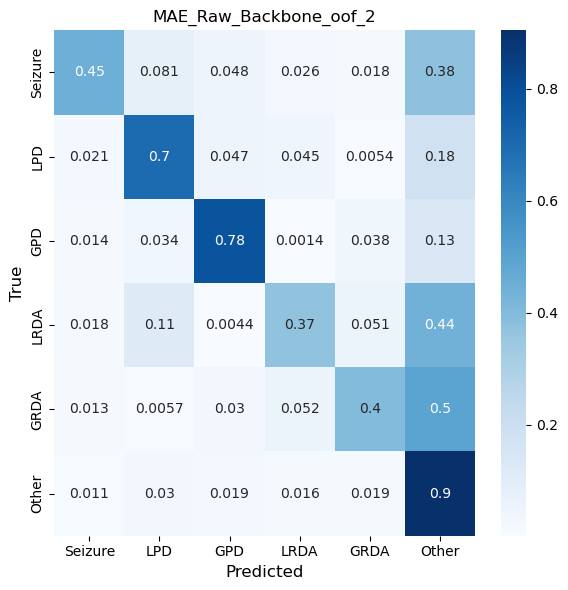

In [8]:
csv_path = f'./outputs/{ModelConfig.MODEL_NAME}_oof_2.csv'
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

display(oof_df.head())

# plot confusion matrix
cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()

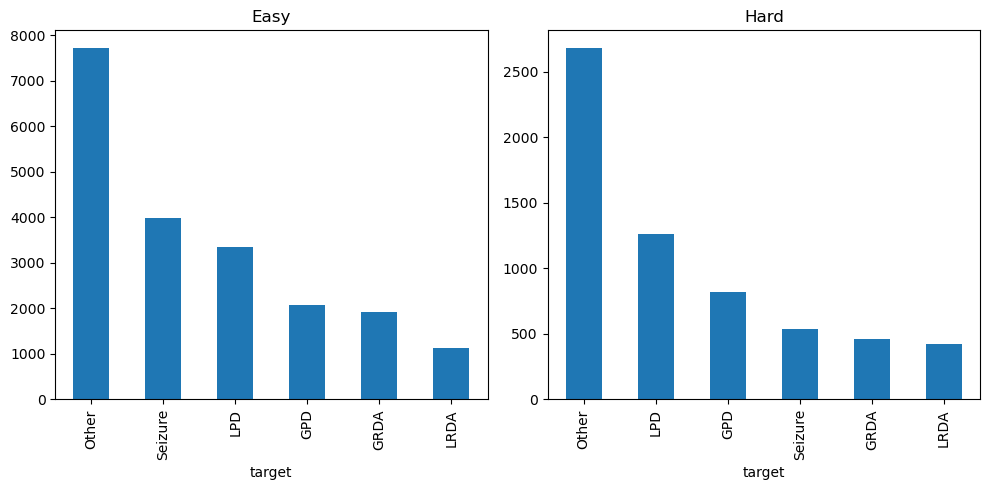

In [9]:
# check distribution of targets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
train_all["target"].value_counts().plot(kind="bar", ax=axes[0])
train_hard["target"].value_counts().plot(kind="bar", ax=axes[1])
axes[0].set_title("Easy")
axes[1].set_title("Hard")
fig.tight_layout()
plt.show()

In [ ]:
# hms_predictor = HMSPredictor(paths.OUTPUT_DIR, ModelConfig, k_fold=5)

In [ ]:
# hms_predictor.train_model(train_easy, train_hard, all_specs, all_eegs)

In [ ]:


# hms_predictor = HMSPredictor(paths.OUTPUT_DIR, ModelConfig, k_fold=5)

In [ ]:
# new figure
fig, axes = plt.subplots(6, 5, figsize=(18, 16), sharex=True, sharey=True)

plot_oof = oof_df[oof_df['kl_loss'] > 0.2]

for row in range(axes.shape[0]):
    row_selects = plot_oof[plot_oof['target_id']==row]
    target_label = BRAIN_ACTIVITY[row]
    for col in range(axes.shape[1]):
        ax = axes[row, col]
        idx = np.random.choice(row_selects.index)
        df_rows = plot_oof.loc[idx]
        ax.plot(df_rows[TARGETS].values , label='True')
        ax.plot(df_rows[TARGETS_PRED].values, label='Pred')
        ax.set_title(f"{idx} | KL: {df_rows['kl_loss']:.4f} ") #
        ax.set_xticks(range(6))
        ax.set_xticklabels(BRAIN_ACTIVITY)
        ax.grid(True)
        ax.legend()
        if col == 0:
            ax.set_ylabel(target_label, fontsize=12)
       
fig.tight_layout()
plt.show()


